## Imports

In [1]:
# Vector processing
import geopandas as gpd
import shapely
import osgb
import pyproj

# Raster processing
import rasterio
import rasterio.features
from skimage import measure
import xarray as xr
import rioxarray

# Visualisation
import matplotlib as mpl
from matplotlib import pyplot as plt
import contextily as cx
import seaborn as sns

%matplotlib widget
mpl.rcParams['axes.formatter.limits'] = (0,0)
FIGSIZE = (10, 7)

# Practical
import os
from shlex import quote
import subprocess
import warnings
from pystac_client import Client as PyStackClient
import boto3
from glob import glob
import functools
import sys
from dask.distributed import Client as DaskClient
from dask.distributed import print as distributed_print

# Calcs and modelling
import numpy as np
import pandas as pd
sys.path.append('../../../../git_packages/PhenoloPy/scripts')
import phenolopy
from scipy.stats import pearsonr

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

WORKING_CRS = 'EPSG:3035'

## Methods

### Biodiversity Data

Start by investigating the files distributed by the Plant Monitoring Survey:

In [2]:
occurrences = pd.read_csv('../../../data/Agric_data/Plant/data/occurrences_2015to2022.csv').set_index('id')
occurrences

,sample_id,taxonversionkey,preferred_taxon,domin,record_status,sensitivity_precision
id,,,,,,
1897182,888635,NBNSYS0000002205,Allium ursinum,4. 5-10%,V,NaN
1897183,888635,NBNSYS0000004319,Galium aparine,2. < 1% (several indivs),V,NaN
1897184,888635,NBNSYS0000004239,Lamium galeobdolon,1. < 1% (1-2 indivs),V,NaN
1897185,888635,NBNSYS0000002185,Hyacinthoides non-scripta,4. 5-10%,V,NaN
1897189,888639,NBNSYS0000002185,Hyacinthoides non-scripta,4. 5-10%,V,NaN
...,...,...,...,...,...,...
29215518,21166794,NBNSYS0000002031,Pteridium aquilinum,9,V,NaN
29215519,21166794,NBNSYS0000003774,Rumex acetosella,5,V,NaN
29215734,21166814,NBNSYS0000003902,Calluna vulgaris,8,V,NaN


In [3]:
# Drop spatially blurred observations
occurrences = occurrences[occurrences['sensitivity_precision'].isna()].drop(columns=['sensitivity_precision','record_status'])
occurrences

,sample_id,taxonversionkey,preferred_taxon,domin
id,,,,
1897182,888635,NBNSYS0000002205,Allium ursinum,4. 5-10%
1897183,888635,NBNSYS0000004319,Galium aparine,2. < 1% (several indivs)
1897184,888635,NBNSYS0000004239,Lamium galeobdolon,1. < 1% (1-2 indivs)
1897185,888635,NBNSYS0000002185,Hyacinthoides non-scripta,4. 5-10%
1897189,888639,NBNSYS0000002185,Hyacinthoides non-scripta,4. 5-10%
...,...,...,...,...
29215518,21166794,NBNSYS0000002031,Pteridium aquilinum,9
29215519,21166794,NBNSYS0000003774,Rumex acetosella,5
29215734,21166814,NBNSYS0000003902,Calluna vulgaris,8


In [4]:
locations = pd.read_csv('../../../data/Agric_data/Plant/data/locations_2015to2022.csv').set_index('location_id')
locations

,location_type,samplecount
location_id,,
41159,Linear plot,2
41160,Linear plot,2
41163,"Square plot 5 x 5 m, most habitats",2
41164,"Square plot 5 x 5 m, most habitats",2
41165,"Square plot 5 x 5 m, most habitats",2
...,...,...
303537,"Square plot 5 x 5 m, most habitats",1
303538,"Square plot 5 x 5 m, most habitats",1
303550,"Square plot 5 x 5 m, most habitats",1


In [5]:
_temp = pd.read_csv('../../../data/Agric_data/Plant/data/sampleinfowithlatlong_2015to2022.csv', 
                    index_col=0,
                   dtype={'location_id':'Int64'})
sample_info = gpd.GeoDataFrame(_temp,
                                geometry=gpd.GeoSeries.from_xy(_temp['LONGITUDE'],
                                                              _temp['LATITUDE']),
                               crs='EPSG:4326').set_index('id')
sample_info = sample_info.to_crs(WORKING_CRS)
sample_info['date_start'] = pd.to_datetime(sample_info['date_start'])
sample_info['year'] = sample_info['date_start'].dt.year

# Define study regions for data download later
buffer_radius = 1000
sample_info['study_zone'] = sample_info.geometry.buffer(buffer_radius)
sample_info['study_zone_bbox'] = shapely.box(*np.split(sample_info['study_zone'].bounds.values, 4, axis=1)).flatten()

sample_info

,survey_id,date_start,location_id,entered_sref,entered_sref_system,created_on,created_by_id,LATITUDE,LONGITUDE,monad,monadCRS,country,geometry,year,study_zone,study_zone_bbox
id,,,,,,,,,,,,,,,,
19727875,87,2021-07-09,222035,H0851653089,OSIE,2022-07-29 17:29:37,169848,54.426207,-7.868770,H0853,OSIE,Northern_Ireland,POINT (3174650.927 3622819.751),2021,"POLYGON ((3175650.927 3622819.751, 3175646.112...",POLYGON ((3175650.9274035688 3621819.751499645...
19726403,87,2021-07-09,222034,H0863353204,OSIE,2022-07-29 16:44:06,169848,54.427238,-7.866964,H0853,OSIE,Northern_Ireland,POINT (3174792.690 3622902.677),2021,"POLYGON ((3175792.690 3622902.677, 3175787.874...",POLYGON ((3175792.6895344253 3621902.676799679...
6973078,87,2019-09-16,222035,H0851653089,OSIE,2019-10-29 14:56:26,169848,54.426207,-7.868770,H0853,OSIE,Northern_Ireland,POINT (3174650.927 3622819.751),2019,"POLYGON ((3175650.927 3622819.751, 3175646.112...",POLYGON ((3175650.9274035688 3621819.751499645...
6959657,87,2019-08-26,221971,J3583127831,OSIE,2019-10-26 21:33:38,228514,54.181371,-5.919232,J3527,OSIE,Northern_Ireland,POINT (3291134.303 3566771.327),2019,"POLYGON ((3292134.303 3566771.327, 3292129.487...",POLYGON ((3292134.302572135 3565771.3274340653...
6958813,87,2019-08-26,221939,J3533127831,OSIE,2019-10-26 14:11:05,228514,54.181503,-5.926886,J3527,OSIE,Northern_Ireland,POINT (3290651.791 3566895.061),2019,"POLYGON ((3291651.791 3566895.061, 3291646.976...",POLYGON ((3291651.7913411325 3565895.060770185...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4026153,154,2018-09-18,203357,TR3758264170,OSGB,2018-09-19 22:34:54,172382,51.326419,1.410581,TR3764,OSGB,Britain,POINT (3723872.613 3170221.832),2018,"POLYGON ((3724872.613 3170221.832, 3724867.798...",POLYGON ((3724872.6129969773 3169221.832247921...
1212790,154,2015-08-16,146035,TV5820095500,OSGB,2015-10-05 15:26:19,89944,50.736969,0.242221,TV5895,OSGB,Britain,POINT (3634487.281 3115342.540),2015,"POLYGON ((3635487.281 3115342.540, 3635482.465...","POLYGON ((3635487.280712831 3114342.540097938,..."
1210754,154,2015-08-16,146018,TV5848495493,OSGB,2015-10-05 10:00:25,89944,50.736829,0.246240,TV5895,OSGB,Britain,POINT (3634766.035 3115289.312),2015,"POLYGON ((3635766.035 3115289.312, 3635761.220...","POLYGON ((3635766.035261252 3114289.312387059,..."


In [6]:
sample_attributes = pd.read_csv('../../../data/Agric_data/Plant/data/sampleattributes_2015to2022.csv').set_index('sample_attribute_id')
sample_attributes

,sample_id,caption,text_value
sample_attribute_id,,,
3211938,884186,NPMS Survey 1 ID,0
3211939,884186,NPMS Habitat,Neutral pastures and meadows
3211940,884186,Management,Cutting / mowing
3211941,884186,Other Management,mown for recretion
3211942,884186,NPMS Grazers,none
...,...,...,...
69646188,21179861,Rock/gravel/scree,1. < 1% (1-2 indivs)
69646189,21179861,Leaves/litter,4. 5-10%
69646190,21179861,Lichens,8. 51-75%


In [7]:
sample_attributes[sample_attributes['caption'] == 'NPMS Habitat']['text_value'].unique()

array(['Neutral pastures and meadows', 'Nutrient-poor lakes and ponds',
       'Hedgerows of native species', 'Dry deciduous woodland',
       'Wet woodland', 'Nutrient-rich lakes and ponds',
       'Dry calcareous grassland', 'Dry heathland',
       'Native conifer woods and juniper scrub', 'Dry acid grassland',
       'Arable field margins', 'Neutral damp grassland', 'Not in scheme',
       'Broadleaved woodland, hedges and scrub', 'Lowland grassland',
       'Base-rich fens, mires and springs', 'Coastal vegetated shingle',
       'Maritime cliffs and slopes', 'Rivers and streams',
       'Montane acid grassland', 'Montane rocks and scree',
       'Acid fens, mires and springs', 'Arable margins', 'Heathland',
       'Marsh and fen', 'Coastal saltmarsh', 'Wet heath',
       'Bog and wet heath', 'Freshwater', 'Inland rocks and scree',
       'Rock outcrops, cliffs and scree', 'Blanket bog', 'Coast',
       'Coastal sand dunes', 'Montane dry heathland',
       'Montane calcareous grassl

Now try to get an idea of sample size: the number of locations where spring cereals were grown in the year each sample was taken. Start by filtering the PMS data for the field margins of arable land:

In [8]:
arable_samples = sample_attributes[(sample_attributes['caption'] == 'NPMS Habitat') & sample_attributes['text_value'].isin(['Arable field margins', 'Arable margins'])]
arable_samples

,sample_id,caption,text_value
sample_attribute_id,,,
3376134,928802,NPMS Habitat,Arable field margins
3384293,931623,NPMS Habitat,Arable field margins
3384984,931906,NPMS Habitat,Arable field margins
3386744,932789,NPMS Habitat,Arable field margins
3412398,951869,NPMS Habitat,Arable field margins
...,...,...,...
68842824,20992930,NPMS Habitat,Arable field margins
68844027,20993210,NPMS Habitat,Arable field margins
68844226,20993259,NPMS Habitat,Arable field margins


In [9]:
arable_samples_loc_yr_unique = sample_info.loc[arable_samples['sample_id'].unique()][['geometry', 'year', 'study_zone', 'study_zone_bbox']].drop_duplicates(subset=['geometry', 'year'])
arable_samples_loc_yr_unique = arable_samples_loc_yr_unique[(arable_samples_loc_yr_unique['year'] <= 2020) & (arable_samples_loc_yr_unique['year'] >= 2018)]
arable_samples_loc_yr_unique

,geometry,year,study_zone,study_zone_bbox
id,,,,
2459716,POINT (3347328.898 3112656.417),2018,"POLYGON ((3348328.898 3112656.417, 3348324.083...",POLYGON ((3348328.8984529204 3111656.417126075...
3374584,POINT (3613310.248 3353483.205),2018,"POLYGON ((3614310.248 3353483.205, 3614305.433...",POLYGON ((3614310.2482128586 3352483.205378609...
3425299,POINT (3587828.892 3171514.315),2018,"POLYGON ((3588828.892 3171514.315, 3588824.076...",POLYGON ((3588828.8916301527 3170514.315482463...
3432713,POINT (3509784.399 3428080.153),2018,"POLYGON ((3510784.399 3428080.153, 3510779.584...","POLYGON ((3510784.399378102 3427080.153094661,..."
3440706,POINT (3436618.076 2977607.276),2018,"POLYGON ((3437618.076 2977607.276, 3437613.260...","POLYGON ((3437618.075516487 2976607.276026127,..."
3459504,POINT (3663124.681 3154042.788),2018,"POLYGON ((3664124.681 3154042.788, 3664119.866...",POLYGON ((3664124.680828446 3153042.7875894913...
3464792,POINT (3435572.912 2977531.088),2018,"POLYGON ((3436572.912 2977531.088, 3436568.097...",POLYGON ((3436572.9121402036 2976531.088403221...
3471909,POINT (3512107.095 3748426.777),2018,"POLYGON ((3513107.095 3748426.777, 3513102.280...",POLYGON ((3513107.0950624146 3747426.776605929...
3476728,POINT (3417815.423 3178515.683),2018,"POLYGON ((3418815.423 3178515.683, 3418810.608...","POLYGON ((3418815.423421306 3177515.683409125,..."


In [10]:
len(arable_samples_loc_yr_unique)

368

Look at the layout of sampling locations on a map

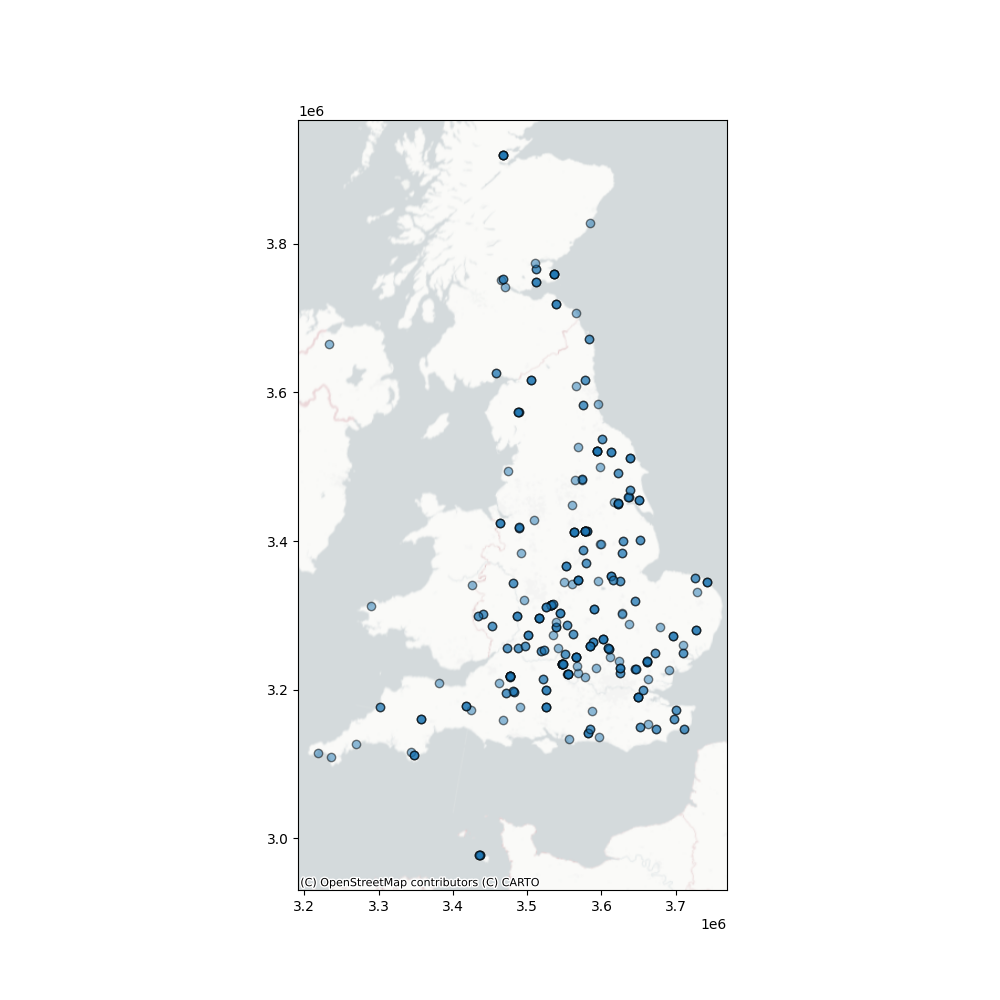

In [11]:
import contextily as cx


ax = arable_samples_loc_yr_unique.plot(figsize=(10, 10), alpha=0.5, edgecolor="k")
cx.add_basemap(ax, crs=arable_samples_loc_yr_unique.crs, source=cx.providers.CartoDB.PositronNoLabels)

Now for each of those locations download the CROME data:

In [12]:
os.listdir('.')

['Species Distribution Modelling.ipynb',
 'Introduction.md',
 'plants_agriculture.ipynb',
 '.ipynb_checkpoints',
 'Agricultural Intensity.ipynb',
 'Remote Sensing Data for Agriculture Part I.ipynb']

In [17]:
def create_zone_dir(dir_name):
    '''Builds local directory structure to download data into.'''
    base_path = '../../../data/Agric_data/NPMS_Locations/'
    to_make = os.path.join(base_path, dir_name)
    if os.path.exists(to_make):
        _crome_path = os.path.join(to_make, 'CROME')
        try:
            _files = os.listdir(_crome_path)
        except FileNotFoundError:
            os.makedirs(_crome_path)
            return to_make
            
        if len(_files) == 5:
            raise ValueError # going to skip this
        else:
            for file in _files:
                os.remove(os.path.join(_crome_path, file))

            return to_make
        
    else:
        os.mkdir(to_make)
        distributed_print('Created data dir at ' + to_make)
        return to_make

def get_geodetic_bbox(bbox, bbox_crs):
    '''Transforms a bounding box (as a shapely box) in a given CRS to EPSG:4326'''
    # Get transformer for bbox
    transform_working_to_geodetic = pyproj.Transformer.from_crs(pyproj.CRS(bbox_crs), 
                                                                pyproj.CRS('EPSG:4326'), 
                                                                always_xy=True).transform
    # Get transformed bbox (in EPSG:4326)
    bbox_geodetic_coords = transform_working_to_geodetic(*bbox.exterior.xy)
    bbox_geodetic = shapely.geometry.Polygon(np.stack(bbox_geodetic_coords, axis=1))

    return bbox_geodetic, bbox_geodetic_coords

In [18]:

def download_crome(sample_ref, year):
    # Get spatial extents for requests
    aoi_bbox = sample_info.loc[sample_ref]['study_zone_bbox'] # in projected coords
    aoi_bbox_geodetic, bbox_geodetic_coords = get_geodetic_bbox(aoi_bbox, sample_info.crs)
    
    
    # Send that as a request to the correct CROME dataset
    dir_name = 'location_' + str(sample_ref) + f'_{year}'
    try:
        data_path = create_zone_dir(dir_name)
    except ValueError:
        distributed_print(f'Already got {sample_ref}, {year}, skipping')
        return None
        
    crome_dir = os.path.join(data_path, 'CROME')
    
    subprocess.run(f'../../../data/Agric_data/get_crome_{year}.sh ' + \
                           '\"' + crome_dir + '\" ' + \
                           '\'' + f'{{"coordinates": {np.array2string(np.dstack(bbox_geodetic_coords), precision=8, separator=",", suppress_small=True)},"type":"Polygon"}}'.replace("\n", "") + '\'',
               shell=True)

# If the immediately adjacent pixels are spring cereals and this sample is on agricultural
# land instead of at boundary or adjacent, do not delete

In [19]:
for sample_ref, row in arable_samples_loc_yr_unique.iterrows():
    year = row['year']
    download_crome(sample_ref, year)


Already got 2459716, 2018, skipping
Already got 3374584, 2018, skipping
Already got 3425299, 2018, skipping
Already got 3432713, 2018, skipping
../../../data/Agric_data/NPMS_Locations/location_3440706_2018/CROME
{"coordinates": [[[-2.19269318,49.24138495],  [-2.19715221,49.25908846],  [-2.22431181,49.25611269],  [-2.21984332,49.23841042],  [-2.19269318,49.24138495]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1545  100  1370  100   175    944    120  0:00:01  0:00:01 --:--:--  1065
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3440706_2018/CROME/Crop_Map_Of_England_2018.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3440706_2018/CROME/Crop_Map_Of_England_2018.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3440706_2018/CROME/Crop_Map_Of_England_2018.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3440706_2018/CROME/Crop_Map_Of_England_2018.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3440706_2018/CROME/Crop_Map_Of_England_2018.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3440706_2018/CROME/README.TXT  
Already got 3459504, 2018, skipping
../../../data/Agric_data/NPMS_Locations/location_3464792_2018/CROME
{"coordinates": [[[-2.20671175,49.23915696],  [-2.21117557,49.25685983],  [-2.23833324,49.25388069],  [-2.23385996,49.23617905],  [-2.20671175,49.23915696]]],"type":"Polygon"}


100  1545  100  1370  100   175   1037    132  0:00:01  0:00:01 --:--:--  1169
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3464792_2018/CROME/Crop_Map_Of_England_2018.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3464792_2018/CROME/Crop_Map_Of_England_2018.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3464792_2018/CROME/Crop_Map_Of_England_2018.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3464792_2018/CROME/Crop_Map_Of_England_2018.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3464792_2018/CROME/Crop_Map_Of_England_2018.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3464792_2018/CROME/README.TXT  
../../../data/Agric_data/NPMS_Locations/location_3471909_2018/CROME
{"coordinates": [[[-3.07886666,56.16609735],  [-3.08487408,56.18372574],  [-3.11657836,56.18046253],  [-3.11055721,56.16283583],  [-3.07886666,56.16609735]]],"type":"Polygon"}


100  1545  100  1370  100   175    997    127  0:00:01  0:00:01 --:--:--  1126


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3471909_2018/CROME/Crop_Map_Of_England_2018.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3471909_2018/CROME/Crop_Map_Of_England_2018.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3471909_2018/CROME/Crop_Map_Of_England_2018.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3471909_2018/CROME/Crop_Map_Of_England_2018.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3471909_2018/CROME/Crop_Map_Of_England_2018.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3471909_2018/CROME/README.TXT  
Already got 3476728, 2018, skipping
Already got 3500670, 2018, skipping
Already got 3508410, 2018, skipping
Already got 3515215, 2018, skipping
Already got 3515219, 2018, skipping
Already got 3516966, 2018, skipping
Already got 3520435, 2018, skipping
Already got 3525612, 2018, skipping
Already got 3525619, 2018, skipping


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1545  100  1370  100   175   1115    142  0:00:01  0:00:01 --:--:--  1259


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3604197_2018/CROME/Crop_Map_Of_England_2018.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3604197_2018/CROME/Crop_Map_Of_England_2018.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3604197_2018/CROME/Crop_Map_Of_England_2018.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3604197_2018/CROME/Crop_Map_Of_England_2018.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3604197_2018/CROME/Crop_Map_Of_England_2018.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3604197_2018/CROME/README.TXT  
Already got 3627049, 2018, skipping
Already got 3632229, 2018, skipping
Already got 3637683, 2018, skipping
Already got 3658308, 2018, skipping
../../../data/Agric_data/NPMS_Locations/location_3658364_2018/CROME
{"coordinates": [[[-2.07449823,51.25576778],  [-2.07920292,51.27346152],  [-2.10753201,51.27049586],  [-2.102816

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 44024  100 43849  100   175  28112    112  0:00:01  0:00:01 --:--:-- 28220


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3658364_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3658364_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3658364_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3658364_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3658364_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Already got 3663754, 2018, skipping
Already got 3664702, 2018, skipping
Already got 3665114, 2018, skipping
Already got 3665135, 2018, skipping
Already got 3668894, 2018, skipping
Already got 3671259, 2018, skipping
Already got 3674821, 2018, skipping
Already got 3677897, 2018, skipping
../../../data/Agric_data/NPMS_Locations/location_3682116_2018/CROME
{"coordinates": [[[-1.15120

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 42302  100 42127  100   175  30947    128  0:00:01  0:00:01 --:--:-- 31081


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3682116_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3682116_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3682116_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3682116_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3682116_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_3710009_2018
../../../data/Agric_data/NPMS_Locations/location_3710009_2018/CROME
{"coordinates": [[[-1.46504676,52.10672079],  [-1.46963978,52.12443783],  [-1.49853314,52.12161309],  [-1.49392904,52.10389733],  [-1.46504676,52.10672079]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 42318  100 42143  100   175  11175     46  0:00:03  0:00:03 --:--:-- 11224
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3710009_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3710009_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3710009_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3710009_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3710009_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_3766594_2018
../../../data/Agric_data/NPMS_Locations/location_3766594_2018/CROME
{"coordinates": [[[-2.11207029,55.88130822],  [-2.11758128,55.89898595],  [-2.14912574,55.89596487],  [-2.1436011 ,55.87828869],  [-2.11207029,55.88130822]]],"type":"Polygon"}


100  1545  100  1370  100   175   1210    154  0:00:01  0:00:01 --:--:--  1364
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3766594_2018/CROME/Crop_Map_Of_England_2018.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3766594_2018/CROME/Crop_Map_Of_England_2018.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3766594_2018/CROME/Crop_Map_Of_England_2018.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3766594_2018/CROME/Crop_Map_Of_England_2018.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3766594_2018/CROME/Crop_Map_Of_England_2018.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3766594_2018/CROME/README.TXT  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_3779023_2018
../../../data/Agric_data/NPMS_Locations/location_3779023_2018/CROME
{"coordinates": [[[-0.08885744,51.66736505],  [-0.09284459,51.6851422 ],  [-0.12152863,51.68265801],  [-0.11753051,51.66488198],  [-0.08885744,51.66736505]]],"type":"Polygon"

100 40822  100 40647  100   175   8263     35  0:00:05  0:00:04  0:00:01 11015
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3779023_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3779023_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3779023_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3779023_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3779023_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_3783484_2018
../../../data/Agric_data/NPMS_Locations/location_3783484_2018/CROME
{"coordinates": [[[-1.45657838,51.34109386],  [-1.46105592,51.35881536],  [-1.48947015,51.35599963],  [-1.48498197,51.33827939],  [-1.45657838,51.34109386]]],"type":"Polygon"}


100 41857  100 41682  100   175   9100     38  0:00:04  0:00:04 --:--:--  9141
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3783484_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3783484_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3783484_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3783484_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3783484_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_3783952_2018
../../../data/Agric_data/NPMS_Locations/location_3783952_2018/CROME
{"coordinates": [[[-1.67551956,51.78650413],  [-1.68014808,51.80421327],  [-1.70882715,51.80134002],  [-1.70418776,51.78363217],  [-1.67551956,51.78650413]]],"type":"Polygon"}


100 43467  100 43292  100   175  13250     53  0:00:03  0:00:03 --:--:-- 13300


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3783952_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3783952_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3783952_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3783952_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3783952_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_3786825_2018
../../../data/Agric_data/NPMS_Locations/location_3786825_2018/CROME
{"coordinates": [[[ 0.74910454,51.05177037],  [ 0.74551885,51.06958224],  [ 0.71717819,51.0673078 ],  [ 0.72077457,51.04949694],  [ 0.74910454,51.05177037]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 42346  100 42171  100   175   9936     41  0:00:04  0:00:04 --:--:--  9977


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3786825_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3786825_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3786825_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3786825_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3786825_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_3788085_2018
../../../data/Agric_data/NPMS_Locations/location_3788085_2018/CROME
{"coordinates": [[[-1.61008017,51.80891139],  [-1.61468624,51.82662338],  [-1.64338291,51.82376591],  [-1.63876596,51.8060552 ],  [-1.61008017,51.80891139]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 43351  100 43176  100   175  10733     43  0:00:04  0:00:04 --:--:-- 10778
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3788085_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3788085_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3788085_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3788085_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3788085_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_3827547_2018
../../../data/Agric_data/NPMS_Locations/location_3827547_2018/CROME
{"coordinates": [[[-2.12476954,51.78614986],  [-2.12957497,51.80383812],  [-2.15822906,51.80085515],  [-2.15341281,51.78316824],  [-2.12476954,51.78614986]]],"type":"Polygon"}


100 43814  100 43639  100   175  17858     71  0:00:02  0:00:02 --:--:-- 17927
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3827547_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3827547_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3827547_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3827547_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3827547_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_3832124_2018
../../../data/Agric_data/NPMS_Locations/location_3832124_2018/CROME
{"coordinates": [[[-1.17039854,52.71289768],  [-1.17496387,52.73062519],  [-1.20426761,52.72786707],  [-1.19969079,52.71014085],  [-1.17039854,52.71289768]]],"type":"Polygon"}


100 44496  100 44321  100   175  11834     46  0:00:03  0:00:03 --:--:-- 11881
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3832124_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3832124_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3832124_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3832124_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3832124_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_3832184_2018
../../../data/Agric_data/NPMS_Locations/location_3832184_2018/CROME
{"coordinates": [[[-1.17030628,52.70840155],  [-1.17487089,52.72612908],  [-1.20417166,52.72337103],  [-1.19959556,52.70564478],  [-1.17030628,52.70840155]]],"type":"Polygon"}


100 44923  100 44748  100   175  18350     71  0:00:02  0:00:02 --:--:-- 18426


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3832184_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3832184_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3832184_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3832184_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3832184_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_3836336_2018
../../../data/Agric_data/NPMS_Locations/location_3836336_2018/CROME
{"coordinates": [[[-1.49521048,51.99999528],  [-1.49979957,52.01771149],  [-1.52862326,52.01488034],  [-1.52402315,51.99716542],  [-1.49521048,51.99999528]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 41875  100 41700  100   175  13138     55  0:00:03  0:00:03 --:--:-- 13197


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3836336_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3836336_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3836336_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3836336_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3836336_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_3838300_2018
../../../data/Agric_data/NPMS_Locations/location_3838300_2018/CROME
{"coordinates": [[[-1.1798913 ,53.31047326],  [-1.18455184,53.32819828],  [-1.21425751,53.32543236],  [-1.20958509,53.30770866],  [-1.1798913 ,53.31047326]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 44190  100 44015  100   175   9501     37  0:00:04  0:00:04 --:--:--  9540
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3838300_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3838300_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3838300_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3838300_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3838300_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_3838324_2018
../../../data/Agric_data/NPMS_Locations/location_3838324_2018/CROME
{"coordinates": [[[-1.1751255 ,53.30697023],  [-1.17978352,53.32469546],  [-1.20948705,53.32193075],  [-1.20481716,53.30420682],  [-1.1751255 ,53.30697023]]],"type":"Polygon"}


100 43401  100 43226  100   175  25880    104  0:00:01  0:00:01 --:--:-- 25973
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3838324_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3838324_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3838324_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3838324_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3838324_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_3838344_2018
../../../data/Agric_data/NPMS_Locations/location_3838344_2018/CROME
{"coordinates": [[[-1.18480261,53.309536  ],  [-1.18946504,53.3272608 ],  [-1.2191698 ,53.32449369],  [-1.21449549,53.3067702 ],  [-1.18480261,53.309536  ]]],"type":"Polygon"}


100 44131  100 43956  100   175  24153     96  0:00:01  0:00:01 --:--:-- 24247


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3838344_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3838344_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3838344_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3838344_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3838344_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_3842642_2018
../../../data/Agric_data/NPMS_Locations/location_3842642_2018/CROME
{"coordinates": [[[-4.53982555,50.77633098],  [-4.54539719,50.79390082],  [-4.57329236,50.79034076],  [-4.56771076,50.77277247],  [-4.53982555,50.77633098]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31013  100 30838  100   175   8397     47  0:00:03  0:00:03 --:--:--  8443
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3842642_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3842642_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3842642_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3842642_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3842642_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_3889338_2018
../../../data/Agric_data/NPMS_Locations/location_3889338_2018/CROME
{"coordinates": [[[-0.76165537,52.38920716],  [-0.76600804,52.40695359],  [-0.79512064,52.40429855],  [-0.79075664,52.38655335],  [-0.76165537,52.38920716]]],"type":"Polygon"}


100 42787  100 42612  100   175   9024     37  0:00:04  0:00:04 --:--:--  9063
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3889338_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3889338_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3889338_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3889338_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3889338_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_3891935_2018
../../../data/Agric_data/NPMS_Locations/location_3891935_2018/CROME
{"coordinates": [[[-2.5656252 ,55.94736446],  [-2.57135429,55.96501953],  [-2.60292026,55.9618856 ],  [-2.59717753,55.94423214],  [-2.5656252 ,55.94736446]]],"type":"Polygon"}


100  1545  100  1370  100   175   1119    143  0:00:01  0:00:01 --:--:--  1263
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3891935_2018/CROME/Crop_Map_Of_England_2018.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3891935_2018/CROME/Crop_Map_Of_England_2018.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3891935_2018/CROME/Crop_Map_Of_England_2018.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3891935_2018/CROME/Crop_Map_Of_England_2018.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3891935_2018/CROME/Crop_Map_Of_England_2018.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3891935_2018/CROME/README.TXT  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_3922466_2018
../../../data/Agric_data/NPMS_Locations/location_3922466_2018/CROME
{"coordinates": [[[-2.17424734,52.36840655],  [-2.17916445,52.38608948],  [-2.20818662,52.38308879],  [-2.20325836,52.36540724],  [-2.17424734,52.36840655]]],"type":"Polygon"

100 43215  100 43040  100   175  10496     42  0:00:04  0:00:04 --:--:-- 10540


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3922466_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3922466_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3922466_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3922466_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3922466_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_3937192_2018
../../../data/Agric_data/NPMS_Locations/location_3937192_2018/CROME
{"coordinates": [[[-1.18838774,54.2837985 ],  [-1.19320716,54.3015208 ],  [-1.22359788,54.29874372],  [-1.2187659 ,54.28102276],  [-1.18838774,54.2837985 ]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 44360  100 44185  100   175  10071     39  0:00:04  0:00:04 --:--:-- 14089


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3937192_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3937192_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3937192_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3937192_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3937192_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_3946307_2018
../../../data/Agric_data/NPMS_Locations/location_3946307_2018/CROME
{"coordinates": [[[ 1.08312238,51.31301633],  [ 1.07963669,51.33083862],  [ 1.05112224,51.32864405],  [ 1.05461879,51.31082274],  [ 1.08312238,51.31301633]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 41099  100 40924  100   175   8310     35  0:00:05  0:00:04  0:00:01 11096
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3946307_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3946307_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3946307_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3946307_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3946307_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_3986270_2018
../../../data/Agric_data/NPMS_Locations/location_3986270_2018/CROME
{"coordinates": [[[-1.71954112,52.32008865],  [-1.72426825,52.33779312],  [-1.75328492,52.33490412],  [-1.74854661,52.31720098],  [-1.71954112,52.32008865]]],"type":"Polygon"}


100 43941  100 43766  100   175  12580     50  0:00:03  0:00:03 --:--:-- 12633
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3986270_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3986270_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3986270_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3986270_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3986270_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_3996808_2018
../../../data/Agric_data/NPMS_Locations/location_3996808_2018/CROME
{"coordinates": [[[-2.94122274,54.58247815],  [-2.94684864,54.60011537],  [-2.97734715,54.59690376],  [-2.97170873,54.57926811],  [-2.94122274,54.58247815]]],"type":"Polygon"}


100 42266  100 42091  100   175   8775     36  0:00:04  0:00:04 --:--:-- 11790


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3996808_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3996808_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3996808_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3996808_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3996808_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_3998443_2018
../../../data/Agric_data/NPMS_Locations/location_3998443_2018/CROME
{"coordinates": [[[-3.72567983,50.73093897],  [-3.7309345 ,50.7485537 ],  [-3.75885401,50.74519161],  [-3.7535893 ,50.72757833],  [-3.72567983,50.73093897]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 42357  100 42182  100   175   8923     37  0:00:04  0:00:04 --:--:-- 11997


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3998443_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3998443_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3998443_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3998443_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3998443_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_3998964_2018
../../../data/Agric_data/NPMS_Locations/location_3998964_2018/CROME
{"coordinates": [[[-2.80740617,54.9921861 ],  [-2.81305328,55.00982951],  [-2.84386458,55.00664636],  [-2.83820462,54.98900453],  [-2.80740617,54.9921861 ]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 43307  100 43132  100   175   8517     34  0:00:05  0:00:05 --:--:-- 11308


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3998964_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3998964_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3998964_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3998964_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_3998964_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_4000121_2018
../../../data/Agric_data/NPMS_Locations/location_4000121_2018/CROME
{"coordinates": [[[-7.12020396,54.91967637],  [-7.12771038,54.9370609 ],  [-7.15812549,54.93282136],  [-7.15060702,54.91543891],  [-7.12020396,54.91967637]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1545  100  1370  100   175   1542    197 --:--:-- --:--:-- --:--:--  1739
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4000121_2018/CROME/Crop_Map_Of_England_2018.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4000121_2018/CROME/Crop_Map_Of_England_2018.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4000121_2018/CROME/Crop_Map_Of_England_2018.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4000121_2018/CROME/Crop_Map_Of_England_2018.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4000121_2018/CROME/Crop_Map_Of_England_2018.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4000121_2018/CROME/README.TXT  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_4003495_2018
../../../data/Agric_data/NPMS_Locations/location_4003495_2018/CROME
{"coordinates": [[[-0.87293798,50.7886336 ],  [-0.87711434,50.80638377],  [-0.90522362,50.80371526],  [-0.90103688,50.78596626],  [-0.87293798,50.7886336 ]]],"type":"Polygon"

100 28761  100 28586  100   175   9275     56  0:00:03  0:00:03 --:--:--  9334
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4003495_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4003495_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4003495_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4003495_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4003495_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_4006597_2018
../../../data/Agric_data/NPMS_Locations/location_4006597_2018/CROME
{"coordinates": [[[-0.39273605,51.94513348],  [-0.39687982,51.96289715],  [-0.42572492,51.96033628],  [-0.42157005,51.94257377],  [-0.39273605,51.94513348]]],"type":"Polygon"}


100 42588  100 42413  100   175  14676     60  0:00:02  0:00:02 --:--:-- 14736
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4006597_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4006597_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4006597_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4006597_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4006597_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_4006618_2019
../../../data/Agric_data/NPMS_Locations/location_4006618_2019/CROME
{"coordinates": [[[-0.39273605,51.94513348],  [-0.39687982,51.96289715],  [-0.42572492,51.96033628],  [-0.42157005,51.94257377],  [-0.39273605,51.94513348]]],"type":"Polygon"}


100 44820  100 44645  100   175   9381     36  0:00:04  0:00:04 --:--:--  9659
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4006618_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4006618_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4006618_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4006618_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4006618_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_4010203_2018
../../../data/Agric_data/NPMS_Locations/location_4010203_2018/CROME
{"coordinates": [[[-0.6878472 ,51.99303677],  [-0.69211469,52.01078804],  [-0.72097578,52.00815451],  [-0.71669719,51.99040443],  [-0.6878472 ,51.99303677]]],"type":"Polygon"}


100 44328  100 44153  100   175  10551     41  0:00:04  0:00:04 --:--:-- 10594


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4010203_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4010203_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4010203_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4010203_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4010203_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_4013078_2018
../../../data/Agric_data/NPMS_Locations/location_4013078_2018/CROME
{"coordinates": [[[-1.39955001,53.27015785],  [-1.4042952 ,53.28787318],  [-1.43396106,53.28505369],  [-1.42920404,53.2673397 ],  [-1.39955001,53.27015785]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 42769  100 42594  100   175  10007     41  0:00:04  0:00:04 --:--:-- 10049


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4013078_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4013078_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4013078_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4013078_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4013078_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_4013092_2018
../../../data/Agric_data/NPMS_Locations/location_4013092_2018/CROME
{"coordinates": [[[-1.40033542,53.26868744],  [-1.40508071,53.28640274],  [-1.43474552,53.28358308],  [-1.42998841,53.26586911],  [-1.40033542,53.26868744]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 42644  100 42469  100   175  31202    128  0:00:01  0:00:01 --:--:-- 31355


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4013092_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4013092_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4013092_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4013092_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4013092_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_4015517_2018
../../../data/Agric_data/NPMS_Locations/location_4015517_2018/CROME
{"coordinates": [[[-4.34339005,57.59559867],  [-4.35032042,57.61315724],  [-4.38312363,57.60956392],  [-4.37617851,57.59200729],  [-4.34339005,57.59559867]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1545  100  1370  100   175   1419    181 --:--:-- --:--:-- --:--:--  1601
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4015517_2018/CROME/Crop_Map_Of_England_2018.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4015517_2018/CROME/Crop_Map_Of_England_2018.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4015517_2018/CROME/Crop_Map_Of_England_2018.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4015517_2018/CROME/Crop_Map_Of_England_2018.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4015517_2018/CROME/Crop_Map_Of_England_2018.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4015517_2018/CROME/README.TXT  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_4015545_2018
../../../data/Agric_data/NPMS_Locations/location_4015545_2018/CROME
{"coordinates": [[[-4.34049111,57.59684766],  [-4.3474204 ,57.6144064 ],  [-4.38022495,57.61081378],  [-4.3732809 ,57.59325698],  [-4.34049111,57.59684766]]],"type":"Polygon"

100  1545  100  1370  100   175   1412    180 --:--:-- --:--:-- --:--:--  1592
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4015545_2018/CROME/Crop_Map_Of_England_2018.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4015545_2018/CROME/Crop_Map_Of_England_2018.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4015545_2018/CROME/Crop_Map_Of_England_2018.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4015545_2018/CROME/Crop_Map_Of_England_2018.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4015545_2018/CROME/Crop_Map_Of_England_2018.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4015545_2018/CROME/README.TXT  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_4022525_2018
../../../data/Agric_data/NPMS_Locations/location_4022525_2018/CROME
{"coordinates": [[[-3.83921312,56.10958445],  [-3.84555384,56.12717134],  [-3.8771556 ,56.12372108],  [-3.87080132,56.10613597],  [-3.83921312,56.10958445]]],"type":"Polygon"

100  1545  100  1370  100   175   1595    203 --:--:-- --:--:-- --:--:--  1800
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4022525_2018/CROME/Crop_Map_Of_England_2018.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4022525_2018/CROME/Crop_Map_Of_England_2018.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4022525_2018/CROME/Crop_Map_Of_England_2018.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4022525_2018/CROME/Crop_Map_Of_England_2018.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4022525_2018/CROME/Crop_Map_Of_England_2018.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4022525_2018/CROME/README.TXT  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_4024819_2018
../../../data/Agric_data/NPMS_Locations/location_4024819_2018/CROME
{"coordinates": [[[ 1.28513133,52.30357529],  [ 1.28161327,52.32140027],  [ 1.25246194,52.31924821],  [ 1.25599149,52.30142422],  [ 1.28513133,52.30357529]]],"type":"Polygon"

100 44401  100 44226  100   175   8586     33  0:00:05  0:00:05 --:--:-- 12031


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4024819_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4024819_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4024819_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4024819_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4024819_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_4030758_2018
../../../data/Agric_data/NPMS_Locations/location_4030758_2018/CROME
{"coordinates": [[[-0.68993899,51.99273634],  [-0.69420727,52.01048753],  [-0.72306807,52.00785348],  [-0.71878869,51.99010349],  [-0.68993899,51.99273634]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 44543  100 44368  100   175  38455    151  0:00:01  0:00:01 --:--:-- 38632


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4030758_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4030758_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4030758_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4030758_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4030758_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_4033339_2018
../../../data/Agric_data/NPMS_Locations/location_4033339_2018/CROME
{"coordinates": [[[-2.33119158,51.76452877],  [-2.33607487,51.7822073 ],  [-2.36470374,51.77917415],  [-2.35980966,51.76149699],  [-2.33119158,51.76452877]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 42449  100 42274  100   175  15502     64  0:00:02  0:00:02 --:--:-- 15566


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4033339_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4033339_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4033339_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4033339_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4033339_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_4037567_2018
../../../data/Agric_data/NPMS_Locations/location_4037567_2018/CROME
{"coordinates": [[[-1.69184237,55.10341075],  [-1.69702087,55.12110894],  [-1.7279889 ,55.11819971],  [-1.72279731,55.10050297],  [-1.69184237,55.10341075]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 43016  100 42841  100   175   8359     34  0:00:05  0:00:05 --:--:-- 10979
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4037567_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4037567_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4037567_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4037567_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4037567_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_4050916_2018
../../../data/Agric_data/NPMS_Locations/location_4050916_2018/CROME
{"coordinates": [[[-1.19510764,54.28031101],  [-1.19992937,54.29803302],  [-1.23031717,54.29525431],  [-1.22548289,54.27753365],  [-1.19510764,54.28031101]]],"type":"Polygon"}


100 44630  100 44455  100   175  19124     75  0:00:02  0:00:02 --:--:-- 19203


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4050916_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4050916_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4050916_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4050916_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4050916_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_4055635_2018
../../../data/Agric_data/NPMS_Locations/location_4055635_2018/CROME
{"coordinates": [[[-0.31695106,51.84758015],  [-0.32105177,51.86534734],  [-0.34983861,51.86280584],  [-0.34572685,51.84503979],  [-0.31695106,51.84758015]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 43374  100 43199  100   175   8594     34  0:00:05  0:00:05 --:--:-- 11353
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4055635_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4055635_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4055635_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4055635_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4055635_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_4057151_2018
../../../data/Agric_data/NPMS_Locations/location_4057151_2018/CROME
{"coordinates": [[[-2.72011246,56.29815696],  [-2.72598391,56.31580417],  [-2.75782092,56.31262816],  [-2.75193558,56.2949826 ],  [-2.72011246,56.29815696]]],"type":"Polygon"}


100  1545  100  1370  100   175   1138    145  0:00:01  0:00:01 --:--:--  1284
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4057151_2018/CROME/Crop_Map_Of_England_2018.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4057151_2018/CROME/Crop_Map_Of_England_2018.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4057151_2018/CROME/Crop_Map_Of_England_2018.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4057151_2018/CROME/Crop_Map_Of_England_2018.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4057151_2018/CROME/Crop_Map_Of_England_2018.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4057151_2018/CROME/README.TXT  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_4057301_2018
../../../data/Agric_data/NPMS_Locations/location_4057301_2018/CROME
{"coordinates": [[[-2.71977444,56.29736819],  [-2.72564556,56.31501542],  [-2.75748196,56.3118395 ],  [-2.75159694,56.29419393],  [-2.71977444,56.29736819]]],"type":"Polygon"

100  1545  100  1370  100   175   1741    222 --:--:-- --:--:-- --:--:--  1963
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4057301_2018/CROME/Crop_Map_Of_England_2018.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4057301_2018/CROME/Crop_Map_Of_England_2018.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4057301_2018/CROME/Crop_Map_Of_England_2018.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4057301_2018/CROME/Crop_Map_Of_England_2018.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4057301_2018/CROME/Crop_Map_Of_England_2018.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4057301_2018/CROME/README.TXT  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_4058675_2018
../../../data/Agric_data/NPMS_Locations/location_4058675_2018/CROME
{"coordinates": [[[ 0.1992803 ,51.7470686 ],  [ 0.19539655,51.76485655],  [ 0.16664916,51.76244228],  [ 0.17054395,51.74465542],  [ 0.1992803 ,51.7470686 ]]],"type":"Polygon"

100 41421  100 41246  100   175   8165     34  0:00:05  0:00:05 --:--:-- 10854


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4058675_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4058675_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4058675_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4058675_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4058675_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_4058725_2018
../../../data/Agric_data/NPMS_Locations/location_4058725_2018/CROME
{"coordinates": [[[ 0.20473438,51.74422325],  [ 0.20085314,51.76201142],  [ 0.17210729,51.7595985 ],  [ 0.17599957,51.74181142],  [ 0.20473438,51.74422325]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 41312  100 41137  100   175  19381     82  0:00:02  0:00:02 --:--:-- 19468


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4058725_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4058725_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4058725_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4058725_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4058725_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_4059133_2018
../../../data/Agric_data/NPMS_Locations/location_4059133_2018/CROME
{"coordinates": [[[-1.10223628,52.05301828],  [-1.106677  ,52.07075161],  [-1.13555523,52.06801612],  [-1.13110343,52.05028404],  [-1.10223628,52.05301828]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 42902  100 42727  100   175   8765     35  0:00:05  0:00:04  0:00:01  9194
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4059133_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4059133_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4059133_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4059133_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4059133_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_4064724_2018
../../../data/Agric_data/NPMS_Locations/location_4064724_2018/CROME
{"coordinates": [[[-1.62538688,52.3615471 ],  [-1.63008262,52.37925569],  [-1.65913135,52.37638935],  [-1.65442439,52.35868207],  [-1.62538688,52.3615471 ]]],"type":"Polygon"}


100 42349  100 42174  100   175  11029     45  0:00:03  0:00:03 --:--:-- 11074
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4064724_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4064724_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4064724_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4064724_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4064724_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_4067378_2018
../../../data/Agric_data/NPMS_Locations/location_4067378_2018/CROME
{"coordinates": [[[-1.62577307,52.3593005 ],  [-1.63046862,52.37700909],  [-1.65951587,52.37414267],  [-1.6548091 ,52.3564354 ],  [-1.62577307,52.3593005 ]]],"type":"Polygon"}


100 42241  100 42066  100   175  36040    149  0:00:01  0:00:01 --:--:-- 36196


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4067378_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4067378_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4067378_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4067378_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4067378_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_4067427_2018
../../../data/Agric_data/NPMS_Locations/location_4067427_2018/CROME
{"coordinates": [[[-1.62800404,52.35945141],  [-1.63270051,52.37715989],  [-1.66174773,52.37429293],  [-1.65704005,52.35658576],  [-1.62800404,52.35945141]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 42539  100 42364  100   175  36544    150  0:00:01  0:00:01 --:--:-- 36703
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4067427_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4067427_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4067427_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4067427_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4067427_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_4067482_2018
../../../data/Agric_data/NPMS_Locations/location_4067482_2018/CROME
{"coordinates": [[[-1.63005849,52.35788439],  [-1.63475554,52.37559278],  [-1.66380164,52.37272533],  [-1.65909337,52.35501825],  [-1.63005849,52.35788439]]],"type":"Polygon"}


100 42516  100 42341  100   175  33078    136  0:00:01  0:00:01 --:--:-- 33241
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4067482_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4067482_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4067482_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4067482_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4067482_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_4067641_2018
../../../data/Agric_data/NPMS_Locations/location_4067641_2018/CROME
{"coordinates": [[[-1.62913749,52.35738698],  [-1.6338341 ,52.37509542],  [-1.66287992,52.3722282 ],  [-1.6581721 ,52.35452107],  [-1.62913749,52.35738698]]],"type":"Polygon"}


100 42478  100 42303  100   175  47716    197 --:--:-- --:--:-- --:--:-- 47889
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4067641_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4067641_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4067641_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4067641_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4067641_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_4067779_2018
../../../data/Agric_data/NPMS_Locations/location_4067779_2018/CROME
{"coordinates": [[[-1.62935032,52.35652448],  [-1.63404688,52.37423292],  [-1.66309213,52.37136565],  [-1.65838436,52.35365853],  [-1.62935032,52.35652448]]],"type":"Polygon"}


100 42577  100 42402  100   175  30258    124  0:00:01  0:00:01 --:--:-- 30390


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4067779_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4067779_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4067779_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4067779_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4067779_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_4067905_2018
../../../data/Agric_data/NPMS_Locations/location_4067905_2018/CROME
{"coordinates": [[[-1.62700668,52.35756009],  [-1.63170246,52.37526863],  [-1.66074851,52.37240193],  [-1.65604152,52.3546947 ],  [-1.62700668,52.35756009]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 42390  100 42215  100   175  33077    137  0:00:01  0:00:01 --:--:-- 33221


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4067905_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4067905_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4067905_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4067905_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4067905_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_4067961_2018
../../../data/Agric_data/NPMS_Locations/location_4067961_2018/CROME
{"coordinates": [[[-1.62953184,52.36114658],  [-1.63422918,52.37885498],  [-1.66327742,52.37598763],  [-1.65856887,52.35828054],  [-1.62953184,52.36114658]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 42504  100 42329  100   175  38706    160  0:00:01  0:00:01 --:--:-- 38887


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4067961_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4067961_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4067961_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4067961_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4067961_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_4083731_2018
../../../data/Agric_data/NPMS_Locations/location_4083731_2018/CROME
{"coordinates": [[[-2.81715556,50.94586402],  [-2.82209853,50.96352391],  [-2.85019909,50.96038039],  [-2.84524586,50.94272188],  [-2.81715556,50.94586402]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 42637  100 42462  100   175   9555     39  0:00:04  0:00:04 --:--:-- 13166
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4083731_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4083731_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4083731_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4083731_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4083731_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_4097415_2018
../../../data/Agric_data/NPMS_Locations/location_4097415_2018/CROME
{"coordinates": [[[ 0.33015555,51.41762523],  [ 0.32636393,51.43541976],  [ 0.29781661,51.43304008],  [ 0.30161908,51.41524662],  [ 0.33015555,51.41762523]]],"type":"Polygon"}


100 42402  100 42227  100   175  10417     43  0:00:04  0:00:04 --:--:-- 10461


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4097415_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4097415_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4097415_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4097415_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4097415_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_4101305_2018
../../../data/Agric_data/NPMS_Locations/location_4101305_2018/CROME
{"coordinates": [[[-3.14111826,56.32527488],  [-3.14718823,56.34289998],  [-3.17901659,56.33961956],  [-3.17293277,56.32199617],  [-3.14111826,56.32527488]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1545  100  1370  100   175   1479    188 --:--:-- --:--:-- --:--:--  1668
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4101305_2018/CROME/Crop_Map_Of_England_2018.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4101305_2018/CROME/Crop_Map_Of_England_2018.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4101305_2018/CROME/Crop_Map_Of_England_2018.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4101305_2018/CROME/Crop_Map_Of_England_2018.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4101305_2018/CROME/Crop_Map_Of_England_2018.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4101305_2018/CROME/README.TXT  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_4101313_2018
../../../data/Agric_data/NPMS_Locations/location_4101313_2018/CROME
{"coordinates": [[[-3.79170143,56.13312872],  [-3.79802585,56.15071825],  [-3.82965011,56.14727944],  [-3.82331211,56.12969167],  [-3.79170143,56.13312872]]],"type":"Polygon"

100  1545  100  1370  100   175   1163    148  0:00:01  0:00:01 --:--:--  1312
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4101313_2018/CROME/Crop_Map_Of_England_2018.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4101313_2018/CROME/Crop_Map_Of_England_2018.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4101313_2018/CROME/Crop_Map_Of_England_2018.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4101313_2018/CROME/Crop_Map_Of_England_2018.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4101313_2018/CROME/Crop_Map_Of_England_2018.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4101313_2018/CROME/README.TXT  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_4109705_2018
../../../data/Agric_data/NPMS_Locations/location_4109705_2018/CROME
{"coordinates": [[[ 0.85911863,51.78129411],  [ 0.85549136,51.7991063 ],  [ 0.82669343,51.79685346],  [ 0.83033182,51.77904229],  [ 0.85911863,51.78129411]]],"type":"Polygon"

100 40717  100 40542  100   175   8980     38  0:00:04  0:00:04 --:--:--  9287
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4109705_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4109705_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4109705_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4109705_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4109705_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_4116721_2018
../../../data/Agric_data/NPMS_Locations/location_4116721_2018/CROME
{"coordinates": [[[-5.27196098,50.06078624],  [-5.27768026,50.0783201 ],  [-5.30511589,50.07459089],  [-5.29938711,50.05705862],  [-5.27196098,50.06078624]]],"type":"Polygon"}


100 28593  100 28418  100   175   8523     52  0:00:03  0:00:03 --:--:--  8578


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4116721_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4116721_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4116721_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4116721_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4116721_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_4146012_2018
../../../data/Agric_data/NPMS_Locations/location_4146012_2018/CROME
{"coordinates": [[[-0.98030235,51.78812067],  [-0.98465699,51.80586056],  [-1.01337354,51.80315723],  [-1.00900796,51.78541856],  [-0.98030235,51.78812067]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 41800  100 41625  100   175  11268     47  0:00:03  0:00:03 --:--:-- 11315
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4146012_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4146012_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4146012_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4146012_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4146012_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_4146128_2018
../../../data/Agric_data/NPMS_Locations/location_4146128_2018/CROME
{"coordinates": [[[-0.97859271,51.78613647],  [-0.98294639,51.80387644],  [-1.01166178,51.80117355],  [-1.00729715,51.7834348 ],  [-0.97859271,51.78613647]]],"type":"Polygon"}


100 41878  100 41703  100   175  33055    138  0:00:01  0:00:01 --:--:-- 33183
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4146128_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4146128_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4146128_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4146128_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4146128_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_4155055_2018
../../../data/Agric_data/NPMS_Locations/location_4155055_2018/CROME
{"coordinates": [[[-0.74730118,51.55650625],  [-0.75153214,51.57425721],  [-0.78011539,51.57161286],  [-0.7758736 ,51.55386308],  [-0.74730118,51.55650625]]],"type":"Polygon"}


100 42299  100 42124  100   175  10256     42  0:00:04  0:00:04 --:--:-- 10301


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4155055_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4155055_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4155055_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4155055_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4155055_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_4292387_2018
../../../data/Agric_data/NPMS_Locations/location_4292387_2018/CROME
{"coordinates": [[[-0.56380323,51.68835415],  [-0.56798002,51.70611206],  [-0.59665462,51.70351147],  [-0.5924669 ,51.68575473],  [-0.56380323,51.68835415]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 42468  100 42293  100   175  10649     44  0:00:03  0:00:03 --:--:-- 10691


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4292387_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4292387_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4292387_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4292387_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4292387_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_4296914_2018
../../../data/Agric_data/NPMS_Locations/location_4296914_2018/CROME
{"coordinates": [[[-1.23086047,51.67483502],  [-1.23529767,51.69256464],  [-1.26393029,51.68980105],  [-1.25948224,51.67207268],  [-1.23086047,51.67483502]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 42428  100 42253  100   175  13976     57  0:00:03  0:00:03 --:--:-- 14035


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4296914_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4296914_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4296914_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4296914_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4296914_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_4296922_2018
../../../data/Agric_data/NPMS_Locations/location_4296922_2018/CROME
{"coordinates": [[[-1.22068323,51.6728525 ],  [-1.22511615,51.69058257],  [-1.25374805,51.68782149],  [-1.24930429,51.67009266],  [-1.22068323,51.6728525 ]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 42325  100 42150  100   175  26470    109  0:00:01  0:00:01 --:--:-- 26569


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4296922_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4296922_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4296922_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4296922_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4296922_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_4296923_2018
../../../data/Agric_data/NPMS_Locations/location_4296923_2018/CROME
{"coordinates": [[[-1.21775979,51.67464055],  [-1.22219181,51.69237073],  [-1.25082499,51.68961035],  [-1.24638212,51.67188141],  [-1.21775979,51.67464055]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 42398  100 42223  100   175  35798    148  0:00:01  0:00:01 --:--:-- 35960


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4296923_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4296923_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4296923_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4296923_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4296923_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_4296924_2018
../../../data/Agric_data/NPMS_Locations/location_4296924_2018/CROME
{"coordinates": [[[-1.21850959,51.67897093],  [-1.22294252,51.69670106],  [-1.25157837,51.69394046],  [-1.24713458,51.67621157],  [-1.21850959,51.67897093]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 42449  100 42274  100   175  24442    101  0:00:01  0:00:01 --:--:-- 24536


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4296924_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4296924_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4296924_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4296924_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4296924_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_4296925_2018
../../../data/Agric_data/NPMS_Locations/location_4296925_2018/CROME
{"coordinates": [[[-1.21805042,51.67456155],  [-1.22248255,51.69229173],  [-1.25111566,51.68953127],  [-1.24667268,51.67180234],  [-1.21805042,51.67456155]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 42418  100 42243  100   175  40006    165  0:00:01  0:00:01 --:--:-- 40206


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4296925_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4296925_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4296925_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4296925_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4296925_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_4296927_2018
../../../data/Agric_data/NPMS_Locations/location_4296927_2018/CROME
{"coordinates": [[[-1.22044187,51.67259011],  [-1.22487465,51.69032019],  [-1.25350641,51.68755918],  [-1.24906277,51.66983033],  [-1.22044187,51.67259011]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 42255  100 42080  100   175  43293    180 --:--:-- --:--:-- --:--:-- 43472


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4296927_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4296927_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4296927_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4296927_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4296927_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_4300248_2018
../../../data/Agric_data/NPMS_Locations/location_4300248_2018/CROME
{"coordinates": [[[ 1.0685033 ,51.20817718],  [ 1.06502362,51.2259995 ],  [ 1.03657431,51.22380209],  [ 1.04006478,51.20598075],  [ 1.0685033 ,51.20817718]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 41584  100 41409  100   175   9434     39  0:00:04  0:00:04 --:--:-- 13013


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4300248_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4300248_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4300248_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4300248_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4300248_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_4395704_2018
../../../data/Agric_data/NPMS_Locations/location_4395704_2018/CROME
{"coordinates": [[[-1.19870586,51.80498291],  [-1.20314907,51.82271325],  [-1.23186501,51.81995637],  [-1.22741087,51.80222727],  [-1.19870586,51.80498291]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 41770  100 41595  100   175   9670     40  0:00:04  0:00:04 --:--:--  9711


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4395704_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4395704_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4395704_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4395704_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4395704_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_4433567_2018
../../../data/Agric_data/NPMS_Locations/location_4433567_2018/CROME
{"coordinates": [[[ 0.44413466,51.06175385],  [ 0.44043003,51.07955454],  [ 0.41209617,51.07720545],  [ 0.41581146,51.0594058 ],  [ 0.44413466,51.06175385]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 43274  100 43099  100   175  11225     45  0:00:03  0:00:03 --:--:-- 11269


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4433567_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4433567_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4433567_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4433567_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4433567_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_4438684_2018
../../../data/Agric_data/NPMS_Locations/location_4438684_2018/CROME
{"coordinates": [[[-5.1033439 ,51.94851382],  [-5.10935064,51.9660426 ],  [-5.13791791,51.96233242],  [-5.13190064,51.94480531],  [-5.1033439 ,51.94851382]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1545  100  1370  100   175   1261    161  0:00:01  0:00:01 --:--:--  1423
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4438684_2018/CROME/Crop_Map_Of_England_2018.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4438684_2018/CROME/Crop_Map_Of_England_2018.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4438684_2018/CROME/Crop_Map_Of_England_2018.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4438684_2018/CROME/Crop_Map_Of_England_2018.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4438684_2018/CROME/Crop_Map_Of_England_2018.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4438684_2018/CROME/README.TXT  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_4530401_2018
../../../data/Agric_data/NPMS_Locations/location_4530401_2018/CROME
{"coordinates": [[[-1.99070562,51.81947701],  [-1.99546338,51.83717141],  [-2.02414588,51.83422085],  [-2.01937726,51.81652779],  [-1.99070562,51.81947701]]],"type":"Polygon"

100 42046  100 41871  100   175  17596     73  0:00:02  0:00:02 --:--:-- 17666


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4530401_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4530401_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4530401_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4530401_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4530401_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_4531574_2018
../../../data/Agric_data/NPMS_Locations/location_4531574_2018/CROME
{"coordinates": [[[-1.43721478,52.65697727],  [-1.44187993,52.67469313],  [-1.4711322 ,52.67187012],  [-1.46645563,52.65415557],  [-1.43721478,52.65697727]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 43564  100 43389  100   175  13221     53  0:00:03  0:00:03 --:--:-- 13277


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4531574_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4531574_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4531574_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4531574_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4531574_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_4531695_2018
../../../data/Agric_data/NPMS_Locations/location_4531695_2018/CROME
{"coordinates": [[[-1.08893481,51.56859638],  [-1.09330125,51.58633274],  [-1.12187491,51.58360477],  [-1.11749767,51.56586964],  [-1.08893481,51.56859638]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 42556  100 42381  100   175  12501     51  0:00:03  0:00:03 --:--:-- 12553


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4531695_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4531695_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4531695_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4531695_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4531695_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_4531698_2018
../../../data/Agric_data/NPMS_Locations/location_4531698_2018/CROME
{"coordinates": [[[-1.08854616,51.56854839],  [-1.09291244,51.58628477],  [-1.1214861 ,51.5835569 ],  [-1.11710901,51.56582175],  [-1.08854616,51.56854839]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 42502  100 42327  100   175  28810    119  0:00:01  0:00:01 --:--:-- 28932
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4531698_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4531698_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4531698_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4531698_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4531698_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_4535848_2018
../../../data/Agric_data/NPMS_Locations/location_4535848_2018/CROME
{"coordinates": [[[-2.90777524,53.22662728],  [-2.91313598,53.24427026],  [-2.9426819 ,53.24108136],  [-2.93730956,53.22343988],  [-2.90777524,53.22662728]]],"type":"Polygon"}


100 42670  100 42495  100   175  10740     44  0:00:03  0:00:03 --:--:-- 10783
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4535848_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4535848_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4535848_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4535848_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4535848_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_4557903_2018
../../../data/Agric_data/NPMS_Locations/location_4557903_2018/CROME
{"coordinates": [[[-2.38090931,52.91987036],  [-2.38600077,52.93754087],  [-2.4153731 ,52.93448415],  [-2.41027018,52.91681506],  [-2.38090931,52.91987036]]],"type":"Polygon"}


100 42779  100 42604  100   175   9406     38  0:00:04  0:00:04 --:--:--  9711
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4557903_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4557903_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4557903_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4557903_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4557903_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_4580076_2018
../../../data/Agric_data/NPMS_Locations/location_4580076_2018/CROME
{"coordinates": [[[-1.08734339,54.09987464],  [-1.09208981,54.11760178],  [-1.12235378,54.11485131],  [-1.11759492,54.09712551],  [-1.08734339,54.09987464]]],"type":"Polygon"}


100 44796  100 44621  100   175  10313     40  0:00:04  0:00:04 --:--:-- 10355


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4580076_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4580076_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4580076_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4580076_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4580076_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_4584546_2018
../../../data/Agric_data/NPMS_Locations/location_4584546_2018/CROME
{"coordinates": [[[-0.06770356,53.29896848],  [-0.07190113,53.31674028],  [-0.10165728,53.31424791],  [-0.09744772,53.29647728],  [-0.06770356,53.29896848]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 44220  100 44045  100   175   8858     35  0:00:05  0:00:04  0:00:01  8960
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4584546_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4584546_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4584546_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4584546_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4584546_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_4586336_2018
../../../data/Agric_data/NPMS_Locations/location_4586336_2018/CROME
{"coordinates": [[[-0.90489235,54.29700009],  [-0.90959247,54.31473488],  [-0.9400089 ,54.31202754],  [-0.93529619,54.29429408],  [-0.90489235,54.29700009]]],"type":"Polygon"}


100 46063  100 45888  100   175   9876     37  0:00:04  0:00:04 --:--:--  9914
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4586336_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4586336_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4586336_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4586336_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4586336_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_4697045_2018
../../../data/Agric_data/NPMS_Locations/location_4697045_2018/CROME
{"coordinates": [[[-1.82071282,52.17833814],  [-1.82545851,52.19603862],  [-1.85437827,52.19312621],  [-1.8496215 ,52.17542706],  [-1.82071282,52.17833814]]],"type":"Polygon"}


100 42243  100 42068  100   175  13840     57  0:00:03  0:00:03 --:--:-- 13900
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4697045_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4697045_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4697045_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4697045_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4697045_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_4777704_2018
../../../data/Agric_data/NPMS_Locations/location_4777704_2018/CROME
{"coordinates": [[[-3.80761068,50.31390813],  [-3.81282738,50.33152181],  [-3.84049936,50.3281442 ],  [-3.83527284,50.31053197],  [-3.80761068,50.31390813]]],"type":"Polygon"}


100 43837  100 43662  100   175   9147     36  0:00:04  0:00:04 --:--:--  9392
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4777704_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4777704_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4777704_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4777704_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_4777704_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_5351985_2019
../../../data/Agric_data/NPMS_Locations/location_5351985_2019/CROME
{"coordinates": [[[-2.07192912,51.25330531],  [-2.07663245,51.27099918],  [-2.10496018,51.26803417],  [-2.10024633,51.25034161],  [-2.07192912,51.25330531]]],"type":"Polygon"}


100 43743  100 43568  100   175   8059     32  0:00:05  0:00:05 --:--:-- 10587


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5351985_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5351985_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5351985_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5351985_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5351985_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_5352044_2019
../../../data/Agric_data/NPMS_Locations/location_5352044_2019/CROME
{"coordinates": [[[-2.07449823,51.25576778],  [-2.07920292,51.27346152],  [-2.10753201,51.27049586],  [-2.1028168 ,51.25280343],  [-2.07449823,51.25576778]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 43857  100 43682  100   175  21817     87  0:00:02  0:00:02 --:--:-- 21906


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5352044_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5352044_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5352044_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5352044_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5352044_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_5553884_2019
../../../data/Agric_data/NPMS_Locations/location_5553884_2019/CROME
{"coordinates": [[[-0.52451298,52.81942383],  [-0.52883084,52.83717854],  [-0.55823923,52.83457796],  [-0.55390975,52.81682446],  [-0.52451298,52.81942383]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 45432  100 45257  100   175   8871     34  0:00:05  0:00:05 --:--:-- 11640


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5553884_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5553884_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5553884_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5553884_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5553884_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_5584750_2020
../../../data/Agric_data/NPMS_Locations/location_5584750_2020/CROME
{"coordinates": [[[-3.07886666,56.16609735],  [-3.08487408,56.18372574],  [-3.11657836,56.18046253],  [-3.11055721,56.16283583],  [-3.07886666,56.16609735]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1554  100  1379  100   175   1241    157  0:00:01  0:00:01 --:--:--  1400
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5584750_2020/CROME/Crop_Map_Of_England_2020.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5584750_2020/CROME/Crop_Map_Of_England_2020.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5584750_2020/CROME/Crop_Map_Of_England_2020.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5584750_2020/CROME/README.TXT  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5584750_2020/CROME/Crop_Map_Of_England_2020.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5584750_2020/CROME/Crop_Map_Of_England_2020.shp  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_5593742_2019
../../../data/Agric_data/NPMS_Locations/location_5593742_2019/CROME
{"coordinates": [[[ 0.01608032,52.55941187],  [ 0.01201816,52.57718933],  [-0.01724443,52.57472364],  [-0.01317075,52.55694733],  [ 0.01608032,52.55941187]]],"type":"Polygon"

100 44254  100 44079  100   175   9232     36  0:00:04  0:00:04 --:--:--  9271
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5593742_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5593742_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5593742_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5593742_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5593742_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_5610543_2019
../../../data/Agric_data/NPMS_Locations/location_5610543_2019/CROME
{"coordinates": [[[-0.5099731 ,52.04170067],  [-0.51417656,52.0594591 ],  [-0.54307752,52.05686871],  [-0.53886292,52.03911146],  [-0.5099731 ,52.04170067]]],"type":"Polygon"}


100 44685  100 44510  100   175  10725     42  0:00:04  0:00:04 --:--:-- 10995
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5610543_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5610543_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5610543_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5610543_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5610543_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_5610558_2019
../../../data/Agric_data/NPMS_Locations/location_5610558_2019/CROME
{"coordinates": [[[-0.50001269,52.04432595],  [-0.50421254,52.06208477],  [-0.53311568,52.0594968 ],  [-0.52890468,52.04173915],  [-0.50001269,52.04432595]]],"type":"Polygon"}


100 44647  100 44472  100   175  15266     60  0:00:02  0:00:02 --:--:-- 15326
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5610558_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5610558_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5610558_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5610558_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5610558_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_5614149_2019
../../../data/Agric_data/NPMS_Locations/location_5614149_2019/CROME
{"coordinates": [[[-0.37322891,51.94375032],  [-0.37736475,51.96151479],  [-0.40620992,51.95895871],  [-0.40206297,51.9411954 ],  [-0.37322891,51.94375032]]],"type":"Polygon"}


100 45427  100 45252  100   175  12978     50  0:00:03  0:00:03 --:--:-- 13031
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5614149_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5614149_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5614149_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5614149_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5614149_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_5626787_2019
../../../data/Agric_data/NPMS_Locations/location_5626787_2019/CROME
{"coordinates": [[[-2.20671175,49.23915696],  [-2.21117557,49.25685983],  [-2.23833324,49.25388069],  [-2.23385996,49.23617905],  [-2.20671175,49.23915696]]],"type":"Polygon"}


100  1539  100  1364  100   175    808    103  0:00:01  0:00:01 --:--:--   911
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5626787_2019/CROME/Crop_Map_Of_England_2019.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5626787_2019/CROME/Crop_Map_Of_England_2019.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5626787_2019/CROME/Crop_Map_Of_England_2019.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5626787_2019/CROME/Crop_Map_Of_England_2019.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5626787_2019/CROME/Crop_Map_Of_England_2019.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5626787_2019/CROME/README.TXT  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_5690620_2020
../../../data/Agric_data/NPMS_Locations/location_5690620_2020/CROME
{"coordinates": [[[-1.25355314,52.15129411],  [-1.25806846,52.16902035],  [-1.28700166,52.16624695],  [-1.28247521,52.14852197],  [-1.25355314,52.15129411]]],"type":"Polygon"

100 49838  100 49663  100   175   9120     32  0:00:05  0:00:05 --:--:-- 15612
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5690620_2020/CROME/Crop_Map_Of_England_2020Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5690620_2020/CROME/Crop_Map_Of_England_2020Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5690620_2020/CROME/Crop_Map_Of_England_2020Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5690620_2020/CROME/Crop_Map_Of_England_2020Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5690620_2020/CROME/Crop_Map_Of_England_2020Polygon.prj  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_5692913_2019
../../../data/Agric_data/NPMS_Locations/location_5692913_2019/CROME
{"coordinates": [[[-0.68990973,53.70032686],  [-0.69442565,53.71807207],  [-0.72442824,53.7154231 ],  [-0.71990012,53.69767917],  [-0.68990973,53.70032686]]],"type":"Polygon"}


100 36652  100 36477  100   175   8848     42  0:00:04  0:00:04 --:--:--  8891
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5692913_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5692913_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5692913_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5692913_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5692913_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_5708578_2019
../../../data/Agric_data/NPMS_Locations/location_5708578_2019/CROME
{"coordinates": [[[-1.46504676,52.10672079],  [-1.46963978,52.12443783],  [-1.49853314,52.12161309],  [-1.49392904,52.10389733],  [-1.46504676,52.10672079]]],"type":"Polygon"}


100 46296  100 46121  100   175  10596     40  0:00:04  0:00:04 --:--:-- 10637


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5708578_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5708578_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5708578_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5708578_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5708578_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_5721025_2019
../../../data/Agric_data/NPMS_Locations/location_5721025_2019/CROME
{"coordinates": [[[-1.84479772,55.00989316],  [-1.85002658,55.0275842 ],  [-1.88091428,55.02463816],  [-1.87567242,55.00694858],  [-1.84479772,55.00989316]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 45156  100 44981  100   175   9089     35  0:00:05  0:00:04  0:00:01  9503
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5721025_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5721025_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5721025_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5721025_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5721025_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_5723505_2019
../../../data/Agric_data/NPMS_Locations/location_5723505_2019/CROME
{"coordinates": [[[ 1.39671457,52.89428767],  [ 1.39317326,52.91211457],  [ 1.36362556,52.90998576],  [ 1.36717874,52.89215985],  [ 1.39671457,52.89428767]]],"type":"Polygon"}


100 27376  100 27201  100   175   8747     56  0:00:03  0:00:03 --:--:--  8805
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5723505_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5723505_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5723505_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5723505_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5723505_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_5749142_2019
../../../data/Agric_data/NPMS_Locations/location_5749142_2019/CROME
{"coordinates": [[[ 1.15057543,52.92463438],  [ 1.1469295 ,52.94245273],  [ 1.11737177,52.9402631 ],  [ 1.12102957,52.92244578],  [ 1.15057543,52.92463438]]],"type":"Polygon"}


100 44615  100 44440  100   175   8474     33  0:00:05  0:00:05 --:--:-- 11118


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5749142_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5749142_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5749142_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5749142_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5749142_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_5772198_2019
../../../data/Agric_data/NPMS_Locations/location_5772198_2019/CROME
{"coordinates": [[[ 0.4076724 ,51.85171891],  [ 0.403858  ,51.86951427],  [ 0.37503504,51.86715024],  [ 0.37886057,51.84935596],  [ 0.4076724 ,51.85171891]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 43926  100 43751  100   175   9629     38  0:00:04  0:00:04 --:--:--  9668
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5772198_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5772198_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5772198_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5772198_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5772198_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_5773590_2019
../../../data/Agric_data/NPMS_Locations/location_5773590_2019/CROME
{"coordinates": [[[-0.40887545,53.78864991],  [-0.41328633,53.80640669],  [-0.44336599,53.80382615],  [-0.43894281,53.7860706 ],  [-0.40887545,53.78864991]]],"type":"Polygon"}


100 45138  100 44963  100   175  10075     39  0:00:04  0:00:04 --:--:-- 10116
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5773590_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5773590_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5773590_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5773590_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5773590_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_5773681_2019
../../../data/Agric_data/NPMS_Locations/location_5773681_2019/CROME
{"coordinates": [[[-0.41353946,53.79138179],  [-0.41795272,53.80913837],  [-0.44803406,53.80655666],  [-0.44360851,53.78880131],  [-0.41353946,53.79138179]]],"type":"Polygon"}


100 45041  100 44866  100   175  24394     95  0:00:01  0:00:01 --:--:-- 24492
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5773681_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5773681_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5773681_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5773681_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5773681_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_5773850_2019
../../../data/Agric_data/NPMS_Locations/location_5773850_2019/CROME
{"coordinates": [[[-0.40599497,53.8749344 ],  [-0.41041747,53.89269113],  [-0.44055832,53.89011054],  [-0.43612346,53.87235506],  [-0.40599497,53.8749344 ]]],"type":"Polygon"}


100 45492  100 45317  100   175  11182     43  0:00:04  0:00:04 --:--:-- 11227


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5773850_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5773850_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5773850_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5773850_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5773850_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_5773993_2019
../../../data/Agric_data/NPMS_Locations/location_5773993_2019/CROME
{"coordinates": [[[-0.6057242 ,53.69294854],  [-0.61020363,53.71069732],  [-0.64020555,53.70806914],  [-0.63571392,53.69032162],  [-0.6057242 ,53.69294854]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 44560  100 44385  100   175   9922     39  0:00:04  0:00:04 --:--:-- 13631


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5773993_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5773993_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5773993_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5773993_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5773993_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_5774005_2019
../../../data/Agric_data/NPMS_Locations/location_5774005_2019/CROME
{"coordinates": [[[-0.60744885,53.69438903],  [-0.61192922,53.71213773],  [-0.64193205,53.70950912],  [-0.63743948,53.69176167],  [-0.60744885,53.69438903]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 44814  100 44639  100   175  22852     89  0:00:01  0:00:01 --:--:-- 22934
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5774005_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5774005_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5774005_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5774005_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5774005_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_5814301_2019
../../../data/Agric_data/NPMS_Locations/location_5814301_2019/CROME
{"coordinates": [[[-2.51942383,53.21566475],  [-2.52462256,53.23332729],  [-2.55418535,53.23023364],  [-2.54897498,53.21257255],  [-2.51942383,53.21566475]]],"type":"Polygon"}


100 45649  100 45474  100   175   8813     33  0:00:05  0:00:05 --:--:-- 11648
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5814301_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5814301_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5814301_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5814301_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5814301_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_5814312_2019
../../../data/Agric_data/NPMS_Locations/location_5814312_2019/CROME
{"coordinates": [[[-2.51967681,53.21676942],  [-2.52487583,53.23443195],  [-2.55443936,53.23133822],  [-2.54922869,53.21367715],  [-2.51967681,53.21676942]]],"type":"Polygon"}


100 45569  100 45394  100   175  35353    136  0:00:01  0:00:01 --:--:-- 35517


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5814312_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5814312_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5814312_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5814312_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5814312_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_5818081_2019
../../../data/Agric_data/NPMS_Locations/location_5818081_2019/CROME
{"coordinates": [[[-0.38503324,53.10560844],  [-0.38933471,53.12336797],  [-0.41894287,53.12079919],  [-0.41462957,53.10304087],  [-0.38503324,53.10560844]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 45126  100 44951  100   175   9127     35  0:00:05  0:00:04  0:00:01 12086
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5818081_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5818081_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5818081_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5818081_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5818081_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_5861597_2019
../../../data/Agric_data/NPMS_Locations/location_5861597_2019/CROME
{"coordinates": [[[-2.161432  ,56.98680538],  [-2.16718789,57.00448158],  [-2.19963664,57.00143641],  [-2.19386615,56.98376183],  [-2.161432  ,56.98680538]]],"type":"Polygon"}


100  1539  100  1364  100   175   1059    135  0:00:01  0:00:01 --:--:--  1195
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5861597_2019/CROME/Crop_Map_Of_England_2019.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5861597_2019/CROME/Crop_Map_Of_England_2019.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5861597_2019/CROME/Crop_Map_Of_England_2019.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5861597_2019/CROME/Crop_Map_Of_England_2019.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5861597_2019/CROME/Crop_Map_Of_England_2019.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5861597_2019/CROME/README.TXT  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_5875459_2019
../../../data/Agric_data/NPMS_Locations/location_5875459_2019/CROME
{"coordinates": [[[-1.57851324,52.37633263],  [-1.58319242,52.39404329],  [-1.61225332,52.39118829],  [-1.60756291,52.37347893],  [-1.57851324,52.37633263]]],"type":"Polygon"

100 45988  100 45813  100   175  12047     46  0:00:03  0:00:03 --:--:-- 12092
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5875459_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5875459_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5875459_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5875459_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5875459_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_5878517_2019
../../../data/Agric_data/NPMS_Locations/location_5878517_2019/CROME
{"coordinates": [[[-2.19269318,49.24138495],  [-2.19715221,49.25908846],  [-2.22431181,49.25611269],  [-2.21984332,49.23841042],  [-2.19269318,49.24138495]]],"type":"Polygon"}


100  1539  100  1364  100   175   1425    182 --:--:-- --:--:-- --:--:--  1608
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5878517_2019/CROME/Crop_Map_Of_England_2019.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5878517_2019/CROME/Crop_Map_Of_England_2019.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5878517_2019/CROME/Crop_Map_Of_England_2019.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5878517_2019/CROME/Crop_Map_Of_England_2019.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5878517_2019/CROME/Crop_Map_Of_England_2019.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5878517_2019/CROME/README.TXT  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_5884433_2019
../../../data/Agric_data/NPMS_Locations/location_5884433_2019/CROME
{"coordinates": [[[-1.45885607,52.84836547],  [-1.46355957,52.8660796 ],  [-1.49293755,52.8632495 ],  [-1.48822251,52.8455367 ],  [-1.45885607,52.84836547]]],"type":"Polygon"

100 45775  100 45600  100   175   9579     36  0:00:04  0:00:04 --:--:--  9785
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5884433_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5884433_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5884433_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5884433_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5884433_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_5908811_2019
../../../data/Agric_data/NPMS_Locations/location_5908811_2019/CROME
{"coordinates": [[[ 1.28732498,51.1028902 ],  [ 1.28394168,51.12072056],  [ 1.25554814,51.11857745],  [ 1.25894218,51.10074804],  [ 1.28732498,51.1028902 ]]],"type":"Polygon"}


100 38425  100 38250  100   175   9840     45  0:00:03  0:00:03 --:--:--  9885
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5908811_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5908811_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5908811_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5908811_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5908811_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_5909099_2019
../../../data/Agric_data/NPMS_Locations/location_5909099_2019/CROME
{"coordinates": [[[-0.50161974,50.951924  ],  [-0.50567516,50.96968854],  [-0.53390003,50.96710926],  [-0.5298341 ,50.94934586],  [-0.50161974,50.951924  ]]],"type":"Polygon"}


100 45376  100 45201  100   175  10099     39  0:00:04  0:00:04 --:--:-- 13908
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5909099_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5909099_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5909099_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5909099_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5909099_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_5909207_2019
../../../data/Agric_data/NPMS_Locations/location_5909207_2019/CROME
{"coordinates": [[[-2.20476935,51.22628686],  [-2.20951999,51.24397463],  [-2.23782399,51.2409775 ],  [-2.23306286,51.22329105],  [-2.20476935,51.22628686]]],"type":"Polygon"}


100 45455  100 45280  100   175  10027     38  0:00:04  0:00:04 --:--:-- 10067
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5909207_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5909207_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5909207_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5909207_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5909207_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_5909801_2019
../../../data/Agric_data/NPMS_Locations/location_5909801_2019/CROME
{"coordinates": [[[-2.92624007,50.98849841],  [-2.93123158,51.00615255],  [-2.95935135,51.00298208],  [-2.95434957,50.98532932],  [-2.92624007,50.98849841]]],"type":"Polygon"}


100 44648  100 44473  100   175   7973     31  0:00:05  0:00:05 --:--:-- 10270
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5909801_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5909801_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5909801_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5909801_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5909801_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_5909832_2019
../../../data/Agric_data/NPMS_Locations/location_5909832_2019/CROME
{"coordinates": [[[-2.93112805,50.98852252],  [-2.93612144,51.00617642],  [-2.96424095,51.00300476],  [-2.95923729,50.98535225],  [-2.93112805,50.98852252]]],"type":"Polygon"}


100 44938  100 44763  100   175  23239     90  0:00:01  0:00:01 --:--:-- 23320


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5909832_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5909832_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5909832_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5909832_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5909832_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_5953739_2019
../../../data/Agric_data/NPMS_Locations/location_5953739_2019/CROME
{"coordinates": [[[-0.7393104 ,51.94043162],  [-0.74359102,51.95818099],  [-0.77241605,51.9555353 ],  [-0.76812438,51.93778714],  [-0.7393104 ,51.94043162]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 46483  100 46308  100   175   9630     36  0:00:04  0:00:04 --:--:-- 12895


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5953739_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5953739_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5953739_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5953739_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5953739_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_5954005_2019
../../../data/Agric_data/NPMS_Locations/location_5954005_2019/CROME
{"coordinates": [[[-0.7417318 ,51.93787221],  [-0.74601302,51.95562149],  [-0.77483631,51.95297524],  [-0.77054403,51.93522716],  [-0.7417318 ,51.93787221]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 46081  100 45906  100   175  20101     76  0:00:02  0:00:02 --:--:-- 20184


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5954005_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5954005_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5954005_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5954005_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5954005_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_5954796_2019
../../../data/Agric_data/NPMS_Locations/location_5954796_2019/CROME
{"coordinates": [[[-1.6423831 ,54.79691332],  [-1.6474856 ,54.81461413],  [-1.67822626,54.81172016],  [-1.67311089,54.79402077],  [-1.6423831 ,54.79691332]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 45294  100 45119  100   175   9599     37  0:00:04  0:00:04 --:--:--  9637
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5954796_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5954796_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5954796_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5954796_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_5954796_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6113898_2019
../../../data/Agric_data/NPMS_Locations/location_6113898_2019/CROME
{"coordinates": [[[-1.42846169,52.27910714],  [-1.43306593,52.29682501],  [-1.46207207,52.29400764],  [-1.45745663,52.27629105],  [-1.42846169,52.27910714]]],"type":"Polygon"}


100 46039  100 45864  100   175  10532     40  0:00:04  0:00:04 --:--:-- 11006


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6113898_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6113898_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6113898_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6113898_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6113898_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6120186_2019
../../../data/Agric_data/NPMS_Locations/location_6120186_2019/CROME
{"coordinates": [[[-1.33314789,54.84030436],  [-1.33812313,54.85801937],  [-1.36891491,54.85520127],  [-1.36392673,54.83748765],  [-1.33314789,54.84030436]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 38398  100 38223  100   175   8324     38  0:00:04  0:00:04 --:--:--  8363
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6120186_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6120186_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6120186_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6120186_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6120186_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6123372_2019
../../../data/Agric_data/NPMS_Locations/location_6123372_2019/CROME
{"coordinates": [[[-1.12600902,54.43483777],  [-1.13082645,54.45256261],  [-1.16133065,54.44979948],  [-1.15650055,54.43207599],  [-1.12600902,54.43483777]]],"type":"Polygon"}


100 47083  100 46908  100   175   9403     35  0:00:05  0:00:04  0:00:01  9515
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6123372_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6123372_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6123372_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6123372_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6123372_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6266682_2019
../../../data/Agric_data/NPMS_Locations/location_6266682_2019/CROME
{"coordinates": [[[-4.84956763,50.28079655],  [-4.85516867,50.29835293],  [-4.8827567 ,50.29472336],  [-4.877146  ,50.27716853],  [-4.84956763,50.28079655]]],"type":"Polygon"}


100 44746  100 44571  100   175   8587     33  0:00:05  0:00:05 --:--:-- 11558


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6266682_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6266682_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6266682_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6266682_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6266682_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6276882_2019
../../../data/Agric_data/NPMS_Locations/location_6276882_2019/CROME
{"coordinates": [[[-0.06770356,53.29896848],  [-0.07190113,53.31674028],  [-0.10165728,53.31424791],  [-0.09744772,53.29647728],  [-0.06770356,53.29896848]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 45605  100 45430  100   175   9619     37  0:00:04  0:00:04 --:--:-- 13013
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6276882_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6276882_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6276882_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6276882_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6276882_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6290136_2019
../../../data/Agric_data/NPMS_Locations/location_6290136_2019/CROME
{"coordinates": [[[-1.55168438,51.457243  ],  [-1.55621575,51.47495957],  [-1.58469645,51.47211958],  [-1.5801544 ,51.45440427],  [-1.55168438,51.457243  ]]],"type":"Polygon"}


100 45453  100 45278  100   175  10629     41  0:00:04  0:00:04 --:--:-- 10672


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6290136_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6290136_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6290136_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6290136_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6290136_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6294403_2019
../../../data/Agric_data/NPMS_Locations/location_6294403_2019/CROME
{"coordinates": [[[-0.68993899,51.99273634],  [-0.69420727,52.01048753],  [-0.72306807,52.00785348],  [-0.71878869,51.99010349],  [-0.68993899,51.99273634]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 45265  100 45090  100   175  10682     41  0:00:04  0:00:04 --:--:-- 10726


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6294403_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6294403_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6294403_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6294403_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6294403_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6298524_2019
../../../data/Agric_data/NPMS_Locations/location_6298524_2019/CROME
{"coordinates": [[[-4.53982555,50.77633098],  [-4.54539719,50.79390082],  [-4.57329236,50.79034076],  [-4.56771076,50.77277247],  [-4.53982555,50.77633098]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 32831  100 32656  100   175   8657     46  0:00:03  0:00:03 --:--:--  8701
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6298524_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6298524_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6298524_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6298524_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6298524_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6430903_2019
../../../data/Agric_data/NPMS_Locations/location_6430903_2019/CROME
{"coordinates": [[[-1.45657838,51.34109386],  [-1.46105592,51.35881536],  [-1.48947015,51.35599963],  [-1.48498197,51.33827939],  [-1.45657838,51.34109386]]],"type":"Polygon"}


100 44874  100 44699  100   175  10736     42  0:00:04  0:00:04 --:--:-- 10779
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6430903_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6430903_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6430903_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6430903_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6430903_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6433185_2019
../../../data/Agric_data/NPMS_Locations/location_6433185_2019/CROME
{"coordinates": [[[ 1.09159897,52.00809013],  [ 1.08803752,52.02590956],  [ 1.05908533,52.02371209],  [ 1.06265806,52.00589367],  [ 1.09159897,52.00809013]]],"type":"Polygon"}


100 44584  100 44409  100   175   8593     33  0:00:05  0:00:05 --:--:-- 11228
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6433185_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6433185_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6433185_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6433185_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6433185_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6446596_2019
../../../data/Agric_data/NPMS_Locations/location_6446596_2019/CROME
{"coordinates": [[[-3.07886666,56.16609735],  [-3.08487408,56.18372574],  [-3.11657836,56.18046253],  [-3.11055721,56.16283583],  [-3.07886666,56.16609735]]],"type":"Polygon"}


100  1539  100  1364  100   175   1481    190 --:--:-- --:--:-- --:--:--  1671
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6446596_2019/CROME/Crop_Map_Of_England_2019.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6446596_2019/CROME/Crop_Map_Of_England_2019.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6446596_2019/CROME/Crop_Map_Of_England_2019.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6446596_2019/CROME/Crop_Map_Of_England_2019.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6446596_2019/CROME/Crop_Map_Of_England_2019.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6446596_2019/CROME/README.TXT  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6533924_2019
../../../data/Agric_data/NPMS_Locations/location_6533924_2019/CROME
{"coordinates": [[[-1.17039854,52.71289768],  [-1.17496387,52.73062519],  [-1.20426761,52.72786707],  [-1.19969079,52.71014085],  [-1.17039854,52.71289768]]],"type":"Polygon"

100 47867  100 47692  100   175  11615     42  0:00:04  0:00:04 --:--:-- 11660


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6533924_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6533924_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6533924_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6533924_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6533924_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6533964_2019
../../../data/Agric_data/NPMS_Locations/location_6533964_2019/CROME
{"coordinates": [[[-1.17030628,52.70840155],  [-1.17487089,52.72612908],  [-1.20417166,52.72337103],  [-1.19959556,52.70564478],  [-1.17030628,52.70840155]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 47592  100 47417  100   175  22720     83  0:00:02  0:00:02 --:--:-- 22814


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6533964_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6533964_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6533964_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6533964_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6533964_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6547970_2019
../../../data/Agric_data/NPMS_Locations/location_6547970_2019/CROME
{"coordinates": [[[-0.20795729,52.38746593],  [-0.21208684,52.40523515],  [-0.24122588,52.4027159 ],  [-0.23708495,52.38494784],  [-0.20795729,52.38746593]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 45519  100 45344  100   175   8846     34  0:00:05  0:00:05 --:--:--  9261
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6547970_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6547970_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6547970_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6547970_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6547970_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6548013_2019
../../../data/Agric_data/NPMS_Locations/location_6548013_2019/CROME
{"coordinates": [[[-0.20597777,52.38373104],  [-0.21010601,52.40150036],  [-0.23924272,52.39898162],  [-0.23510309,52.38121346],  [-0.20597777,52.38373104]]],"type":"Polygon"}


100 45759  100 45584  100   175  23263     89  0:00:01  0:00:01 --:--:-- 23358
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6548013_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6548013_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6548013_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6548013_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6548013_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6550934_2019
../../../data/Agric_data/NPMS_Locations/location_6550934_2019/CROME
{"coordinates": [[[-1.40215259,51.13208103],  [-1.40657927,51.1498062 ],  [-1.43486882,51.14700563],  [-1.43043161,51.12928169],  [-1.40215259,51.13208103]]],"type":"Polygon"}


100 44898  100 44723  100   175   9165     35  0:00:05  0:00:04  0:00:01  9202
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6550934_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6550934_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6550934_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6550934_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6550934_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6581490_2019
../../../data/Agric_data/NPMS_Locations/location_6581490_2019/CROME
{"coordinates": [[[-1.40433127,51.13493402],  [-1.4087592 ,51.15265908],  [-1.43705037,51.14985795],  [-1.43261191,51.13213413],  [-1.40433127,51.13493402]]],"type":"Polygon"}


100 44537  100 44362  100   175  26454    104  0:00:01  0:00:01 --:--:-- 26573
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6581490_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6581490_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6581490_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6581490_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6581490_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6610146_2019
../../../data/Agric_data/NPMS_Locations/location_6610146_2019/CROME
{"coordinates": [[[ 0.40502561,51.85219581],  [ 0.4012101 ,51.86999107],  [ 0.37238696,51.86762639],  [ 0.37621359,51.8498322 ],  [ 0.40502561,51.85219581]]],"type":"Polygon"}


100 43913  100 43738  100   175  29107    116  0:00:01  0:00:01 --:--:-- 29216
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6610146_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6610146_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6610146_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6610146_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6610146_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6618914_2019
../../../data/Agric_data/NPMS_Locations/location_6618914_2019/CROME
{"coordinates": [[[-0.48052245,52.77517922],  [-0.48481607,52.7929359 ],  [-0.5141972 ,52.79034649],  [-0.50989197,52.77259102],  [-0.48052245,52.77517922]]],"type":"Polygon"}


100 47525  100 47350  100   175  10945     40  0:00:04  0:00:04 --:--:-- 10988


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6618914_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6618914_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6618914_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6618914_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6618914_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6624101_2019
../../../data/Agric_data/NPMS_Locations/location_6624101_2019/CROME
{"coordinates": [[[ 1.08312238,51.31301633],  [ 1.07963669,51.33083862],  [ 1.05112224,51.32864405],  [ 1.05461879,51.31082274],  [ 1.08312238,51.31301633]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 43693  100 43518  100   175   9065     36  0:00:04  0:00:04 --:--:--  9184
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6624101_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6624101_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6624101_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6624101_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6624101_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6635167_2019
../../../data/Agric_data/NPMS_Locations/location_6635167_2019/CROME
{"coordinates": [[[-1.06055674,52.92562039],  [-1.06510927,52.94335191],  [-1.09456066,52.94061882],  [-1.08999649,52.92288856],  [-1.06055674,52.92562039]]],"type":"Polygon"}


100 43719  100 43544  100   175  20811     83  0:00:02  0:00:02 --:--:-- 20898
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6635167_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6635167_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6635167_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6635167_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6635167_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6635234_2019
../../../data/Agric_data/NPMS_Locations/location_6635234_2019/CROME
{"coordinates": [[[-0.18671978,53.77299854],  [-0.19103471,53.79076445],  [-0.22111486,53.78823876],  [-0.21678763,53.77047407],  [-0.18671978,53.77299854]]],"type":"Polygon"}


100 45535  100 45360  100   175  12197     47  0:00:03  0:00:03 --:--:-- 12247
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6635234_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6635234_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6635234_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6635234_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6635234_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6635291_2019
../../../data/Agric_data/NPMS_Locations/location_6635291_2019/CROME
{"coordinates": [[[-0.18243647,53.77307751],  [-0.1867496 ,53.79084359],  [-0.21683002,53.78831896],  [-0.21250458,53.77055409],  [-0.18243647,53.77307751]]],"type":"Polygon"}


100 45308  100 45133  100   175  28148    109  0:00:01  0:00:01 --:--:-- 28246
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6635291_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6635291_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6635291_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6635291_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6635291_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6645019_2019
../../../data/Agric_data/NPMS_Locations/location_6645019_2019/CROME
{"coordinates": [[[-0.08885744,51.66736505],  [-0.09284459,51.6851422 ],  [-0.12152863,51.68265801],  [-0.11753051,51.66488198],  [-0.08885744,51.66736505]]],"type":"Polygon"}


100 46742  100 46567  100   175  10514     39  0:00:04  0:00:04 --:--:-- 14524


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6645019_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6645019_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6645019_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6645019_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6645019_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6694477_2019
../../../data/Agric_data/NPMS_Locations/location_6694477_2019/CROME
{"coordinates": [[[-3.74132257,50.29280071],  [-3.74651098,50.31041809],  [-3.7741748 ,50.30705677],  [-3.76897658,50.28944083],  [-3.74132257,50.29280071]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 44535  100 44360  100   175   8232     32  0:00:05  0:00:05 --:--:-- 10764


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6694477_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6694477_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6694477_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6694477_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6694477_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6699577_2019
../../../data/Agric_data/NPMS_Locations/location_6699577_2019/CROME
{"coordinates": [[[-1.1751255 ,53.30697023],  [-1.17978352,53.32469546],  [-1.20948705,53.32193075],  [-1.20481716,53.30420682],  [-1.1751255 ,53.30697023]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 46204  100 46029  100   175  11860     45  0:00:03  0:00:03 --:--:-- 11905
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6699577_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6699577_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6699577_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6699577_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6699577_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6699666_2019
../../../data/Agric_data/NPMS_Locations/location_6699666_2019/CROME
{"coordinates": [[[-1.18480261,53.309536  ],  [-1.18946504,53.3272608 ],  [-1.2191698 ,53.32449369],  [-1.21449549,53.3067702 ],  [-1.18480261,53.309536  ]]],"type":"Polygon"}


100 47334  100 47159  100   175  18630     69  0:00:02  0:00:02 --:--:-- 18694
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6699666_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6699666_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6699666_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6699666_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6699666_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6699711_2019
../../../data/Agric_data/NPMS_Locations/location_6699711_2019/CROME
{"coordinates": [[[-1.1798913 ,53.31047326],  [-1.18455184,53.32819828],  [-1.21425751,53.32543236],  [-1.20958509,53.30770866],  [-1.1798913 ,53.31047326]]],"type":"Polygon"}


100 46827  100 46652  100   175  26653     99  0:00:01  0:00:01 --:--:-- 26743
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6699711_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6699711_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6699711_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6699711_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6699711_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6705077_2019
../../../data/Agric_data/NPMS_Locations/location_6705077_2019/CROME
{"coordinates": [[[ 1.20595779,52.76113604],  [ 1.20235411,52.77895679],  [ 1.17290388,52.77678198],  [ 1.17651931,52.75896225],  [ 1.20595779,52.76113604]]],"type":"Polygon"}


100 46297  100 46122  100   175   9918     37  0:00:04  0:00:04 --:--:--  9956
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6705077_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6705077_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6705077_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6705077_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6705077_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6711651_2019
../../../data/Agric_data/NPMS_Locations/location_6711651_2019/CROME
{"coordinates": [[[-1.18838774,54.2837985 ],  [-1.19320716,54.3015208 ],  [-1.22359788,54.29874372],  [-1.2187659 ,54.28102276],  [-1.18838774,54.2837985 ]]],"type":"Polygon"}


100 44279  100 44104  100   175   8427     33  0:00:05  0:00:05 --:--:-- 11106


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6711651_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6711651_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6711651_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6711651_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6711651_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6724272_2019
../../../data/Agric_data/NPMS_Locations/location_6724272_2019/CROME
{"coordinates": [[[-2.18918995,50.89267237],  [-2.19388436,50.91036306],  [-2.22198821,50.90737288],  [-2.21728349,50.8896835 ],  [-2.18918995,50.89267237]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 44746  100 44571  100   175   8985     35  0:00:05  0:00:04  0:00:01 11923


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6724272_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6724272_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6724272_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6724272_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6724272_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6727730_2019
../../../data/Agric_data/NPMS_Locations/location_6727730_2019/CROME
{"coordinates": [[[-1.16798008,53.07994374],  [-1.17260013,53.09767002],  [-1.20214959,53.09490915],  [-1.19751781,53.07718416],  [-1.16798008,53.07994374]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 46012  100 45837  100   175  18629     71  0:00:02  0:00:02 --:--:-- 18704
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6727730_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6727730_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6727730_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6727730_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6727730_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6735152_2019
../../../data/Agric_data/NPMS_Locations/location_6735152_2019/CROME
{"coordinates": [[[-0.89544476,51.59345374],  [-0.89973885,51.61119826],  [-0.92833774,51.60851737],  [-0.92403282,51.59077406],  [-0.89544476,51.59345374]]],"type":"Polygon"}


100 45347  100 45172  100   175  11225     43  0:00:04  0:00:04 --:--:-- 11385
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6735152_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6735152_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6735152_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6735152_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6735152_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6746372_2019
../../../data/Agric_data/NPMS_Locations/location_6746372_2019/CROME
{"coordinates": [[[-1.71954112,52.32008865],  [-1.72426825,52.33779312],  [-1.75328492,52.33490412],  [-1.74854661,52.31720098],  [-1.71954112,52.32008865]]],"type":"Polygon"}


100 45345  100 45170  100   175  11453     44  0:00:03  0:00:03 --:--:-- 11497
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6746372_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6746372_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6746372_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6746372_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6746372_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6758140_2019
../../../data/Agric_data/NPMS_Locations/location_6758140_2019/CROME
{"coordinates": [[[ 0.74910454,51.05177037],  [ 0.74551885,51.06958224],  [ 0.71717819,51.0673078 ],  [ 0.72077457,51.04949694],  [ 0.74910454,51.05177037]]],"type":"Polygon"}


100 44105  100 43930  100   175   9305     37  0:00:04  0:00:04 --:--:--  9344
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6758140_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6758140_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6758140_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6758140_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6758140_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6758390_2019
../../../data/Agric_data/NPMS_Locations/location_6758390_2019/CROME
{"coordinates": [[[-0.19152514,53.77348471],  [-0.19584216,53.79125042],  [-0.2259224 ,53.78872355],  [-0.22159308,53.77095905],  [-0.19152514,53.77348471]]],"type":"Polygon"}


100 45271  100 45096  100   175  27961    108  0:00:01  0:00:01 --:--:-- 28066
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6758390_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6758390_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6758390_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6758390_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6758390_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6761860_2019
../../../data/Agric_data/NPMS_Locations/location_6761860_2019/CROME
{"coordinates": [[[-0.50334616,54.25414797],  [-0.50786752,54.27189998],  [-0.53827503,54.26929205],  [-0.53374105,54.25154132],  [-0.50334616,54.25414797]]],"type":"Polygon"}


100 45623  100 45448  100   175   9449     36  0:00:04  0:00:04 --:--:-- 12748


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6761860_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6761860_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6761860_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6761860_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6761860_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6762189_2019
../../../data/Agric_data/NPMS_Locations/location_6762189_2019/CROME
{"coordinates": [[[-1.19510764,54.28031101],  [-1.19992937,54.29803302],  [-1.23031717,54.29525431],  [-1.22548289,54.27753365],  [-1.19510764,54.28031101]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 44712  100 44537  100   175  18563     72  0:00:02  0:00:02 --:--:-- 18630


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6762189_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6762189_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6762189_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6762189_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6762189_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6774401_2019
../../../data/Agric_data/NPMS_Locations/location_6774401_2019/CROME
{"coordinates": [[[-1.35337492,51.86163336],  [-1.35788742,51.8793566 ],  [-1.38663099,51.87656139],  [-1.38210755,51.85883941],  [-1.35337492,51.86163336]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 44482  100 44307  100   175   9078     35  0:00:05  0:00:04  0:00:01 12059
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6774401_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6774401_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6774401_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6774401_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6774401_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6782201_2019
../../../data/Agric_data/NPMS_Locations/location_6782201_2019/CROME
{"coordinates": [[[-1.67551956,51.78650413],  [-1.68014808,51.80421327],  [-1.70882715,51.80134002],  [-1.70418776,51.78363217],  [-1.67551956,51.78650413]]],"type":"Polygon"}


100 45382  100 45207  100   175  12259     47  0:00:03  0:00:03 --:--:-- 12308
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6782201_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6782201_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6782201_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6782201_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6782201_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6784231_2019
../../../data/Agric_data/NPMS_Locations/location_6784231_2019/CROME
{"coordinates": [[[-3.24001411,52.43726534],  [-3.24537049,52.45489475],  [-3.27437286,52.45163293],  [-3.26900542,52.43400502],  [-3.24001411,52.43726534]]],"type":"Polygon"}


100  1539  100  1364  100   175   1419    182 --:--:-- --:--:-- --:--:--  1601
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6784231_2019/CROME/Crop_Map_Of_England_2019.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6784231_2019/CROME/Crop_Map_Of_England_2019.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6784231_2019/CROME/Crop_Map_Of_England_2019.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6784231_2019/CROME/Crop_Map_Of_England_2019.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6784231_2019/CROME/Crop_Map_Of_England_2019.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6784231_2019/CROME/README.TXT  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6794815_2019
../../../data/Agric_data/NPMS_Locations/location_6794815_2019/CROME
{"coordinates": [[[-3.72567983,50.73093897],  [-3.7309345 ,50.7485537 ],  [-3.75885401,50.74519161],  [-3.7535893 ,50.72757833],  [-3.72567983,50.73093897]]],"type":"Polygon"

100 44906  100 44731  100   175   8684     33  0:00:05  0:00:05 --:--:-- 11402


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6794815_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6794815_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6794815_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6794815_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6794815_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6800626_2019
../../../data/Agric_data/NPMS_Locations/location_6800626_2019/CROME
{"coordinates": [[[-2.70711504,51.99448015],  [-2.71218377,52.012139  ],  [-2.74093544,52.00901184],  [-2.73585585,51.9913544 ],  [-2.70711504,51.99448015]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 46916  100 46741  100   175   9185     34  0:00:05  0:00:05 --:--:-- 12102


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6800626_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6800626_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6800626_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6800626_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6800626_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6801096_2019
../../../data/Agric_data/NPMS_Locations/location_6801096_2019/CROME
{"coordinates": [[[-1.61008017,51.80891139],  [-1.61468624,51.82662338],  [-1.64338291,51.82376591],  [-1.63876596,51.8060552 ],  [-1.61008017,51.80891139]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 45139  100 44964  100   175  11129     43  0:00:04  0:00:04 --:--:-- 11175


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6801096_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6801096_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6801096_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6801096_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6801096_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6818951_2019
../../../data/Agric_data/NPMS_Locations/location_6818951_2019/CROME
{"coordinates": [[[-0.76165537,52.38920716],  [-0.76600804,52.40695359],  [-0.79512064,52.40429855],  [-0.79075664,52.38655335],  [-0.76165537,52.38920716]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 46475  100 46300  100   175   9919     37  0:00:04  0:00:04 --:--:-- 13522


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6818951_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6818951_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6818951_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6818951_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6818951_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6822981_2019
../../../data/Agric_data/NPMS_Locations/location_6822981_2019/CROME
{"coordinates": [[[-2.93631704,54.59056969],  [-2.94194237,54.60820715],  [-2.97244715,54.60499665],  [-2.96680928,54.58736077],  [-2.93631704,54.59056969]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 44975  100 44800  100   175   8457     33  0:00:05  0:00:05 --:--:-- 11029


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6822981_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6822981_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6822981_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6822981_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6822981_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6823045_2019
../../../data/Agric_data/NPMS_Locations/location_6823045_2019/CROME
{"coordinates": [[[-2.93448918,54.58779746],  [-2.94011319,54.60543502],  [-2.97061606,54.602225  ],  [-2.96497952,54.58458901],  [-2.93448918,54.58779746]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 45082  100 44907  100   175  21911     85  0:00:02  0:00:02 --:--:-- 22001
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6823045_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6823045_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6823045_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6823045_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6823045_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6823146_2019
../../../data/Agric_data/NPMS_Locations/location_6823146_2019/CROME
{"coordinates": [[[-2.94122274,54.58247815],  [-2.94684864,54.60011537],  [-2.97734715,54.59690376],  [-2.97170873,54.57926811],  [-2.94122274,54.58247815]]],"type":"Polygon"}


100 44770  100 44595  100   175  19845     77  0:00:02  0:00:02 --:--:-- 19933


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6823146_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6823146_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6823146_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6823146_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6823146_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6823161_2019
../../../data/Agric_data/NPMS_Locations/location_6823161_2019/CROME
{"coordinates": [[[-2.9413164 ,54.58251338],  [-2.94694234,54.60015059],  [-2.97744088,54.59693895],  [-2.97180241,54.57930331],  [-2.9413164 ,54.58251338]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 44716  100 44541  100   175  34070    133  0:00:01  0:00:01 --:--:-- 34212


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6823161_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6823161_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6823161_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6823161_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6823161_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6824340_2019
../../../data/Agric_data/NPMS_Locations/location_6824340_2019/CROME
{"coordinates": [[[-2.37387159,51.32713909],  [-2.37870321,51.34481815],  [-2.40705924,51.34177884],  [-2.40221711,51.32410112],  [-2.37387159,51.32713909]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 44158  100 43983  100   175   9634     38  0:00:04  0:00:04 --:--:-- 10037
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6824340_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6824340_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6824340_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6824340_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6824340_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6830234_2019
../../../data/Agric_data/NPMS_Locations/location_6830234_2019/CROME
{"coordinates": [[[-1.10223628,52.05301828],  [-1.106677  ,52.07075161],  [-1.13555523,52.06801612],  [-1.13110343,52.05028404],  [-1.10223628,52.05301828]]],"type":"Polygon"}


100 44782  100 44607  100   175   9102     35  0:00:05  0:00:04  0:00:01 12174


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6830234_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6830234_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6830234_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6830234_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6830234_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6830295_2019
../../../data/Agric_data/NPMS_Locations/location_6830295_2019/CROME
{"coordinates": [[[-2.43117097,52.54530645],  [-2.4362203 ,52.56297613],  [-2.46534242,52.55991086],  [-2.46028186,52.54224259],  [-2.43117097,52.54530645]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 45647  100 45472  100   175   8958     34  0:00:05  0:00:05 --:--:-- 11922


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6830295_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6830295_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6830295_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6830295_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6830295_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6830328_2019
../../../data/Agric_data/NPMS_Locations/location_6830328_2019/CROME
{"coordinates": [[[-2.43596342,52.54972148],  [-2.44101541,52.56739091],  [-2.47014014,52.56432442],  [-2.46507691,52.54665641],  [-2.43596342,52.54972148]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 45614  100 45439  100   175  15810     60  0:00:02  0:00:02 --:--:-- 15871


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6830328_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6830328_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6830328_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6830328_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6830328_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6831838_2019
../../../data/Agric_data/NPMS_Locations/location_6831838_2019/CROME
{"coordinates": [[[-2.33119158,51.76452877],  [-2.33607487,51.7822073 ],  [-2.36470374,51.77917415],  [-2.35980966,51.76149699],  [-2.33119158,51.76452877]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 46720  100 46545  100   175  18447     69  0:00:02  0:00:02 --:--:-- 18517


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6831838_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6831838_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6831838_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6831838_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6831838_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6836758_2019
../../../data/Agric_data/NPMS_Locations/location_6836758_2019/CROME
{"coordinates": [[[-2.25453124,52.16467773],  [-2.25944778,52.18235781],  [-2.28833422,52.17933948],  [-2.28340666,52.16166078],  [-2.25453124,52.16467773]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 44571  100 44396  100   175   9725     38  0:00:04  0:00:04 --:--:--  9765
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6836758_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6836758_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6836758_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6836758_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6836758_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6838067_2019
../../../data/Agric_data/NPMS_Locations/location_6838067_2019/CROME
{"coordinates": [[[-3.0103702 ,52.07655258],  [-3.01557284,52.09419572],  [-3.04435827,52.09099371],  [-3.03914476,52.07335202],  [-3.0103702 ,52.07655258]]],"type":"Polygon"}


100 46503  100 46328  100   175   9845     37  0:00:04  0:00:04 --:--:--  9883
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6838067_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6838067_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6838067_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6838067_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6838067_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6847632_2019
../../../data/Agric_data/NPMS_Locations/location_6847632_2019/CROME
{"coordinates": [[[-1.08893481,51.56859638],  [-1.09330125,51.58633274],  [-1.12187491,51.58360477],  [-1.11749767,51.56586964],  [-1.08893481,51.56859638]]],"type":"Polygon"}


100 45464  100 45289  100   175   8369     32  0:00:05  0:00:05 --:--:-- 10944


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6847632_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6847632_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6847632_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6847632_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6847632_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6847654_2019
../../../data/Agric_data/NPMS_Locations/location_6847654_2019/CROME
{"coordinates": [[[-1.08854616,51.56854839],  [-1.09291244,51.58628477],  [-1.1214861 ,51.5835569 ],  [-1.11710901,51.56582175],  [-1.08854616,51.56854839]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 45365  100 45190  100   175  30779    119  0:00:01  0:00:01 --:--:-- 30902
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6847654_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6847654_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6847654_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6847654_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6847654_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6853993_2019
../../../data/Agric_data/NPMS_Locations/location_6853993_2019/CROME
{"coordinates": [[[-1.69184237,55.10341075],  [-1.69702087,55.12110894],  [-1.7279889 ,55.11819971],  [-1.72279731,55.10050297],  [-1.69184237,55.10341075]]],"type":"Polygon"}


100 44893  100 44718  100   175   9198     35  0:00:05  0:00:04  0:00:01  9475
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6853993_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6853993_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6853993_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6853993_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6853993_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6867971_2019
../../../data/Agric_data/NPMS_Locations/location_6867971_2019/CROME
{"coordinates": [[[-1.25355314,52.15129411],  [-1.25806846,52.16902035],  [-1.28700166,52.16624695],  [-1.28247521,52.14852197],  [-1.25355314,52.15129411]]],"type":"Polygon"}


100 46266  100 46091  100   175   9889     37  0:00:04  0:00:04 --:--:-- 10274
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6867971_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6867971_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6867971_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6867971_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6867971_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6891078_2019
../../../data/Agric_data/NPMS_Locations/location_6891078_2019/CROME
{"coordinates": [[[-2.92720149,52.11804129],  [-2.9323781 ,52.13568843],  [-2.96119497,52.1325063 ],  [-2.95600745,52.1148606 ],  [-2.92720149,52.11804129]]],"type":"Polygon"}


100 43538  100 43363  100   175  11030     44  0:00:03  0:00:03 --:--:-- 11072
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6891078_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6891078_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6891078_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6891078_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6891078_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6891176_2019
../../../data/Agric_data/NPMS_Locations/location_6891176_2019/CROME
{"coordinates": [[[-2.92159286,52.11805827],  [-2.92676724,52.1357057 ],  [-2.95558446,52.13252493],  [-2.95039917,52.11487895],  [-2.92159286,52.11805827]]],"type":"Polygon"}


100 43894  100 43719  100   175  29235    117  0:00:01  0:00:01 --:--:-- 29340
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6891176_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6891176_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6891176_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6891176_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6891176_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6915562_2019
../../../data/Agric_data/NPMS_Locations/location_6915562_2019/CROME
{"coordinates": [[[-1.59003038,54.29126163],  [-1.595023  ,54.30896566],  [-1.62539554,54.30608956],  [-1.62039041,54.28838693],  [-1.59003038,54.29126163]]],"type":"Polygon"}


100 46496  100 46321  100   175   9999     37  0:00:04  0:00:04 --:--:-- 10040
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6915562_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6915562_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6915562_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6915562_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6915562_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6921725_2019
../../../data/Agric_data/NPMS_Locations/location_6921725_2019/CROME
{"coordinates": [[[-1.39955001,53.27015785],  [-1.4042952 ,53.28787318],  [-1.43396106,53.28505369],  [-1.42920404,53.2673397 ],  [-1.39955001,53.27015785]]],"type":"Polygon"}


100 47399  100 47224  100   175  10765     39  0:00:04  0:00:04 --:--:-- 11090


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6921725_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6921725_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6921725_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6921725_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6921725_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6921727_2019
../../../data/Agric_data/NPMS_Locations/location_6921727_2019/CROME
{"coordinates": [[[-1.40033542,53.26868744],  [-1.40508071,53.28640274],  [-1.43474552,53.28358308],  [-1.42998841,53.26586911],  [-1.40033542,53.26868744]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 47477  100 47302  100   175  22943     84  0:00:02  0:00:02 --:--:-- 23035


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6921727_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6921727_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6921727_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6921727_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6921727_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6921733_2019
../../../data/Agric_data/NPMS_Locations/location_6921733_2019/CROME
{"coordinates": [[[-1.40250613,53.26895006],  [-1.40725236,53.28666526],  [-1.43691722,53.28384506],  [-1.43215918,53.26613119],  [-1.40250613,53.26895006]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 47434  100 47259  100   175  38024    140  0:00:01  0:00:01 --:--:-- 38191


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6921733_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6921733_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6921733_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6921733_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6921733_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6925451_2019
../../../data/Agric_data/NPMS_Locations/location_6925451_2019/CROME
{"coordinates": [[[-4.34049111,57.59684766],  [-4.3474204 ,57.6144064 ],  [-4.38022495,57.61081378],  [-4.3732809 ,57.59325698],  [-4.34049111,57.59684766]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1539  100  1364  100   175   1259    161  0:00:01  0:00:01 --:--:--  1421
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6925451_2019/CROME/Crop_Map_Of_England_2019.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6925451_2019/CROME/Crop_Map_Of_England_2019.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6925451_2019/CROME/Crop_Map_Of_England_2019.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6925451_2019/CROME/Crop_Map_Of_England_2019.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6925451_2019/CROME/Crop_Map_Of_England_2019.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6925451_2019/CROME/README.TXT  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6926701_2019
../../../data/Agric_data/NPMS_Locations/location_6926701_2019/CROME
{"coordinates": [[[-4.34339005,57.59559867],  [-4.35032042,57.61315724],  [-4.38312363,57.60956392],  [-4.37617851,57.59200729],  [-4.34339005,57.59559867]]],"type":"Polygon"

100  1539  100  1364  100   175    984    126  0:00:01  0:00:01 --:--:--  1111


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6926701_2019/CROME/Crop_Map_Of_England_2019.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6926701_2019/CROME/Crop_Map_Of_England_2019.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6926701_2019/CROME/Crop_Map_Of_England_2019.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6926701_2019/CROME/Crop_Map_Of_England_2019.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6926701_2019/CROME/Crop_Map_Of_England_2019.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6926701_2019/CROME/README.TXT  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6927050_2019
../../../data/Agric_data/NPMS_Locations/location_6927050_2019/CROME
{"coordinates": [[[-1.23086047,51.67483502],  [-1.23529767,51.69256464],  [-1.26393029,51.68980105],  [-1.25948224,51.67207268],  [-1.23086047,51.67483502]]],"type":"Polygon"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 44872  100 44697  100   175  13098     51  0:00:03  0:00:03 --:--:-- 13151


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6927050_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6927050_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6927050_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6927050_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6927050_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6927066_2019
../../../data/Agric_data/NPMS_Locations/location_6927066_2019/CROME
{"coordinates": [[[-1.21805042,51.67456155],  [-1.22248255,51.69229173],  [-1.25111566,51.68953127],  [-1.24667268,51.67180234],  [-1.21805042,51.67456155]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 45107  100 44932  100   175  22711     88  0:00:01  0:00:01 --:--:-- 22792
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6927066_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6927066_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6927066_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6927066_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6927066_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6927068_2019
../../../data/Agric_data/NPMS_Locations/location_6927068_2019/CROME
{"coordinates": [[[-1.22044187,51.67259011],  [-1.22487465,51.69032019],  [-1.25350641,51.68755918],  [-1.24906277,51.66983033],  [-1.22044187,51.67259011]]],"type":"Polygon"}


100 44725  100 44550  100   175  37586    147  0:00:01  0:00:01 --:--:-- 37742
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6927068_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6927068_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6927068_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6927068_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6927068_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6927087_2019
../../../data/Agric_data/NPMS_Locations/location_6927087_2019/CROME
{"coordinates": [[[-1.22068323,51.6728525 ],  [-1.22511615,51.69058257],  [-1.25374805,51.68782149],  [-1.24930429,51.67009266],  [-1.22068323,51.6728525 ]]],"type":"Polygon"}


100 44811  100 44636  100   175  44613    174  0:00:01  0:00:01 --:--:-- 44811


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6927087_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6927087_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6927087_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6927087_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6927087_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6927101_2019
../../../data/Agric_data/NPMS_Locations/location_6927101_2019/CROME
{"coordinates": [[[-1.21850959,51.67897093],  [-1.22294252,51.69670106],  [-1.25157837,51.69394046],  [-1.24713458,51.67621157],  [-1.21850959,51.67897093]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 45556  100 45381  100   175  29412    113  0:00:01  0:00:01 --:--:-- 29543
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6927101_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6927101_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6927101_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6927101_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6927101_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6927103_2019
../../../data/Agric_data/NPMS_Locations/location_6927103_2019/CROME
{"coordinates": [[[-1.21775979,51.67464055],  [-1.22219181,51.69237073],  [-1.25082499,51.68961035],  [-1.24638212,51.67188141],  [-1.21775979,51.67464055]]],"type":"Polygon"}


100 45078  100 44903  100   175  33105    129  0:00:01  0:00:01 --:--:-- 33243


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6927103_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6927103_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6927103_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6927103_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6927103_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6931334_2019
../../../data/Agric_data/NPMS_Locations/location_6931334_2019/CROME
{"coordinates": [[[ 0.1992803 ,51.7470686 ],  [ 0.19539655,51.76485655],  [ 0.16664916,51.76244228],  [ 0.17054395,51.74465542],  [ 0.1992803 ,51.7470686 ]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 44616  100 44441  100   175  10153     39  0:00:04  0:00:04 --:--:-- 10195


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6931334_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6931334_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6931334_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6931334_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6931334_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6931344_2019
../../../data/Agric_data/NPMS_Locations/location_6931344_2019/CROME
{"coordinates": [[[ 0.20473438,51.74422325],  [ 0.20085314,51.76201142],  [ 0.17210729,51.7595985 ],  [ 0.17599957,51.74181142],  [ 0.20473438,51.74422325]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 44160  100 43985  100   175  21766     86  0:00:02  0:00:02 --:--:-- 21861
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6931344_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6931344_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6931344_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6931344_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6931344_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6934710_2019
../../../data/Agric_data/NPMS_Locations/location_6934710_2019/CROME
{"coordinates": [[[-1.15120415,53.30830372],  [-1.15585247,53.32603001],  [-1.18555823,53.32327116],  [-1.18089804,53.30554618],  [-1.15120415,53.30830372]]],"type":"Polygon"}


100 46577  100 46402  100   175  28582    107  0:00:01  0:00:01 --:--:-- 28680
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6934710_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6934710_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6934710_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6934710_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6934710_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6937640_2019
../../../data/Agric_data/NPMS_Locations/location_6937640_2019/CROME
{"coordinates": [[[-0.14631187,51.81606448],  [-0.15034095,51.83383865],  [-0.17911594,51.83133919],  [-0.17507582,51.81356615],  [-0.14631187,51.81606448]]],"type":"Polygon"}


100 46318  100 46143  100   175  11501     43  0:00:04  0:00:04 --:--:-- 11547
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6937640_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6937640_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6937640_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6937640_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6937640_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6937668_2019
../../../data/Agric_data/NPMS_Locations/location_6937668_2019/CROME
{"coordinates": [[[ 1.0685033 ,51.20817718],  [ 1.06502362,51.2259995 ],  [ 1.03657431,51.22380209],  [ 1.04006478,51.20598075],  [ 1.0685033 ,51.20817718]]],"type":"Polygon"}


100 44101  100 43926  100   175   9572     38  0:00:04  0:00:04 --:--:-- 10070
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6937668_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6937668_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6937668_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6937668_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6937668_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6941458_2019
../../../data/Agric_data/NPMS_Locations/location_6941458_2019/CROME
{"coordinates": [[[-0.98030235,51.78812067],  [-0.98465699,51.80586056],  [-1.01337354,51.80315723],  [-1.00900796,51.78541856],  [-0.98030235,51.78812067]]],"type":"Polygon"}


100 44438  100 44263  100   175  13157     52  0:00:03  0:00:03 --:--:-- 13209


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6941458_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6941458_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6941458_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6941458_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6941458_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6942160_2019
../../../data/Agric_data/NPMS_Locations/location_6942160_2019/CROME
{"coordinates": [[[-3.14111826,56.32527488],  [-3.14718823,56.34289998],  [-3.17901659,56.33961956],  [-3.17293277,56.32199617],  [-3.14111826,56.32527488]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1539  100  1364  100   175   1663    213 --:--:-- --:--:-- --:--:--  1876
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6942160_2019/CROME/Crop_Map_Of_England_2019.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6942160_2019/CROME/Crop_Map_Of_England_2019.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6942160_2019/CROME/Crop_Map_Of_England_2019.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6942160_2019/CROME/Crop_Map_Of_England_2019.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6942160_2019/CROME/Crop_Map_Of_England_2019.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6942160_2019/CROME/README.TXT  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6943715_2019
../../../data/Agric_data/NPMS_Locations/location_6943715_2019/CROME
{"coordinates": [[[-1.80992261,52.18427362],  [-1.81466492,52.20197456],  [-1.84358909,52.19906473],  [-1.8388357 ,52.18136512],  [-1.80992261,52.18427362]]],"type":"Polygon"

100 46199  100 46024  100   175  16330     62  0:00:02  0:00:02 --:--:-- 16388


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6943715_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6943715_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6943715_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6943715_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6943715_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6943879_2019
../../../data/Agric_data/NPMS_Locations/location_6943879_2019/CROME
{"coordinates": [[[-1.82071282,52.17833814],  [-1.82545851,52.19603862],  [-1.85437827,52.19312621],  [-1.8496215 ,52.17542706],  [-1.82071282,52.17833814]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 46103  100 45928  100   175  31242    119  0:00:01  0:00:01 --:--:-- 31362
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6943879_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6943879_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6943879_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6943879_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6943879_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6947611_2019
../../../data/Agric_data/NPMS_Locations/location_6947611_2019/CROME
{"coordinates": [[[-0.97859271,51.78613647],  [-0.98294639,51.80387644],  [-1.01166178,51.80117355],  [-1.00729715,51.7834348 ],  [-0.97859271,51.78613647]]],"type":"Polygon"}


100 44551  100 44376  100   175  30552    120  0:00:01  0:00:01 --:--:-- 30682
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6947611_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6947611_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6947611_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6947611_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6947611_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6948130_2019
../../../data/Agric_data/NPMS_Locations/location_6948130_2019/CROME
{"coordinates": [[[ 1.2823583 ,52.30496576],  [ 1.27883895,52.32279064],  [ 1.24968684,52.32063789],  [ 1.25321766,52.302814  ],  [ 1.2823583 ,52.30496576]]],"type":"Polygon"}


100 46687  100 46512  100   175   9646     36  0:00:04  0:00:04 --:--:-- 12862
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6948130_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6948130_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6948130_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6948130_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6948130_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6959226_2019
../../../data/Agric_data/NPMS_Locations/location_6959226_2019/CROME
{"coordinates": [[[-2.71977444,56.29736819],  [-2.72564556,56.31501542],  [-2.75748196,56.3118395 ],  [-2.75159694,56.29419393],  [-2.71977444,56.29736819]]],"type":"Polygon"}


100  1539  100  1364  100   175   1368    175  0:00:01 --:--:--  0:00:01  1543
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6959226_2019/CROME/Crop_Map_Of_England_2019.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6959226_2019/CROME/Crop_Map_Of_England_2019.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6959226_2019/CROME/Crop_Map_Of_England_2019.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6959226_2019/CROME/Crop_Map_Of_England_2019.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6959226_2019/CROME/Crop_Map_Of_England_2019.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6959226_2019/CROME/README.TXT  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6959291_2019
../../../data/Agric_data/NPMS_Locations/location_6959291_2019/CROME
{"coordinates": [[[-2.72011246,56.29815696],  [-2.72598391,56.31580417],  [-2.75782092,56.31262816],  [-2.75193558,56.2949826 ],  [-2.72011246,56.29815696]]],"type":"Polygon"

100  1539  100  1364  100   175   1085    139  0:00:01  0:00:01 --:--:--  1225
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6959291_2019/CROME/Crop_Map_Of_England_2019.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6959291_2019/CROME/Crop_Map_Of_England_2019.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6959291_2019/CROME/Crop_Map_Of_England_2019.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6959291_2019/CROME/Crop_Map_Of_England_2019.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6959291_2019/CROME/Crop_Map_Of_England_2019.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6959291_2019/CROME/README.TXT  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6959722_2019
../../../data/Agric_data/NPMS_Locations/location_6959722_2019/CROME
{"coordinates": [[[-2.12476954,51.78614986],  [-2.12957497,51.80383812],  [-2.15822906,51.80085515],  [-2.15341281,51.78316824],  [-2.12476954,51.78614986]]],"type":"Polygon"

100 45052  100 44877  100   175  18516     72  0:00:02  0:00:02 --:--:-- 18593


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6959722_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6959722_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6959722_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6959722_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6959722_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6964975_2019
../../../data/Agric_data/NPMS_Locations/location_6964975_2019/CROME
{"coordinates": [[[-2.80740617,54.9921861 ],  [-2.81305328,55.00982951],  [-2.84386458,55.00664636],  [-2.83820462,54.98900453],  [-2.80740617,54.9921861 ]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 45570  100 45395  100   175   9603     37  0:00:04  0:00:04 --:--:-- 12977


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6964975_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6964975_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6964975_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6964975_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6964975_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6972818_2019
../../../data/Agric_data/NPMS_Locations/location_6972818_2019/CROME
{"coordinates": [[[-2.19232688,51.42718096],  [-2.19710337,51.44486809],  [-2.22553085,51.44187207],  [-2.22074377,51.42418628],  [-2.19232688,51.42718096]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 44888  100 44713  100   175  10709     41  0:00:04  0:00:04 --:--:-- 10754


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6972818_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6972818_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6972818_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6972818_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6972818_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6972836_2019
../../../data/Agric_data/NPMS_Locations/location_6972836_2019/CROME
{"coordinates": [[[-2.19324445,51.42987726],  [-2.19802171,51.44756433],  [-2.2264508 ,51.44456806],  [-2.22166294,51.42688233],  [-2.19324445,51.42987726]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 44953  100 44778  100   175  24505     95  0:00:01  0:00:01 --:--:-- 24591
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6972836_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6972836_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6972836_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6972836_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6972836_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6972883_2019
../../../data/Agric_data/NPMS_Locations/location_6972883_2019/CROME
{"coordinates": [[[-2.19113428,51.42750665],  [-2.19591036,51.44519383],  [-2.22433811,51.4421981 ],  [-2.21955143,51.42451225],  [-2.19113428,51.42750665]]],"type":"Polygon"}


100 45068  100 44893  100   175  36093    140  0:00:01  0:00:01 --:--:-- 36257
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6972883_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6972883_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6972883_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6972883_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6972883_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6972951_2019
../../../data/Agric_data/NPMS_Locations/location_6972951_2019/CROME
{"coordinates": [[[-2.18581955,51.42586052],  [-2.1905933 ,51.44354796],  [-2.21902034,51.44055354],  [-2.21423599,51.42286743],  [-2.18581955,51.42586052]]],"type":"Polygon"}


100 44667  100 44492  100   175  29009    114  0:00:01  0:00:01 --:--:-- 29117
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6972951_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6972951_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6972951_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6972951_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6972951_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6973077_2019
../../../data/Agric_data/NPMS_Locations/location_6973077_2019/CROME
{"coordinates": [[[-2.18975162,51.42709522],  [-2.19452709,51.44478248],  [-2.22295467,51.44178709],  [-2.2181686 ,51.42410117],  [-2.18975162,51.42709522]]],"type":"Polygon"}


100 45001  100 44826  100   175  38390    149  0:00:01  0:00:01 --:--:-- 38561


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6973077_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6973077_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6973077_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6973077_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6973077_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6973465_2019
../../../data/Agric_data/NPMS_Locations/location_6973465_2019/CROME
{"coordinates": [[[-2.92675699,53.86423368],  [-2.93224131,53.88187347],  [-2.96222574,53.87867316],  [-2.95672939,53.8610349 ],  [-2.92675699,53.86423368]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 44438  100 44263  100   175   9465     37  0:00:04  0:00:04 --:--:-- 12785


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6973465_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6973465_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6973465_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6973465_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6973465_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6973874_2019
../../../data/Agric_data/NPMS_Locations/location_6973874_2019/CROME
{"coordinates": [[[-2.5656252 ,55.94736446],  [-2.57135429,55.96501953],  [-2.60292026,55.9618856 ],  [-2.59717753,55.94423214],  [-2.5656252 ,55.94736446]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1539  100  1364  100   175   1664    213 --:--:-- --:--:-- --:--:--  1876
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6973874_2019/CROME/Crop_Map_Of_England_2019.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6973874_2019/CROME/Crop_Map_Of_England_2019.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6973874_2019/CROME/Crop_Map_Of_England_2019.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6973874_2019/CROME/Crop_Map_Of_England_2019.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6973874_2019/CROME/Crop_Map_Of_England_2019.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6973874_2019/CROME/README.TXT  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6974012_2019
../../../data/Agric_data/NPMS_Locations/location_6974012_2019/CROME
{"coordinates": [[[-0.90489235,54.29700009],  [-0.90959247,54.31473488],  [-0.9400089 ,54.31202754],  [-0.93529619,54.29429408],  [-0.90489235,54.29700009]]],"type":"Polygon"

100 44753  100 44578  100   175   9655     37  0:00:04  0:00:04 --:--:--  9695
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6974012_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6974012_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6974012_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6974012_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6974012_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6975716_2019
../../../data/Agric_data/NPMS_Locations/location_6975716_2019/CROME
{"coordinates": [[[ 1.0714956 ,52.10769539],  [ 1.06791455,52.12551372],  [ 1.03889915,52.1233106 ],  [ 1.04249153,52.10549328],  [ 1.0714956 ,52.10769539]]],"type":"Polygon"}


100 43723  100 43548  100   175   9653     38  0:00:04  0:00:04 --:--:--  9694
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6975716_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6975716_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6975716_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6975716_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6975716_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6985368_2019
../../../data/Agric_data/NPMS_Locations/location_6985368_2019/CROME
{"coordinates": [[[ 0.85107174,52.19561625],  [ 0.84739207,52.21342643],  [ 0.81832923,52.21116856],  [ 0.82202026,52.19335941],  [ 0.85107174,52.19561625]]],"type":"Polygon"}


100 44240  100 44065  100   175   9432     37  0:00:04  0:00:04 --:--:-- 12802


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6985368_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6985368_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6985368_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6985368_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6985368_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6985453_2019
../../../data/Agric_data/NPMS_Locations/location_6985453_2019/CROME
{"coordinates": [[[ 0.33019088,51.41747162],  [ 0.3263993 ,51.43526615],  [ 0.29785207,51.43288649],  [ 0.30165451,51.41509302],  [ 0.33019088,51.41747162]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 44147  100 43972  100   175  10306     41  0:00:04  0:00:04 --:--:-- 10348


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6985453_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6985453_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6985453_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6985453_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6985453_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6985459_2019
../../../data/Agric_data/NPMS_Locations/location_6985459_2019/CROME
{"coordinates": [[[ 0.33015555,51.41762523],  [ 0.32636393,51.43541976],  [ 0.29781661,51.43304008],  [ 0.30161908,51.41524662],  [ 0.33015555,51.41762523]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 44157  100 43982  100   175  41259    164  0:00:01  0:00:01 --:--:-- 41461


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6985459_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6985459_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6985459_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6985459_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6985459_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6985465_2019
../../../data/Agric_data/NPMS_Locations/location_6985465_2019/CROME
{"coordinates": [[[ 0.33009708,51.41704176],  [ 0.32630551,51.43483629],  [ 0.29775856,51.4324566 ],  [ 0.30156098,51.41466314],  [ 0.33009708,51.41704176]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 44218  100 44043  100   175  40889    162  0:00:01  0:00:01 --:--:-- 41094
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6985465_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6985465_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6985465_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6985465_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6985465_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6985481_2019
../../../data/Agric_data/NPMS_Locations/location_6985481_2019/CROME
{"coordinates": [[[ 0.33112849,51.41837039],  [ 0.32733716,51.43616495],  [ 0.29878934,51.43378551],  [ 0.30259152,51.41599201],  [ 0.33112849,51.41837039]]],"type":"Polygon"}


100 44352  100 44177  100   175  40994    162  0:00:01  0:00:01 --:--:-- 41181
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6985481_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6985481_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6985481_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6985481_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6985481_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6985645_2019
../../../data/Agric_data/NPMS_Locations/location_6985645_2019/CROME
{"coordinates": [[[ 0.54219534,51.96225695],  [ 0.53842071,51.98005684],  [ 0.50952142,51.97772494],  [ 0.51330725,51.95992612],  [ 0.54219534,51.96225695]]],"type":"Polygon"}


100 43685  100 43510  100   175   9409     37  0:00:04  0:00:04 --:--:--  9449
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6985645_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6985645_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6985645_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6985645_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6985645_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6985756_2019
../../../data/Agric_data/NPMS_Locations/location_6985756_2019/CROME
{"coordinates": [[[ 0.54214175,51.96233906],  [ 0.53836709,51.98013894],  [ 0.50946775,51.97780703],  [ 0.51325361,51.96000821],  [ 0.54214175,51.96233906]]],"type":"Polygon"}


100 43802  100 43627  100   175  38748    155  0:00:01  0:00:01 --:--:-- 38900
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6985756_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6985756_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6985756_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6985756_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6985756_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6991399_2019
../../../data/Agric_data/NPMS_Locations/location_6991399_2019/CROME
{"coordinates": [[[ 0.44413466,51.06175385],  [ 0.44043003,51.07955454],  [ 0.41209617,51.07720545],  [ 0.41581146,51.0594058 ],  [ 0.44413466,51.06175385]]],"type":"Polygon"}


100 44930  100 44755  100   175  10869     42  0:00:04  0:00:04 --:--:-- 10913
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6991399_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6991399_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6991399_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6991399_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6991399_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6996016_2019
../../../data/Agric_data/NPMS_Locations/location_6996016_2019/CROME
{"coordinates": [[[-3.79170143,56.13312872],  [-3.79802585,56.15071825],  [-3.82965011,56.14727944],  [-3.82331211,56.12969167],  [-3.79170143,56.13312872]]],"type":"Polygon"}


100  1539  100  1364  100   175   1115    143  0:00:01  0:00:01 --:--:--  1259
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6996016_2019/CROME/Crop_Map_Of_England_2019.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6996016_2019/CROME/Crop_Map_Of_England_2019.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6996016_2019/CROME/Crop_Map_Of_England_2019.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6996016_2019/CROME/Crop_Map_Of_England_2019.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6996016_2019/CROME/Crop_Map_Of_England_2019.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6996016_2019/CROME/README.TXT  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6996056_2019
../../../data/Agric_data/NPMS_Locations/location_6996056_2019/CROME
{"coordinates": [[[-2.90777524,53.22662728],  [-2.91313598,53.24427026],  [-2.9426819 ,53.24108136],  [-2.93730956,53.22343988],  [-2.90777524,53.22662728]]],"type":"Polygon"

100 45357  100 45182  100   175  10800     41  0:00:04  0:00:04 --:--:-- 10843


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6996056_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6996056_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6996056_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6996056_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6996056_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6996081_2019
../../../data/Agric_data/NPMS_Locations/location_6996081_2019/CROME
{"coordinates": [[[-1.19870586,51.80498291],  [-1.20314907,51.82271325],  [-1.23186501,51.81995637],  [-1.22741087,51.80222727],  [-1.19870586,51.80498291]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 44434  100 44259  100   175  10214     40  0:00:04  0:00:04 --:--:-- 10623


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6996081_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6996081_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6996081_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6996081_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6996081_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6996152_2019
../../../data/Agric_data/NPMS_Locations/location_6996152_2019/CROME
{"coordinates": [[[-0.53449763,50.90439405],  [-0.53855953,50.92215753],  [-0.56675425,50.91957062],  [-0.56268187,50.90180827],  [-0.53449763,50.90439405]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 44807  100 44632  100   175  11340     44  0:00:03  0:00:03 --:--:-- 11383


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6996152_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6996152_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6996152_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6996152_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6996152_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6996169_2019
../../../data/Agric_data/NPMS_Locations/location_6996169_2019/CROME
{"coordinates": [[[-0.54235365,50.90198311],  [-0.54641825,50.91974628],  [-0.57461115,50.91715747],  [-0.57053607,50.89939543],  [-0.54235365,50.90198311]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 45145  100 44970  100   175  23686     92  0:00:01  0:00:01 --:--:-- 23785


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6996169_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6996169_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6996169_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6996169_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6996169_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6996219_2019
../../../data/Agric_data/NPMS_Locations/location_6996219_2019/CROME
{"coordinates": [[[-0.54027164,50.90215495],  [-0.54433546,50.9199182 ],  [-0.57252857,50.9173299 ],  [-0.56845426,50.89956778],  [-0.54027164,50.90215495]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 45335  100 45160  100   175  39086    151  0:00:01  0:00:01 --:--:-- 39251


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6996219_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6996219_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6996219_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6996219_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6996219_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_6996238_2019
../../../data/Agric_data/NPMS_Locations/location_6996238_2019/CROME
{"coordinates": [[[-1.75180676,55.59480956],  [-1.75710143,55.61250468],  [-1.78844394,55.60957566],  [-1.7831358 ,55.59188202],  [-1.75180676,55.59480956]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 39426  100 39251  100   175   9763     43  0:00:04  0:00:04 --:--:--  9807
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6996238_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6996238_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6996238_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6996238_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_6996238_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_7035393_2019
../../../data/Agric_data/NPMS_Locations/location_7035393_2019/CROME
{"coordinates": [[[-0.40084637,53.25300466],  [-0.40517552,53.2707631 ],  [-0.43488334,53.26818917],  [-0.43054226,53.25043194],  [-0.40084637,53.25300466]]],"type":"Polygon"}


100 45623  100 45448  100   175   9438     36  0:00:04  0:00:04 --:--:-- 12617


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_7035393_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_7035393_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_7035393_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_7035393_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_7035393_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_7035431_2019
../../../data/Agric_data/NPMS_Locations/location_7035431_2019/CROME
{"coordinates": [[[-0.39841472,53.24746957],  [-0.40274207,53.26522813],  [-0.43244622,53.26265485],  [-0.42810695,53.2448975 ],  [-0.39841472,53.24746957]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 45747  100 45572  100   175  17665     67  0:00:02  0:00:02 --:--:-- 17731
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_7035431_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_7035431_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_7035431_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_7035431_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_7035431_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_7056811_2019
../../../data/Agric_data/NPMS_Locations/location_7056811_2019/CROME
{"coordinates": [[[-1.99070562,51.81947701],  [-1.99546338,51.83717141],  [-2.02414588,51.83422085],  [-2.01937726,51.81652779],  [-1.99070562,51.81947701]]],"type":"Polygon"}


100 44663  100 44488  100   175  18073     71  0:00:02  0:00:02 --:--:-- 18148
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_7056811_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_7056811_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_7056811_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_7056811_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_7056811_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_7071765_2019
../../../data/Agric_data/NPMS_Locations/location_7071765_2019/CROME
{"coordinates": [[[-1.75172741,55.5948094 ],  [-1.75702205,55.61250452],  [-1.78836456,55.60957552],  [-1.78305645,55.59188188],  [-1.75172741,55.5948094 ]]],"type":"Polygon"}


100 39378  100 39203  100   175  28435    126  0:00:01  0:00:01 --:--:-- 28555


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_7071765_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_7071765_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_7071765_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_7071765_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_7071765_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_7071926_2019
../../../data/Agric_data/NPMS_Locations/location_7071926_2019/CROME
{"coordinates": [[[-0.09479604,51.72844607],  [-0.09879341,51.74622268],  [-0.12751554,51.74373654],  [-0.12350718,51.72596105],  [-0.09479604,51.72844607]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 44069  100 43894  100   175   9538     38  0:00:04  0:00:04 --:--:--  9578
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_7071926_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_7071926_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_7071926_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_7071926_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_7071926_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_7071968_2019
../../../data/Agric_data/NPMS_Locations/location_7071968_2019/CROME
{"coordinates": [[[-0.09122423,51.72935036],  [-0.09522031,51.74712712],  [-0.12394318,51.74464184],  [-0.11993611,51.72686621],  [-0.09122423,51.72935036]]],"type":"Polygon"}


100 44296  100 44121  100   175  28861    114  0:00:01  0:00:01 --:--:-- 28970
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_7071968_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_7071968_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_7071968_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_7071968_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_7071968_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_7071980_2019
../../../data/Agric_data/NPMS_Locations/location_7071980_2019/CROME
{"coordinates": [[[-0.0944456 ,51.72438436],  [-0.09844231,51.74216101],  [-0.12716191,51.73967499],  [-0.12315421,51.72189946],  [-0.0944456 ,51.72438436]]],"type":"Polygon"}


100 44370  100 44195  100   175  21457     84  0:00:02  0:00:02 --:--:-- 21549


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_7071980_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_7071980_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_7071980_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_7071980_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_7071980_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_7263476_2019
../../../data/Agric_data/NPMS_Locations/location_7263476_2019/CROME
{"coordinates": [[[-3.54855934,54.99662026],  [-3.55453134,55.01422444],  [-3.58529404,55.01085884],  [-3.5793093 ,54.99325633],  [-3.54855934,54.99662026]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1539  100  1364  100   175   1032    132  0:00:01  0:00:01 --:--:--  1165
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_7263476_2019/CROME/Crop_Map_Of_England_2019.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_7263476_2019/CROME/Crop_Map_Of_England_2019.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_7263476_2019/CROME/Crop_Map_Of_England_2019.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_7263476_2019/CROME/Crop_Map_Of_England_2019.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_7263476_2019/CROME/Crop_Map_Of_England_2019.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_7263476_2019/CROME/README.TXT  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_7312167_2019
../../../data/Agric_data/NPMS_Locations/location_7312167_2019/CROME
{"coordinates": [[[ 0.40384204,51.49827318],  [ 0.40006943,51.51607007],  [ 0.37146879,51.51370781],  [ 0.37525231,51.49591198],  [ 0.40384204,51.49827318]]],"type":"Polygon"

100 43930  100 43755  100   175   9890     39  0:00:04  0:00:04 --:--:--  9993


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_7312167_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_7312167_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_7312167_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_7312167_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_7312167_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_7312174_2019
../../../data/Agric_data/NPMS_Locations/location_7312174_2019/CROME
{"coordinates": [[[ 0.41003393,51.49927931],  [ 0.40626362,51.51707642],  [ 0.37766208,51.51471567],  [ 0.3814433 ,51.49691962],  [ 0.41003393,51.49927931]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 44157  100 43982  100   175  26799    106  0:00:01  0:00:01 --:--:-- 26892
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_7312174_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_7312174_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_7312174_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_7312174_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_7312174_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_7851462_2020
../../../data/Agric_data/NPMS_Locations/location_7851462_2020/CROME
{"coordinates": [[[-0.52451298,52.81942383],  [-0.52883084,52.83717854],  [-0.55823923,52.83457796],  [-0.55390975,52.81682446],  [-0.52451298,52.81942383]]],"type":"Polygon"}


100 50555  100 50380  100   175   8977     31  0:00:05  0:00:05 --:--:-- 11442
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_7851462_2020/CROME/Crop_Map_Of_England_2020Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_7851462_2020/CROME/Crop_Map_Of_England_2020Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_7851462_2020/CROME/Crop_Map_Of_England_2020Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_7851462_2020/CROME/Crop_Map_Of_England_2020Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_7851462_2020/CROME/Crop_Map_Of_England_2020Polygon.prj  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_8148336_2020
../../../data/Agric_data/NPMS_Locations/location_8148336_2020/CROME
{"coordinates": [[[-0.40887545,53.78864991],  [-0.41328633,53.80640669],  [-0.44336599,53.80382615],  [-0.43894281,53.7860706 ],  [-0.40887545,53.78864991]]],"type":"Polygon"}


100 50392  100 50217  100   175   6993     24  0:00:07  0:00:07 --:--:-- 12665
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8148336_2020/CROME/Crop_Map_Of_England_2020Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8148336_2020/CROME/Crop_Map_Of_England_2020Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8148336_2020/CROME/Crop_Map_Of_England_2020Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8148336_2020/CROME/Crop_Map_Of_England_2020Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8148336_2020/CROME/Crop_Map_Of_England_2020Polygon.prj  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_8148381_2020
../../../data/Agric_data/NPMS_Locations/location_8148381_2020/CROME
{"coordinates": [[[-0.41353946,53.79138179],  [-0.41795272,53.80913837],  [-0.44803406,53.80655666],  [-0.44360851,53.78880131],  [-0.41353946,53.79138179]]],"type":"Polygon"}


100 50639  100 50464  100   175  22931     79  0:00:02  0:00:02 --:--:-- 23017
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8148381_2020/CROME/Crop_Map_Of_England_2020Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8148381_2020/CROME/Crop_Map_Of_England_2020Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8148381_2020/CROME/Crop_Map_Of_England_2020Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8148381_2020/CROME/Crop_Map_Of_England_2020Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8148381_2020/CROME/Crop_Map_Of_England_2020Polygon.prj  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_8261444_2020
../../../data/Agric_data/NPMS_Locations/location_8261444_2020/CROME
{"coordinates": [[[-0.6057242 ,53.69294854],  [-0.61020363,53.71069732],  [-0.64020555,53.70806914],  [-0.63571392,53.69032162],  [-0.6057242 ,53.69294854]]],"type":"Polygon"}


100 50624  100 50449  100   175   9049     31  0:00:05  0:00:05 --:--:-- 15032
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8261444_2020/CROME/Crop_Map_Of_England_2020Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8261444_2020/CROME/Crop_Map_Of_England_2020Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8261444_2020/CROME/Crop_Map_Of_England_2020Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8261444_2020/CROME/Crop_Map_Of_England_2020Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8261444_2020/CROME/Crop_Map_Of_England_2020Polygon.prj  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_8261449_2020
../../../data/Agric_data/NPMS_Locations/location_8261449_2020/CROME
{"coordinates": [[[-0.60744885,53.69438903],  [-0.61192922,53.71213773],  [-0.64193205,53.70950912],  [-0.63743948,53.69176167],  [-0.60744885,53.69438903]]],"type":"Polygon"}


100 51205  100 51030  100   175  25111     86  0:00:02  0:00:02 --:--:-- 25211
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8261449_2020/CROME/Crop_Map_Of_England_2020Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8261449_2020/CROME/Crop_Map_Of_England_2020Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8261449_2020/CROME/Crop_Map_Of_England_2020Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8261449_2020/CROME/Crop_Map_Of_England_2020Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8261449_2020/CROME/Crop_Map_Of_England_2020Polygon.prj  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_8313692_2020
../../../data/Agric_data/NPMS_Locations/location_8313692_2020/CROME
{"coordinates": [[[-0.40599497,53.8749344 ],  [-0.41041747,53.89269113],  [-0.44055832,53.89011054],  [-0.43612346,53.87235506],  [-0.40599497,53.8749344 ]]],"type":"Polygon"}


100 49663  100 49488  100   175  11086     39  0:00:04  0:00:04 --:--:-- 11127
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8313692_2020/CROME/Crop_Map_Of_England_2020Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8313692_2020/CROME/Crop_Map_Of_England_2020Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8313692_2020/CROME/Crop_Map_Of_England_2020Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8313692_2020/CROME/Crop_Map_Of_England_2020Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8313692_2020/CROME/Crop_Map_Of_England_2020Polygon.prj  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_8358836_2020
../../../data/Agric_data/NPMS_Locations/location_8358836_2020/CROME
{"coordinates": [[[-2.19269318,49.24138495],  [-2.19715221,49.25908846],  [-2.22431181,49.25611269],  [-2.21984332,49.23841042],  [-2.19269318,49.24138495]]],"type":"Polygon"}


100  1554  100  1379  100   175    982    124  0:00:01  0:00:01 --:--:--  1106


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8358836_2020/CROME/Crop_Map_Of_England_2020.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8358836_2020/CROME/Crop_Map_Of_England_2020.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8358836_2020/CROME/Crop_Map_Of_England_2020.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8358836_2020/CROME/README.TXT  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8358836_2020/CROME/Crop_Map_Of_England_2020.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8358836_2020/CROME/Crop_Map_Of_England_2020.shp  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_8431709_2020
../../../data/Agric_data/NPMS_Locations/location_8431709_2020/CROME
{"coordinates": [[[-0.7393104 ,51.94043162],  [-0.74359102,51.95818099],  [-0.77241605,51.9555353 ],  [-0.76812438,51.93778714],  [-0.7393104 ,51.94043162]]],"type":"Polygon"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 52119  100 51944  100   175  11662     39  0:00:04  0:00:04 --:--:-- 11704
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8431709_2020/CROME/Crop_Map_Of_England_2020Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8431709_2020/CROME/Crop_Map_Of_England_2020Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8431709_2020/CROME/Crop_Map_Of_England_2020Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8431709_2020/CROME/Crop_Map_Of_England_2020Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8431709_2020/CROME/Crop_Map_Of_England_2020Polygon.prj  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_8431944_2020
../../../data/Agric_data/NPMS_Locations/location_8431944_2020/CROME
{"coordinates": [[[-0.7417318 ,51.93787221],  [-0.74601302,51.95562149],  [-0.77483631,51.95297524],  [-0.77054403,51.93522716],  [-0.7417318 ,51.93787221]]],"type":"Polygon"}


100 51532  100 51357  100   175  32503    110  0:00:01  0:00:01 --:--:-- 32615


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8431944_2020/CROME/Crop_Map_Of_England_2020Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8431944_2020/CROME/Crop_Map_Of_England_2020Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8431944_2020/CROME/Crop_Map_Of_England_2020Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8431944_2020/CROME/Crop_Map_Of_England_2020Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8431944_2020/CROME/Crop_Map_Of_England_2020Polygon.prj  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_8475985_2020
../../../data/Agric_data/NPMS_Locations/location_8475985_2020/CROME
{"coordinates": [[[-1.46504676,52.10672079],  [-1.46963978,52.12443783],  [-1.49853314,52.12161309],  [-1.49392904,52.10389733],  [-1.46504676,52.10672079]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 52421  100 52246  100   175  10598     35  0:00:05  0:00:04  0:00:01 14029
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8475985_2020/CROME/Crop_Map_Of_England_2020Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8475985_2020/CROME/Crop_Map_Of_England_2020Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8475985_2020/CROME/Crop_Map_Of_England_2020Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8475985_2020/CROME/Crop_Map_Of_England_2020Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8475985_2020/CROME/Crop_Map_Of_England_2020Polygon.prj  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_8484835_2020
../../../data/Agric_data/NPMS_Locations/location_8484835_2020/CROME
{"coordinates": [[[-2.20671175,49.23915696],  [-2.21117557,49.25685983],  [-2.23833324,49.25388069],  [-2.23385996,49.23617905],  [-2.20671175,49.23915696]]],"type":"Polygon"}


100  1554  100  1379  100   175   1344    170  0:00:01  0:00:01 --:--:--  1516
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8484835_2020/CROME/Crop_Map_Of_England_2020.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8484835_2020/CROME/Crop_Map_Of_England_2020.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8484835_2020/CROME/Crop_Map_Of_England_2020.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8484835_2020/CROME/README.TXT  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8484835_2020/CROME/Crop_Map_Of_England_2020.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8484835_2020/CROME/Crop_Map_Of_England_2020.shp  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_8507276_2020
../../../data/Agric_data/NPMS_Locations/location_8507276_2020/CROME
{"coordinates": [[[-0.33329436,52.77006343],  [-0.33752725,52.78782617],  [-0.36691236,52.78527296],  [-0.36266786,52.76751141],  [-0.33329436,52.77006343]]],"type":"Polygon"

100 50212  100 50037  100   175   9400     32  0:00:05  0:00:05 --:--:-- 12198


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8507276_2020/CROME/Crop_Map_Of_England_2020Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8507276_2020/CROME/Crop_Map_Of_England_2020Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8507276_2020/CROME/Crop_Map_Of_England_2020Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8507276_2020/CROME/Crop_Map_Of_England_2020Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8507276_2020/CROME/Crop_Map_Of_England_2020Polygon.prj  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_8833696_2020
../../../data/Agric_data/NPMS_Locations/location_8833696_2020/CROME
{"coordinates": [[[-1.90857882,51.07922091],  [-1.91319316,51.09692349],  [-1.94142416,51.09399992],  [-1.93679938,51.07629863],  [-1.90857882,51.07922091]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 49004  100 48829  100   175   9357     33  0:00:05  0:00:05 --:--:-- 12234


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8833696_2020/CROME/Crop_Map_Of_England_2020Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8833696_2020/CROME/Crop_Map_Of_England_2020Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8833696_2020/CROME/Crop_Map_Of_England_2020Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8833696_2020/CROME/Crop_Map_Of_England_2020Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8833696_2020/CROME/Crop_Map_Of_England_2020Polygon.prj  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_8883642_2020
../../../data/Agric_data/NPMS_Locations/location_8883642_2020/CROME
{"coordinates": [[[-0.93680094,51.6728639 ],  [-0.9411223 ,51.69060624],  [-0.9697687 ,51.68791455],  [-0.96543647,51.67017342],  [-0.93680094,51.6728639 ]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 52116  100 51941  100   175  19944     67  0:00:02  0:00:02 --:--:-- 20013
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8883642_2020/CROME/Crop_Map_Of_England_2020Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8883642_2020/CROME/Crop_Map_Of_England_2020Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8883642_2020/CROME/Crop_Map_Of_England_2020Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8883642_2020/CROME/Crop_Map_Of_England_2020Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8883642_2020/CROME/Crop_Map_Of_England_2020Polygon.prj  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_8902629_2020
../../../data/Agric_data/NPMS_Locations/location_8902629_2020/CROME
{"coordinates": [[[ 0.4076724 ,51.85171891],  [ 0.403858  ,51.86951427],  [ 0.37503504,51.86715024],  [ 0.37886057,51.84935596],  [ 0.4076724 ,51.85171891]]],"type":"Polygon"}


100 50430  100 50255  100   175   9510     33  0:00:05  0:00:05 --:--:-- 12347


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8902629_2020/CROME/Crop_Map_Of_England_2020Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8902629_2020/CROME/Crop_Map_Of_England_2020Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8902629_2020/CROME/Crop_Map_Of_England_2020Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8902629_2020/CROME/Crop_Map_Of_England_2020Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_8902629_2020/CROME/Crop_Map_Of_England_2020Polygon.prj  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_9412136_2020
../../../data/Agric_data/NPMS_Locations/location_9412136_2020/CROME
{"coordinates": [[[-0.37322891,51.94375032],  [-0.37736475,51.96151479],  [-0.40620992,51.95895871],  [-0.40206297,51.9411954 ],  [-0.37322891,51.94375032]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 49522  100 49347  100   175  10414     36  0:00:04  0:00:04 --:--:-- 14091
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_9412136_2020/CROME/Crop_Map_Of_England_2020Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_9412136_2020/CROME/Crop_Map_Of_England_2020Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_9412136_2020/CROME/Crop_Map_Of_England_2020Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_9412136_2020/CROME/Crop_Map_Of_England_2020Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_9412136_2020/CROME/Crop_Map_Of_England_2020Polygon.prj  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_10013731_2020
../../../data/Agric_data/NPMS_Locations/location_10013731_2020/CROME
{"coordinates": [[[-2.25453124,52.16467773],  [-2.25944778,52.18235781],  [-2.28833422,52.17933948],  [-2.28340666,52.16166078],  [-2.25453124,52.16467773]]],"type":"Polygon"}


100 50457  100 50282  100   175  11284     39  0:00:04  0:00:04 --:--:-- 11325
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_10013731_2020/CROME/Crop_Map_Of_England_2020Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_10013731_2020/CROME/Crop_Map_Of_England_2020Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_10013731_2020/CROME/Crop_Map_Of_England_2020Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_10013731_2020/CROME/Crop_Map_Of_England_2020Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_10013731_2020/CROME/Crop_Map_Of_England_2020Polygon.prj  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_10095531_2020
../../../data/Agric_data/NPMS_Locations/location_10095531_2020/CROME
{"coordinates": [[[-1.15120415,53.30830372],  [-1.15585247,53.32603001],  [-1.18555823,53.32327116],  [-1.18089804,53.30554618],  [-1.15120415,53.30830372]]],"type":"Polygon"}


100 51525  100 51350  100   175  10802     36  0:00:04  0:00:04 --:--:-- 14554


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_10095531_2020/CROME/Crop_Map_Of_England_2020Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_10095531_2020/CROME/Crop_Map_Of_England_2020Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_10095531_2020/CROME/Crop_Map_Of_England_2020Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_10095531_2020/CROME/Crop_Map_Of_England_2020Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_10095531_2020/CROME/Crop_Map_Of_England_2020Polygon.prj  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_10530828_2020
../../../data/Agric_data/NPMS_Locations/location_10530828_2020/CROME
{"coordinates": [[[-0.69076616,54.06065998],  [-0.69533766,54.07840439],  [-0.7255956 ,54.07575199],  [-0.72101164,54.05800886],  [-0.69076616,54.06065998]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 52601  100 52426  100   175   9064     30  0:00:05  0:00:05 --:--:-- 14676
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_10530828_2020/CROME/Crop_Map_Of_England_2020Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_10530828_2020/CROME/Crop_Map_Of_England_2020Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_10530828_2020/CROME/Crop_Map_Of_England_2020Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_10530828_2020/CROME/Crop_Map_Of_England_2020Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_10530828_2020/CROME/Crop_Map_Of_England_2020Polygon.prj  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_10530878_2020
../../../data/Agric_data/NPMS_Locations/location_10530878_2020/CROME
{"coordinates": [[[-0.69301056,54.06169121],  [-0.69758318,54.07943552],  [-0.72784173,54.07678256],  [-0.72325666,54.05903953],  [-0.69301056,54.06169121]]],"type":"Polygon"}


100 52428  100 52253  100   175  29150     97  0:00:01  0:00:01 --:--:-- 29240
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_10530878_2020/CROME/Crop_Map_Of_England_2020Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_10530878_2020/CROME/Crop_Map_Of_England_2020Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_10530878_2020/CROME/Crop_Map_Of_England_2020Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_10530878_2020/CROME/Crop_Map_Of_England_2020Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_10530878_2020/CROME/Crop_Map_Of_England_2020Polygon.prj  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_10660037_2020
../../../data/Agric_data/NPMS_Locations/location_10660037_2020/CROME
{"coordinates": [[[-3.74132257,50.29280071],  [-3.74651098,50.31041809],  [-3.7741748 ,50.30705677],  [-3.76897658,50.28944083],  [-3.74132257,50.29280071]]],"type":"Polygon"}


100 50256  100 50081  100   175   9531     33  0:00:05  0:00:05 --:--:-- 12374
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_10660037_2020/CROME/Crop_Map_Of_England_2020Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_10660037_2020/CROME/Crop_Map_Of_England_2020Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_10660037_2020/CROME/Crop_Map_Of_England_2020Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_10660037_2020/CROME/Crop_Map_Of_England_2020Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_10660037_2020/CROME/Crop_Map_Of_England_2020Polygon.prj  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_11291056_2020
../../../data/Agric_data/NPMS_Locations/location_11291056_2020/CROME
{"coordinates": [[[ 1.39671457,52.89428767],  [ 1.39317326,52.91211457],  [ 1.36362556,52.90998576],  [ 1.36717874,52.89215985],  [ 1.39671457,52.89428767]]],"type":"Polygon"}


100 30126  100 29951  100   175   9090     53  0:00:03  0:00:03 --:--:--  9145
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11291056_2020/CROME/Crop_Map_Of_England_2020Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11291056_2020/CROME/Crop_Map_Of_England_2020Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11291056_2020/CROME/Crop_Map_Of_England_2020Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11291056_2020/CROME/Crop_Map_Of_England_2020Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11291056_2020/CROME/Crop_Map_Of_England_2020Polygon.prj  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_11312702_2020
../../../data/Agric_data/NPMS_Locations/location_11312702_2020/CROME
{"coordinates": [[[ 0.40502561,51.85219581],  [ 0.4012101 ,51.86999107],  [ 0.37238696,51.86762639],  [ 0.37621359,51.8498322 ],  [ 0.40502561,51.85219581]]],"type":"Polygon"}


100 50580  100 50405  100   175  27972     97  0:00:01  0:00:01 --:--:-- 28068
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11312702_2020/CROME/Crop_Map_Of_England_2020Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11312702_2020/CROME/Crop_Map_Of_England_2020Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11312702_2020/CROME/Crop_Map_Of_England_2020Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11312702_2020/CROME/Crop_Map_Of_England_2020Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11312702_2020/CROME/Crop_Map_Of_England_2020Polygon.prj  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_11568720_2020
../../../data/Agric_data/NPMS_Locations/location_11568720_2020/CROME
{"coordinates": [[[-1.1751255 ,53.30697023],  [-1.17978352,53.32469546],  [-1.20948705,53.32193075],  [-1.20481716,53.30420682],  [-1.1751255 ,53.30697023]]],"type":"Polygon"}


100 51312  100 51137  100   175  12429     42  0:00:04  0:00:04 --:--:-- 12475
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11568720_2020/CROME/Crop_Map_Of_England_2020Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11568720_2020/CROME/Crop_Map_Of_England_2020Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11568720_2020/CROME/Crop_Map_Of_England_2020Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11568720_2020/CROME/Crop_Map_Of_England_2020Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11568720_2020/CROME/Crop_Map_Of_England_2020Polygon.prj  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_11568741_2020
../../../data/Agric_data/NPMS_Locations/location_11568741_2020/CROME
{"coordinates": [[[-1.18480261,53.309536  ],  [-1.18946504,53.3272608 ],  [-1.2191698 ,53.32449369],  [-1.21449549,53.3067702 ],  [-1.18480261,53.309536  ]]],"type":"Polygon"}


100 50932  100 50757  100   175  17572     60  0:00:02  0:00:02 --:--:-- 17629
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11568741_2020/CROME/Crop_Map_Of_England_2020Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11568741_2020/CROME/Crop_Map_Of_England_2020Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11568741_2020/CROME/Crop_Map_Of_England_2020Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11568741_2020/CROME/Crop_Map_Of_England_2020Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11568741_2020/CROME/Crop_Map_Of_England_2020Polygon.prj  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_11568832_2020
../../../data/Agric_data/NPMS_Locations/location_11568832_2020/CROME
{"coordinates": [[[-1.1798913 ,53.31047326],  [-1.18455184,53.32819828],  [-1.21425751,53.32543236],  [-1.20958509,53.30770866],  [-1.1798913 ,53.31047326]]],"type":"Polygon"}


100 51172  100 50997  100   175  46394    159  0:00:01  0:00:01 --:--:-- 46520
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11568832_2020/CROME/Crop_Map_Of_England_2020Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11568832_2020/CROME/Crop_Map_Of_England_2020Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11568832_2020/CROME/Crop_Map_Of_England_2020Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11568832_2020/CROME/Crop_Map_Of_England_2020Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11568832_2020/CROME/Crop_Map_Of_England_2020Polygon.prj  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_11737117_2020
../../../data/Agric_data/NPMS_Locations/location_11737117_2020/CROME
{"coordinates": [[[ 0.48090931,51.6437076 ],  [ 0.47714929,51.66150665],  [ 0.44845437,51.65916216],  [ 0.45222539,51.64136416],  [ 0.48090931,51.6437076 ]]],"type":"Polygon"}


100 49695  100 49520  100   175  10359     36  0:00:04  0:00:04 --:--:-- 10398
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11737117_2020/CROME/Crop_Map_Of_England_2020Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11737117_2020/CROME/Crop_Map_Of_England_2020Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11737117_2020/CROME/Crop_Map_Of_England_2020Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11737117_2020/CROME/Crop_Map_Of_England_2020Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11737117_2020/CROME/Crop_Map_Of_England_2020Polygon.prj  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_11776795_2020
../../../data/Agric_data/NPMS_Locations/location_11776795_2020/CROME
{"coordinates": [[[-1.71954112,52.32008865],  [-1.72426825,52.33779312],  [-1.75328492,52.33490412],  [-1.74854661,52.31720098],  [-1.71954112,52.32008865]]],"type":"Polygon"}


100 50395  100 50220  100   175  11832     41  0:00:04  0:00:04 --:--:-- 11993
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11776795_2020/CROME/Crop_Map_Of_England_2020Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11776795_2020/CROME/Crop_Map_Of_England_2020Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11776795_2020/CROME/Crop_Map_Of_England_2020Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11776795_2020/CROME/Crop_Map_Of_England_2020Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11776795_2020/CROME/Crop_Map_Of_England_2020Polygon.prj  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_11776798_2020
../../../data/Agric_data/NPMS_Locations/location_11776798_2020/CROME
{"coordinates": [[[-0.76165537,52.38920716],  [-0.76600804,52.40695359],  [-0.79512064,52.40429855],  [-0.79075664,52.38655335],  [-0.76165537,52.38920716]]],"type":"Polygon"}


100 50031  100 49856  100   175   9701     34  0:00:05  0:00:05 --:--:-- 12692
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11776798_2020/CROME/Crop_Map_Of_England_2020Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11776798_2020/CROME/Crop_Map_Of_England_2020Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11776798_2020/CROME/Crop_Map_Of_England_2020Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11776798_2020/CROME/Crop_Map_Of_England_2020Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11776798_2020/CROME/Crop_Map_Of_England_2020Polygon.prj  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_11778573_2020
../../../data/Agric_data/NPMS_Locations/location_11778573_2020/CROME
{"coordinates": [[[-0.48052245,52.77517922],  [-0.48481607,52.7929359 ],  [-0.5141972 ,52.79034649],  [-0.50989197,52.77259102],  [-0.48052245,52.77517922]]],"type":"Polygon"}


100 51270  100 51095  100   175   9598     32  0:00:05  0:00:05 --:--:-- 12450
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11778573_2020/CROME/Crop_Map_Of_England_2020Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11778573_2020/CROME/Crop_Map_Of_England_2020Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11778573_2020/CROME/Crop_Map_Of_England_2020Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11778573_2020/CROME/Crop_Map_Of_England_2020Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11778573_2020/CROME/Crop_Map_Of_England_2020Polygon.prj  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_11830998_2020
../../../data/Agric_data/NPMS_Locations/location_11830998_2020/CROME
{"coordinates": [[[-1.18838774,54.2837985 ],  [-1.19320716,54.3015208 ],  [-1.22359788,54.29874372],  [-1.2187659 ,54.28102276],  [-1.18838774,54.2837985 ]]],"type":"Polygon"}


100 50396  100 50221  100   175  10949     38  0:00:04  0:00:04 --:--:-- 11294
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11830998_2020/CROME/Crop_Map_Of_England_2020Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11830998_2020/CROME/Crop_Map_Of_England_2020Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11830998_2020/CROME/Crop_Map_Of_England_2020Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11830998_2020/CROME/Crop_Map_Of_England_2020Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11830998_2020/CROME/Crop_Map_Of_England_2020Polygon.prj  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_11842730_2020
../../../data/Agric_data/NPMS_Locations/location_11842730_2020/CROME
{"coordinates": [[[-0.50334616,54.25414797],  [-0.50786752,54.27189998],  [-0.53827503,54.26929205],  [-0.53374105,54.25154132],  [-0.50334616,54.25414797]]],"type":"Polygon"}


100 50375  100 50200  100   175  10612     36  0:00:04  0:00:04 --:--:-- 14359


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11842730_2020/CROME/Crop_Map_Of_England_2020Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11842730_2020/CROME/Crop_Map_Of_England_2020Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11842730_2020/CROME/Crop_Map_Of_England_2020Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11842730_2020/CROME/Crop_Map_Of_England_2020Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11842730_2020/CROME/Crop_Map_Of_England_2020Polygon.prj  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_11863963_2020
../../../data/Agric_data/NPMS_Locations/location_11863963_2020/CROME
{"coordinates": [[[-1.19510764,54.28031101],  [-1.19992937,54.29803302],  [-1.23031717,54.29525431],  [-1.22548289,54.27753365],  [-1.19510764,54.28031101]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 50795  100 50620  100   175  19633     67  0:00:02  0:00:02 --:--:-- 19703
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11863963_2020/CROME/Crop_Map_Of_England_2020Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11863963_2020/CROME/Crop_Map_Of_England_2020Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11863963_2020/CROME/Crop_Map_Of_England_2020Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11863963_2020/CROME/Crop_Map_Of_England_2020Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11863963_2020/CROME/Crop_Map_Of_England_2020Polygon.prj  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_11885540_2020
../../../data/Agric_data/NPMS_Locations/location_11885540_2020/CROME
{"coordinates": [[[-3.17492915,56.38615324],  [-3.1810278 ,56.40377655],  [-3.21290319,56.40048707],  [-3.20679064,56.38286548],  [-3.17492915,56.38615324]]],"type":"Polygon"}


100  1554  100  1379  100   175   1181    149  0:00:01  0:00:01 --:--:--  1332
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11885540_2020/CROME/Crop_Map_Of_England_2020.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11885540_2020/CROME/Crop_Map_Of_England_2020.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11885540_2020/CROME/Crop_Map_Of_England_2020.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11885540_2020/CROME/README.TXT  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11885540_2020/CROME/Crop_Map_Of_England_2020.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11885540_2020/CROME/Crop_Map_Of_England_2020.shp  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_11897142_2020
../../../data/Agric_data/NPMS_Locations/location_11897142_2020/CROME
{"coordinates": [[[-0.39273605,51.94513348],  [-0.39687982,51.96289715],  [-0.42572492,51.96033628],  [-0.42157005,51.94257377],  [-0.39273605,51.94513348]]],"type":"

100 49174  100 48999  100   175  15659     55  0:00:03  0:00:03 --:--:-- 15720


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11897142_2020/CROME/Crop_Map_Of_England_2020Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11897142_2020/CROME/Crop_Map_Of_England_2020Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11897142_2020/CROME/Crop_Map_Of_England_2020Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11897142_2020/CROME/Crop_Map_Of_England_2020Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11897142_2020/CROME/Crop_Map_Of_England_2020Polygon.prj  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_11900273_2020
../../../data/Agric_data/NPMS_Locations/location_11900273_2020/CROME
{"coordinates": [[[-0.50161974,50.951924  ],  [-0.50567516,50.96968854],  [-0.53390003,50.96710926],  [-0.5298341 ,50.94934586],  [-0.50161974,50.951924  ]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 49839  100 49664  100   175  10573     37  0:00:04  0:00:04 --:--:-- 14304


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11900273_2020/CROME/Crop_Map_Of_England_2020Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11900273_2020/CROME/Crop_Map_Of_England_2020Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11900273_2020/CROME/Crop_Map_Of_England_2020Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11900273_2020/CROME/Crop_Map_Of_England_2020Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11900273_2020/CROME/Crop_Map_Of_England_2020Polygon.prj  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_11917445_2020
../../../data/Agric_data/NPMS_Locations/location_11917445_2020/CROME
{"coordinates": [[[-2.5656252 ,55.94736446],  [-2.57135429,55.96501953],  [-2.60292026,55.9618856 ],  [-2.59717753,55.94423214],  [-2.5656252 ,55.94736446]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1554  100  1379  100   175   1136    144  0:00:01  0:00:01 --:--:--  1281
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11917445_2020/CROME/Crop_Map_Of_England_2020.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11917445_2020/CROME/Crop_Map_Of_England_2020.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11917445_2020/CROME/Crop_Map_Of_England_2020.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11917445_2020/CROME/README.TXT  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11917445_2020/CROME/Crop_Map_Of_England_2020.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11917445_2020/CROME/Crop_Map_Of_England_2020.shp  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_11988189_2020
../../../data/Agric_data/NPMS_Locations/location_11988189_2020/CROME
{"coordinates": [[[-0.98030235,51.78812067],  [-0.98465699,51.80586056],  [-1.01337354,51.80315723],  [-1.00900796,51.78541856],  [-0.98030235,51.78812067]]],"type":"

100 49530  100 49355  100   175  10206     36  0:00:04  0:00:04 --:--:-- 13630


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11988189_2020/CROME/Crop_Map_Of_England_2020Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11988189_2020/CROME/Crop_Map_Of_England_2020Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11988189_2020/CROME/Crop_Map_Of_England_2020Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11988189_2020/CROME/Crop_Map_Of_England_2020Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11988189_2020/CROME/Crop_Map_Of_England_2020Polygon.prj  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_11988284_2020
../../../data/Agric_data/NPMS_Locations/location_11988284_2020/CROME
{"coordinates": [[[-0.97859271,51.78613647],  [-0.98294639,51.80387644],  [-1.01166178,51.80117355],  [-1.00729715,51.7834348 ],  [-0.97859271,51.78613647]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 50215  100 50040  100   175  24948     87  0:00:02  0:00:02 --:--:-- 25044


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11988284_2020/CROME/Crop_Map_Of_England_2020Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11988284_2020/CROME/Crop_Map_Of_England_2020Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11988284_2020/CROME/Crop_Map_Of_England_2020Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11988284_2020/CROME/Crop_Map_Of_England_2020Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11988284_2020/CROME/Crop_Map_Of_England_2020Polygon.prj  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_11994002_2020
../../../data/Agric_data/NPMS_Locations/location_11994002_2020/CROME
{"coordinates": [[[-4.34339005,57.59559867],  [-4.35032042,57.61315724],  [-4.38312363,57.60956392],  [-4.37617851,57.59200729],  [-4.34339005,57.59559867]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1554  100  1379  100   175   1164    147  0:00:01  0:00:01 --:--:--  1313
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11994002_2020/CROME/Crop_Map_Of_England_2020.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11994002_2020/CROME/Crop_Map_Of_England_2020.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11994002_2020/CROME/Crop_Map_Of_England_2020.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11994002_2020/CROME/README.TXT  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11994002_2020/CROME/Crop_Map_Of_England_2020.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11994002_2020/CROME/Crop_Map_Of_England_2020.shp  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_11994196_2020
../../../data/Agric_data/NPMS_Locations/location_11994196_2020/CROME
{"coordinates": [[[ 0.85107174,52.19561625],  [ 0.84739207,52.21342643],  [ 0.81832923,52.21116856],  [ 0.82202026,52.19335941],  [ 0.85107174,52.19561625]]],"type":"

100 49015  100 48840  100   175   9365     33  0:00:05  0:00:05 --:--:-- 12188
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11994196_2020/CROME/Crop_Map_Of_England_2020Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11994196_2020/CROME/Crop_Map_Of_England_2020Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11994196_2020/CROME/Crop_Map_Of_England_2020Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11994196_2020/CROME/Crop_Map_Of_England_2020Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_11994196_2020/CROME/Crop_Map_Of_England_2020Polygon.prj  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_12001698_2020
../../../data/Agric_data/NPMS_Locations/location_12001698_2020/CROME
{"coordinates": [[[-3.72567983,50.73093897],  [-3.7309345 ,50.7485537 ],  [-3.75885401,50.74519161],  [-3.7535893 ,50.72757833],  [-3.72567983,50.73093897]]],"type":"Polygon"}


100 49356  100 49181  100   175   9908     35  0:00:05  0:00:04  0:00:01 13171
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12001698_2020/CROME/Crop_Map_Of_England_2020Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12001698_2020/CROME/Crop_Map_Of_England_2020Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12001698_2020/CROME/Crop_Map_Of_England_2020Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12001698_2020/CROME/Crop_Map_Of_England_2020Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12001698_2020/CROME/Crop_Map_Of_England_2020Polygon.prj  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_12002950_2020
../../../data/Agric_data/NPMS_Locations/location_12002950_2020/CROME
{"coordinates": [[[-1.55168438,51.457243  ],  [-1.55621575,51.47495957],  [-1.58469645,51.47211958],  [-1.5801544 ,51.45440427],  [-1.55168438,51.457243  ]]],"type":"Polygon"}


100 51999  100 51824  100   175  11159     37  0:00:04  0:00:04 --:--:-- 11199
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12002950_2020/CROME/Crop_Map_Of_England_2020Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12002950_2020/CROME/Crop_Map_Of_England_2020Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12002950_2020/CROME/Crop_Map_Of_England_2020Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12002950_2020/CROME/Crop_Map_Of_England_2020Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12002950_2020/CROME/Crop_Map_Of_England_2020Polygon.prj  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_12016453_2020
../../../data/Agric_data/NPMS_Locations/location_12016453_2020/CROME
{"coordinates": [[[-1.5310684 ,53.5907813 ],  [-1.53591968,53.60848969],  [-1.56579893,53.60563487],  [-1.56093562,53.58792784],  [-1.5310684 ,53.5907813 ]]],"type":"Polygon"}


100 50286  100 50111  100   175   9672     33  0:00:05  0:00:05 --:--:-- 12612
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12016453_2020/CROME/Crop_Map_Of_England_2020Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12016453_2020/CROME/Crop_Map_Of_England_2020Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12016453_2020/CROME/Crop_Map_Of_England_2020Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12016453_2020/CROME/Crop_Map_Of_England_2020Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12016453_2020/CROME/Crop_Map_Of_England_2020Polygon.prj  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_12016704_2020
../../../data/Agric_data/NPMS_Locations/location_12016704_2020/CROME
{"coordinates": [[[-1.45885607,52.84836547],  [-1.46355957,52.8660796 ],  [-1.49293755,52.8632495 ],  [-1.48822251,52.8455367 ],  [-1.45885607,52.84836547]]],"type":"Polygon"}


100 49711  100 49536  100   175   8310     29  0:00:06  0:00:05  0:00:01 13312
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12016704_2020/CROME/Crop_Map_Of_England_2020Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12016704_2020/CROME/Crop_Map_Of_England_2020Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12016704_2020/CROME/Crop_Map_Of_England_2020Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12016704_2020/CROME/Crop_Map_Of_England_2020Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12016704_2020/CROME/Crop_Map_Of_England_2020Polygon.prj  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_12021157_2020
../../../data/Agric_data/NPMS_Locations/location_12021157_2020/CROME
{"coordinates": [[[-5.52900475,50.08137525],  [-5.53482307,50.09889367],  [-5.56225325,50.09510215],  [-5.55642544,50.07758533],  [-5.52900475,50.08137525]]],"type":"Polygon"}


100 40848  100 40673  100   175  10071     43  0:00:04  0:00:04 --:--:-- 10115
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12021157_2020/CROME/Crop_Map_Of_England_2020Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12021157_2020/CROME/Crop_Map_Of_England_2020Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12021157_2020/CROME/Crop_Map_Of_England_2020Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12021157_2020/CROME/Crop_Map_Of_England_2020Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12021157_2020/CROME/Crop_Map_Of_England_2020Polygon.prj  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_12067629_2020
../../../data/Agric_data/NPMS_Locations/location_12067629_2020/CROME
{"coordinates": [[[-2.19232688,51.42718096],  [-2.19710337,51.44486809],  [-2.22553085,51.44187207],  [-2.22074377,51.42418628],  [-2.19232688,51.42718096]]],"type":"Polygon"}


100 51926  100 51751  100   175   9669     32  0:00:05  0:00:05 --:--:-- 12524


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12067629_2020/CROME/Crop_Map_Of_England_2020Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12067629_2020/CROME/Crop_Map_Of_England_2020Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12067629_2020/CROME/Crop_Map_Of_England_2020Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12067629_2020/CROME/Crop_Map_Of_England_2020Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12067629_2020/CROME/Crop_Map_Of_England_2020Polygon.prj  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_12067705_2020
../../../data/Agric_data/NPMS_Locations/location_12067705_2020/CROME
{"coordinates": [[[-2.19324445,51.42987726],  [-2.19802171,51.44756433],  [-2.2264508 ,51.44456806],  [-2.22166294,51.42688233],  [-2.19324445,51.42987726]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 52063  100 51888  100   175  31371    105  0:00:01  0:00:01 --:--:-- 31477


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12067705_2020/CROME/Crop_Map_Of_England_2020Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12067705_2020/CROME/Crop_Map_Of_England_2020Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12067705_2020/CROME/Crop_Map_Of_England_2020Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12067705_2020/CROME/Crop_Map_Of_England_2020Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12067705_2020/CROME/Crop_Map_Of_England_2020Polygon.prj  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_12067777_2020
../../../data/Agric_data/NPMS_Locations/location_12067777_2020/CROME
{"coordinates": [[[-2.19113428,51.42750665],  [-2.19591036,51.44519383],  [-2.22433811,51.4421981 ],  [-2.21955143,51.42451225],  [-2.19113428,51.42750665]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 51903  100 51728  100   175  49218    166  0:00:01  0:00:01 --:--:-- 49431


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12067777_2020/CROME/Crop_Map_Of_England_2020Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12067777_2020/CROME/Crop_Map_Of_England_2020Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12067777_2020/CROME/Crop_Map_Of_England_2020Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12067777_2020/CROME/Crop_Map_Of_England_2020Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12067777_2020/CROME/Crop_Map_Of_England_2020Polygon.prj  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_12067786_2020
../../../data/Agric_data/NPMS_Locations/location_12067786_2020/CROME
{"coordinates": [[[-2.18581955,51.42586052],  [-2.1905933 ,51.44354796],  [-2.21902034,51.44055354],  [-2.21423599,51.42286743],  [-2.18581955,51.42586052]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 52051  100 51876  100   175  30575    103  0:00:01  0:00:01 --:--:-- 30672
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12067786_2020/CROME/Crop_Map_Of_England_2020Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12067786_2020/CROME/Crop_Map_Of_England_2020Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12067786_2020/CROME/Crop_Map_Of_England_2020Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12067786_2020/CROME/Crop_Map_Of_England_2020Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12067786_2020/CROME/Crop_Map_Of_England_2020Polygon.prj  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_12067964_2020
../../../data/Agric_data/NPMS_Locations/location_12067964_2020/CROME
{"coordinates": [[[-2.18975162,51.42709522],  [-2.19452709,51.44478248],  [-2.22295467,51.44178709],  [-2.2181686 ,51.42410117],  [-2.18975162,51.42709522]]],"type":"Polygon"}


100 51847  100 51672  100   175  56132    190 --:--:-- --:--:-- --:--:-- 56294


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12067964_2020/CROME/Crop_Map_Of_England_2020Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12067964_2020/CROME/Crop_Map_Of_England_2020Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12067964_2020/CROME/Crop_Map_Of_England_2020Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12067964_2020/CROME/Crop_Map_Of_England_2020Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12067964_2020/CROME/Crop_Map_Of_England_2020Polygon.prj  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_12074177_2020
../../../data/Agric_data/NPMS_Locations/location_12074177_2020/CROME
{"coordinates": [[[ 0.57120816,52.28937187],  [ 0.56740475,52.3071715 ],  [ 0.53829333,52.30484422],  [ 0.54210815,52.28704566],  [ 0.57120816,52.28937187]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 51001  100 50826  100   175   9997     34  0:00:05  0:00:05 --:--:-- 13136


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12074177_2020/CROME/Crop_Map_Of_England_2020Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12074177_2020/CROME/Crop_Map_Of_England_2020Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12074177_2020/CROME/Crop_Map_Of_England_2020Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12074177_2020/CROME/Crop_Map_Of_England_2020Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12074177_2020/CROME/Crop_Map_Of_England_2020Polygon.prj  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_12087002_2020
../../../data/Agric_data/NPMS_Locations/location_12087002_2020/CROME
{"coordinates": [[[-2.80740617,54.9921861 ],  [-2.81305328,55.00982951],  [-2.84386458,55.00664636],  [-2.83820462,54.98900453],  [-2.80740617,54.9921861 ]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 49393  100 49218  100   175  11398     40  0:00:04  0:00:04 --:--:-- 11441


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12087002_2020/CROME/Crop_Map_Of_England_2020Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12087002_2020/CROME/Crop_Map_Of_England_2020Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12087002_2020/CROME/Crop_Map_Of_England_2020Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12087002_2020/CROME/Crop_Map_Of_England_2020Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12087002_2020/CROME/Crop_Map_Of_England_2020Polygon.prj  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_12093052_2020
../../../data/Agric_data/NPMS_Locations/location_12093052_2020/CROME
{"coordinates": [[[-1.16798008,53.07994374],  [-1.17260013,53.09767002],  [-1.20214959,53.09490915],  [-1.19751781,53.07718416],  [-1.16798008,53.07994374]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 50531  100 50356  100   175  10480     36  0:00:04  0:00:04 --:--:-- 10717
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12093052_2020/CROME/Crop_Map_Of_England_2020Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12093052_2020/CROME/Crop_Map_Of_England_2020Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12093052_2020/CROME/Crop_Map_Of_England_2020Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12093052_2020/CROME/Crop_Map_Of_England_2020Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12093052_2020/CROME/Crop_Map_Of_England_2020Polygon.prj  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_12097862_2020
../../../data/Agric_data/NPMS_Locations/location_12097862_2020/CROME
{"coordinates": [[[-2.72011246,56.29815696],  [-2.72598391,56.31580417],  [-2.75782092,56.31262816],  [-2.75193558,56.2949826 ],  [-2.72011246,56.29815696]]],"type":"Polygon"}


100  1554  100  1379  100   175   1091    138  0:00:01  0:00:01 --:--:--  1229
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12097862_2020/CROME/Crop_Map_Of_England_2020.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12097862_2020/CROME/Crop_Map_Of_England_2020.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12097862_2020/CROME/Crop_Map_Of_England_2020.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12097862_2020/CROME/README.TXT  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12097862_2020/CROME/Crop_Map_Of_England_2020.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12097862_2020/CROME/Crop_Map_Of_England_2020.shp  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_12108826_2020
../../../data/Agric_data/NPMS_Locations/location_12108826_2020/CROME
{"coordinates": [[[ 1.2823583 ,52.30496576],  [ 1.27883895,52.32279064],  [ 1.24968684,52.32063789],  [ 1.25321766,52.302814  ],  [ 1.2823583 ,52.30496576]]],"type":"

100 49354  100 49179  100   175  11114     39  0:00:04  0:00:04 --:--:-- 11155
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12108826_2020/CROME/Crop_Map_Of_England_2020Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12108826_2020/CROME/Crop_Map_Of_England_2020Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12108826_2020/CROME/Crop_Map_Of_England_2020Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12108826_2020/CROME/Crop_Map_Of_England_2020Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12108826_2020/CROME/Crop_Map_Of_England_2020Polygon.prj  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_12113870_2020
../../../data/Agric_data/NPMS_Locations/location_12113870_2020/CROME
{"coordinates": [[[-2.90777524,53.22662728],  [-2.91313598,53.24427026],  [-2.9426819 ,53.24108136],  [-2.93730956,53.22343988],  [-2.90777524,53.22662728]]],"type":"Polygon"}


100 49812  100 49637  100   175   9710     34  0:00:05  0:00:05 --:--:-- 12760


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12113870_2020/CROME/Crop_Map_Of_England_2020Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12113870_2020/CROME/Crop_Map_Of_England_2020Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12113870_2020/CROME/Crop_Map_Of_England_2020Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12113870_2020/CROME/Crop_Map_Of_England_2020Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12113870_2020/CROME/Crop_Map_Of_England_2020Polygon.prj  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_12143931_2020
../../../data/Agric_data/NPMS_Locations/location_12143931_2020/CROME
{"coordinates": [[[-3.0103702 ,52.07655258],  [-3.01557284,52.09419572],  [-3.04435827,52.09099371],  [-3.03914476,52.07335202],  [-3.0103702 ,52.07655258]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 49261  100 49086  100   175  10123     36  0:00:04  0:00:04 --:--:-- 10488
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12143931_2020/CROME/Crop_Map_Of_England_2020Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12143931_2020/CROME/Crop_Map_Of_England_2020Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12143931_2020/CROME/Crop_Map_Of_England_2020Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12143931_2020/CROME/Crop_Map_Of_England_2020Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12143931_2020/CROME/Crop_Map_Of_England_2020Polygon.prj  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_12236999_2020
../../../data/Agric_data/NPMS_Locations/location_12236999_2020/CROME
{"coordinates": [[[-3.54855934,54.99662026],  [-3.55453134,55.01422444],  [-3.58529404,55.01085884],  [-3.5793093 ,54.99325633],  [-3.54855934,54.99662026]]],"type":"Polygon"}


100  1554  100  1379  100   175   1157    146  0:00:01  0:00:01 --:--:--  1304
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12236999_2020/CROME/Crop_Map_Of_England_2020.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12236999_2020/CROME/Crop_Map_Of_England_2020.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12236999_2020/CROME/Crop_Map_Of_England_2020.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12236999_2020/CROME/README.TXT  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12236999_2020/CROME/Crop_Map_Of_England_2020.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12236999_2020/CROME/Crop_Map_Of_England_2020.shp  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_12327679_2020
../../../data/Agric_data/NPMS_Locations/location_12327679_2020/CROME
{"coordinates": [[[-1.45657838,51.34109386],  [-1.46105592,51.35881536],  [-1.48947015,51.35599963],  [-1.48498197,51.33827939],  [-1.45657838,51.34109386]]],"type":"

100 49947  100 49772  100   175  10905     38  0:00:04  0:00:04 --:--:-- 10946
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12327679_2020/CROME/Crop_Map_Of_England_2020Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12327679_2020/CROME/Crop_Map_Of_England_2020Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12327679_2020/CROME/Crop_Map_Of_England_2020Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12327679_2020/CROME/Crop_Map_Of_England_2020Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12327679_2020/CROME/Crop_Map_Of_England_2020Polygon.prj  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_12345980_2020
../../../data/Agric_data/NPMS_Locations/location_12345980_2020/CROME
{"coordinates": [[[-1.80992261,52.18427362],  [-1.81466492,52.20197456],  [-1.84358909,52.19906473],  [-1.8388357 ,52.18136512],  [-1.80992261,52.18427362]]],"type":"Polygon"}


100 49903  100 49728  100   175  10580     37  0:00:04  0:00:04 --:--:-- 14248
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12345980_2020/CROME/Crop_Map_Of_England_2020Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12345980_2020/CROME/Crop_Map_Of_England_2020Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12345980_2020/CROME/Crop_Map_Of_England_2020Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12345980_2020/CROME/Crop_Map_Of_England_2020Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12345980_2020/CROME/Crop_Map_Of_England_2020Polygon.prj  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_12359350_2020
../../../data/Agric_data/NPMS_Locations/location_12359350_2020/CROME
{"coordinates": [[[-1.82071282,52.17833814],  [-1.82545851,52.19603862],  [-1.85437827,52.19312621],  [-1.8496215 ,52.17542706],  [-1.82071282,52.17833814]]],"type":"Polygon"}


100 49901  100 49726  100   175  17663     62  0:00:02  0:00:02 --:--:-- 17720


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12359350_2020/CROME/Crop_Map_Of_England_2020Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12359350_2020/CROME/Crop_Map_Of_England_2020Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12359350_2020/CROME/Crop_Map_Of_England_2020Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12359350_2020/CROME/Crop_Map_Of_England_2020Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12359350_2020/CROME/Crop_Map_Of_England_2020Polygon.prj  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_12533723_2020
../../../data/Agric_data/NPMS_Locations/location_12533723_2020/CROME
{"coordinates": [[[-1.42899333,52.278804  ],  [-1.43359774,52.29652185],  [-1.46260365,52.29370435],  [-1.45798805,52.27598779],  [-1.42899333,52.278804  ]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 50594  100 50419  100   175  12149     42  0:00:04  0:00:04 --:--:-- 12194


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12533723_2020/CROME/Crop_Map_Of_England_2020Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12533723_2020/CROME/Crop_Map_Of_England_2020Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12533723_2020/CROME/Crop_Map_Of_England_2020Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12533723_2020/CROME/Crop_Map_Of_England_2020Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12533723_2020/CROME/Crop_Map_Of_England_2020Polygon.prj  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_12533745_2020
../../../data/Agric_data/NPMS_Locations/location_12533745_2020/CROME
{"coordinates": [[[-1.42846169,52.27910714],  [-1.43306593,52.29682501],  [-1.46207207,52.29400764],  [-1.45745663,52.27629105],  [-1.42846169,52.27910714]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 50565  100 50390  100   175  32289    112  0:00:01  0:00:01 --:--:-- 32392
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12533745_2020/CROME/Crop_Map_Of_England_2020Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12533745_2020/CROME/Crop_Map_Of_England_2020Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12533745_2020/CROME/Crop_Map_Of_England_2020Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12533745_2020/CROME/Crop_Map_Of_England_2020Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_12533745_2020/CROME/Crop_Map_Of_England_2020Polygon.prj  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_13923021_2019
../../../data/Agric_data/NPMS_Locations/location_13923021_2019/CROME
{"coordinates": [[[-1.46290529,52.16572351],  [-1.46750629,52.18344037],  [-1.49643757,52.1806156 ],  [-1.49182545,52.16290003],  [-1.46290529,52.16572351]]],"type":"Polygon"}


100 44716  100 44541  100   175  25072     98  0:00:01  0:00:01 --:--:-- 25163
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_13923021_2019/CROME/Crop_Map_Of_England_2019Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_13923021_2019/CROME/Crop_Map_Of_England_2019Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_13923021_2019/CROME/Crop_Map_Of_England_2019Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_13923021_2019/CROME/Crop_Map_Of_England_2019Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_13923021_2019/CROME/Crop_Map_Of_England_2019Polygon.dbf  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_14588040_2020
../../../data/Agric_data/NPMS_Locations/location_14588040_2020/CROME
{"coordinates": [[[-0.90489235,54.29700009],  [-0.90959247,54.31473488],  [-0.9400089 ,54.31202754],  [-0.93529619,54.29429408],  [-0.90489235,54.29700009]]],"type":"Polygon"}


100 50121  100 49946  100   175  10838     37  0:00:04  0:00:04 --:--:-- 10876
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_14588040_2020/CROME/Crop_Map_Of_England_2020Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_14588040_2020/CROME/Crop_Map_Of_England_2020Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_14588040_2020/CROME/Crop_Map_Of_England_2020Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_14588040_2020/CROME/Crop_Map_Of_England_2020Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_14588040_2020/CROME/Crop_Map_Of_England_2020Polygon.prj  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_14597407_2020
../../../data/Agric_data/NPMS_Locations/location_14597407_2020/CROME
{"coordinates": [[[-3.51953365,51.19988636],  [-3.52478781,51.21750858],  [-3.55299938,51.21419166],  [-3.54773491,51.1965709 ],  [-3.51953365,51.19988636]]],"type":"Polygon"}


100 49158  100 48983  100   175  10073     35  0:00:05  0:00:04  0:00:01 13434


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_14597407_2020/CROME/Crop_Map_Of_England_2020Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_14597407_2020/CROME/Crop_Map_Of_England_2020Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_14597407_2020/CROME/Crop_Map_Of_England_2020Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_14597407_2020/CROME/Crop_Map_Of_England_2020Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_14597407_2020/CROME/Crop_Map_Of_England_2020Polygon.prj  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_14598056_2020
../../../data/Agric_data/NPMS_Locations/location_14598056_2020/CROME
{"coordinates": [[[-1.08854616,51.56854839],  [-1.09291244,51.58628477],  [-1.1214861 ,51.5835569 ],  [-1.11710901,51.56582175],  [-1.08854616,51.56854839]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 49304  100 49129  100   175  22669     80  0:00:02  0:00:02 --:--:-- 22752
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_14598056_2020/CROME/Crop_Map_Of_England_2020Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_14598056_2020/CROME/Crop_Map_Of_England_2020Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_14598056_2020/CROME/Crop_Map_Of_England_2020Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_14598056_2020/CROME/Crop_Map_Of_England_2020Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_14598056_2020/CROME/Crop_Map_Of_England_2020Polygon.prj  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_14598125_2020
../../../data/Agric_data/NPMS_Locations/location_14598125_2020/CROME
{"coordinates": [[[-1.08893481,51.56859638],  [-1.09330125,51.58633274],  [-1.12187491,51.58360477],  [-1.11749767,51.56586964],  [-1.08893481,51.56859638]]],"type":"Polygon"}


100 49301  100 49126  100   175  33050    117  0:00:01  0:00:01 --:--:-- 33154
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_14598125_2020/CROME/Crop_Map_Of_England_2020Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_14598125_2020/CROME/Crop_Map_Of_England_2020Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_14598125_2020/CROME/Crop_Map_Of_England_2020Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_14598125_2020/CROME/Crop_Map_Of_England_2020Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_14598125_2020/CROME/Crop_Map_Of_England_2020Polygon.prj  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_14727289_2020
../../../data/Agric_data/NPMS_Locations/location_14727289_2020/CROME
{"coordinates": [[[-1.54183248,53.89634904],  [-1.54673841,53.91405614],  [-1.57683128,53.91119574],  [-1.57191312,53.89349001],  [-1.54183248,53.89634904]]],"type":"Polygon"}


100 50233  100 50058  100   175   9780     34  0:00:05  0:00:05 --:--:-- 12875


Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_14727289_2020/CROME/Crop_Map_Of_England_2020Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_14727289_2020/CROME/Crop_Map_Of_England_2020Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_14727289_2020/CROME/Crop_Map_Of_England_2020Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_14727289_2020/CROME/Crop_Map_Of_England_2020Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_14727289_2020/CROME/Crop_Map_Of_England_2020Polygon.prj  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_14777895_2020
../../../data/Agric_data/NPMS_Locations/location_14777895_2020/CROME
{"coordinates": [[[-1.97976119,51.95219708],  [-1.98453511,51.96989128],  [-2.01330192,51.96694214],  [-2.00851707,51.94924928],  [-1.97976119,51.95219708]]],"type":"Polygon"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 49404  100 49229  100   175  13992     49  0:00:03  0:00:03 --:--:-- 14039
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_14777895_2020/CROME/Crop_Map_Of_England_2020Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_14777895_2020/CROME/Crop_Map_Of_England_2020Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_14777895_2020/CROME/Crop_Map_Of_England_2020Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_14777895_2020/CROME/Crop_Map_Of_England_2020Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_14777895_2020/CROME/Crop_Map_Of_England_2020Polygon.prj  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_14777924_2020
../../../data/Agric_data/NPMS_Locations/location_14777924_2020/CROME
{"coordinates": [[[-1.9798776 ,51.9521971 ],  [-1.98465158,51.9698913 ],  [-2.01341838,51.96694213],  [-2.00863348,51.94924927],  [-1.9798776 ,51.9521971 ]]],"type":"Polygon"}


100 49300  100 49125  100   175  53991    192 --:--:-- --:--:-- --:--:-- 54175
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_14777924_2020/CROME/Crop_Map_Of_England_2020Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_14777924_2020/CROME/Crop_Map_Of_England_2020Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_14777924_2020/CROME/Crop_Map_Of_England_2020Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_14777924_2020/CROME/Crop_Map_Of_England_2020Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_14777924_2020/CROME/Crop_Map_Of_England_2020Polygon.prj  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_14779470_2020
../../../data/Agric_data/NPMS_Locations/location_14779470_2020/CROME
{"coordinates": [[[-1.98230755,51.95291685],  [-1.98708259,51.97061093],  [-2.01584972,51.96766116],  [-2.01106374,51.94996842],  [-1.98230755,51.95291685]]],"type":"Polygon"}


100 49644  100 49469  100   175  28814    101  0:00:01  0:00:01 --:--:-- 28913
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_14779470_2020/CROME/Crop_Map_Of_England_2020Polygon.cst  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_14779470_2020/CROME/Crop_Map_Of_England_2020Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_14779470_2020/CROME/Crop_Map_Of_England_2020Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_14779470_2020/CROME/Crop_Map_Of_England_2020Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_14779470_2020/CROME/Crop_Map_Of_England_2020Polygon.prj  
Created data dir at ../../../data/Agric_data/NPMS_Locations/location_17488414_2018
../../../data/Agric_data/NPMS_Locations/location_17488414_2018/CROME
{"coordinates": [[[-0.04046693,52.27566294],  [-0.0445142 ,52.29343926],  [-0.07358855,52.29096201],  [-0.06952994,52.27318682],  [-0.04046693,52.27566294]]],"type":"Polygon"}


100   175    0     0  100   175      0     41  0:00:04  0:00:04 --:--:--    41

Archive:  ./_temp.zip
  inflating: ../../../data/Agric_data/NPMS_Locations/location_17488414_2018/CROME/Crop_Map_Of_England_2018Polygon.prj  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_17488414_2018/CROME/Crop_Map_Of_England_2018Polygon.shp  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_17488414_2018/CROME/Crop_Map_Of_England_2018Polygon.dbf  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_17488414_2018/CROME/Crop_Map_Of_England_2018Polygon.shx  
  inflating: ../../../data/Agric_data/NPMS_Locations/location_17488414_2018/CROME/Crop_Map_Of_England_2018Polygon.cst  


100 44022  100 43847  100   175   9353     37  0:00:04  0:00:04 --:--:--  9392


In [ ]:
# loop through and see how many are adjacent to spring cereals


<Axes: >

In [22]:
arable_samples_loc_yr_unique.loc[[2459716]]

,geometry,year,study_zone,study_zone_bbox
id,,,,
2459716,POINT (3347328.898 3112656.417),2018,"POLYGON ((3348328.898 3112656.417, 3348324.083...",POLYGON ((3348328.8984529204 3111656.417126075...


In [31]:
# To Do - test with a single AOI history, credit phenolopy
SPRING_CEREAL_LUCODES = ['AC01', # barley
                         'AC19', # oats
                         'AC24', # rye
                         'AC30', # triticale
                         'AC32'] # wheat


In [85]:

hits = 0
ids = []
for i, location_path in enumerate(glob('../../../data/Agric_data/NPMS_Locations/*/CROME')):
    try:
        crome_data = gpd.read_file(location_path).to_crs(arable_samples_loc_yr_unique.crs)
        
        # redefine to be spring cereal only
        crome_data = crome_data[crome_data['lucode'].isin(SPRING_CEREAL_LUCODES)]
        
        id = int(location_path.split('/')[-2].split('_')[1])
        
        nearby_spring_cereal_cells = crome_data[crome_data.intersects(arable_samples_loc_yr_unique.loc[[id]].buffer(100).iloc[0])]
        
        if len(nearby_spring_cereal_cells) >= 3:
            ids.append(id)
            hits += 1

    except Exception:
        print('\n Corruption at:')
        print(location_path)


 Corruption at:
../../../data/Agric_data/NPMS_Locations/location_3658308_2018/CROME


In [ ]:
arable_samples_loc_yr_unique.loc[[ids]].



In [84]:
hits

54

In [83]:
len(arable_samples_loc_yr_unique)

368

In [ ]:
arable_samples_loc_yr_unique

In [88]:
print(ids)

[6276882, 8148381, 10530878, 3536063, 14727289, 8148336, 6699577, 8431709, 11776795, 4006618, 4580076, 4013078, 11830998, 6973465, 8261444, 8507276, 5614149, 6433185, 3536548, 3508410, 3579565, 8902629, 6921725, 11863963, 3658364, 4050916, 4013092, 5909832, 11778573, 12087002, 5875459, 3544151, 11291056, 14779470, 6430903, 12533745, 6921733, 12533723, 8313692, 3937192, 6746372, 10095531, 4109705, 11312702, 3599861, 4292387, 10530828, 11842730, 5352044, 3922466, 5610558, 6774401, 11737117, 6830328]


<Axes: >

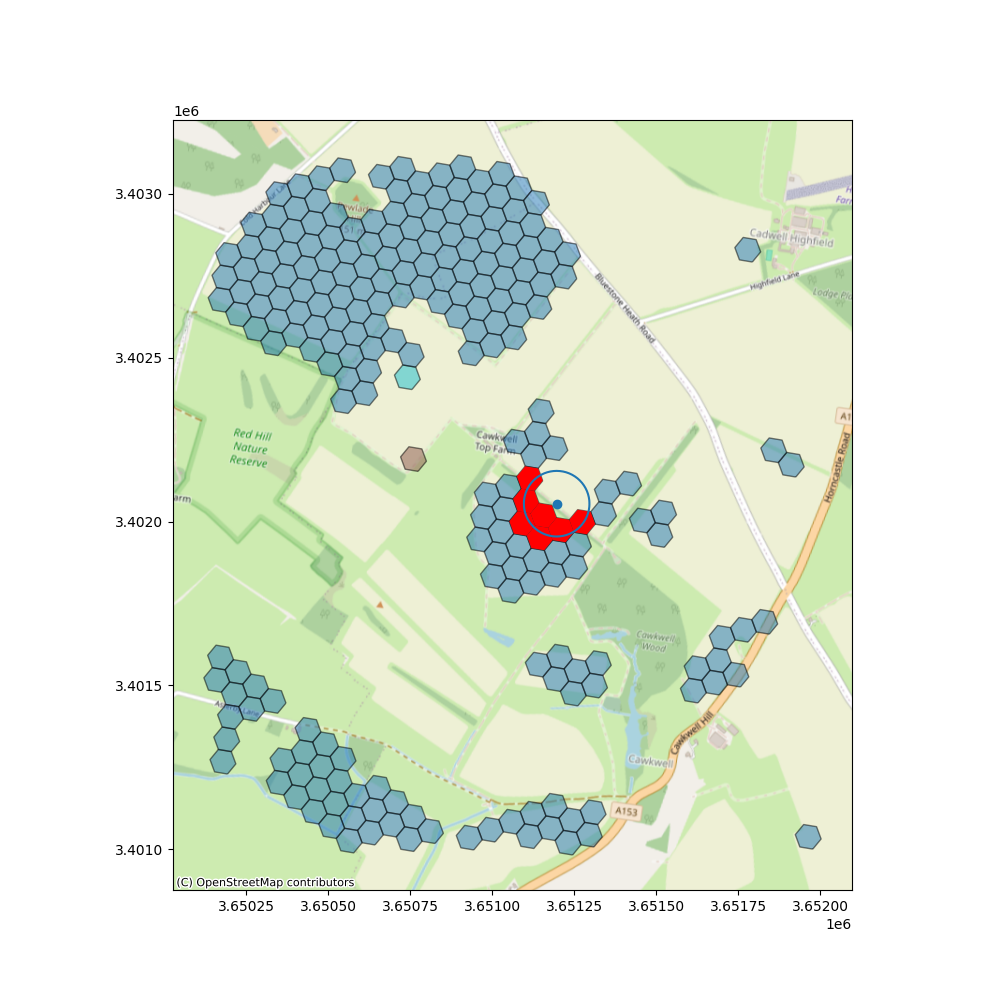

In [72]:

ax = crome_data.plot('lucode',figsize=(10, 10), alpha=0.5, edgecolor="k")
# arable_samples_loc_yr_unique.plot(figsize=(10, 10), alpha=0.5, edgecolor="k", ax=ax)
cx.add_basemap(ax, crs=arable_samples_loc_yr_unique.crs, source=cx.providers.OpenStreetMap.Mapnik, zoom=15)

arable_samples_loc_yr_unique.loc[[id]].plot(ax=ax)
arable_samples_loc_yr_unique.loc[[id]].buffer(100).exterior.plot(ax=ax)
nearby_spring_cereal_cells.plot(ax=ax, color='red')